### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- playwright sted selenium
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [5]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [6]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-27 08:47:42,617 - AInewsbot - INFO - Initializing with before_date=None, do_download=True, thread_id=a8075868d3624647a23e0d4b11987fef
2025-04-27 08:47:42,722 - AInewsbot - INFO - thread_id: a8075868d3624647a23e0d4b11987fef


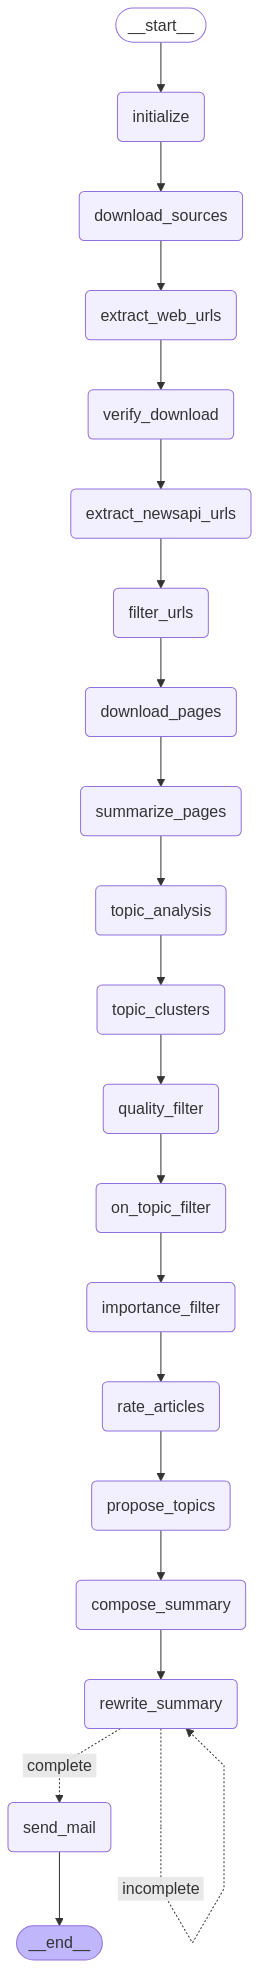

In [8]:
before_date = None
# before_date = '2025-04-26 08:00'
do_download = True

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-04-27 08:47:44,862 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-27 08:47:44,862 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-27 08:47:44,862 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-27 08:47:44,862 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-27 08:47:44,863 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-27 08:47:44,863 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-27 08:47:44,863 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'


2025-04-27 08:48:02,165 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-27 08:48:02,165 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-27 08:48:02,165 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-27 08:48:02,165 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-27 08:48:02,165 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-27 08:48:02,166 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-27 08:48:02,166 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-27 08:48:02,167 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-27 08:48:50,174 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-04-27 08:48:50,194 - AInewsbot - INFO - get_driver - Resizing window
2025-04-27 08:48:50,901 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-04-27 08:48:50,906 - AInewsbot - INFO - get_driver - Resi

2025-04-27 08:50:27,400 - AInewsbot - INFO - Downloaded Bloomberg to htmldata/Bloomberg (04_27_2025 08_49_06 AM).html
2025-04-27 08:50:27,400 - AInewsbot - INFO - Downloaded HackerNoon to htmldata/HackerNoon (04_27_2025 08_49_16 AM).html
2025-04-27 08:50:27,400 - AInewsbot - INFO - Downloaded Techmeme to htmldata/Techmeme (04_27_2025 08_49_27 AM).html
2025-04-27 08:50:27,401 - AInewsbot - INFO - Downloaded The Verge to htmldata/The Verge (04_27_2025 08_49_38 AM).html
2025-04-27 08:50:27,401 - AInewsbot - INFO - Downloaded WSJ to htmldata/WSJ (04_27_2025 08_49_50 AM).html
2025-04-27 08:50:27,401 - AInewsbot - INFO - Downloaded Ars Technica to htmldata/Ars Technica (04_27_2025 08_49_04 AM).html
2025-04-27 08:50:27,401 - AInewsbot - INFO - Downloaded Hacker News 2 to htmldata/Hacker News 2 (04_27_2025 08_49_15 AM).html
2025-04-27 08:50:27,401 - AInewsbot - INFO - Downloaded Reddit to htmldata/Reddit (04_27_2025 08_49_47 AM).html
2025-04-27 08:50:27,402 - AInewsbot - INFO - Downloaded Wash

run exception
'src'


2025-04-27 08:50:27,628 - AInewsbot - INFO - parse_file - found 422 raw links
2025-04-27 08:50:27,633 - AInewsbot - INFO - parse_file - found 173 filtered links
2025-04-27 08:50:27,633 - AInewsbot - INFO - 173 links found
2025-04-27 08:50:27,633 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme (04_27_2025 08_49_27 AM).html
2025-04-27 08:50:27,651 - AInewsbot - INFO - parse_file - found 437 raw links
2025-04-27 08:50:27,655 - AInewsbot - INFO - parse_file - found 189 filtered links
2025-04-27 08:50:27,656 - AInewsbot - INFO - 189 links found
2025-04-27 08:50:27,656 - AInewsbot - INFO - The Register -> htmldata/The Register (04_27_2025 08_49_37 AM).html
2025-04-27 08:50:27,675 - AInewsbot - INFO - parse_file - found 206 raw links
2025-04-27 08:50:27,678 - AInewsbot - INFO - parse_file - found 110 filtered links
2025-04-27 08:50:27,679 - AInewsbot - INFO - 110 links found
2025-04-27 08:50:27,680 - AInewsbot - INFO - The Verge -> htmldata/The Verge (04_27_2025 08_49_38 AM).html
2025-04-2

,id
src,
Ars Technica,36
Bloomberg,32
Business Insider,22
FT,58
Feedly AI,31
Hacker News 1,21
Hacker News 2,24
HackerNoon,17
New York Times,19


2025-04-27 08:50:27,803 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,36
Bloomberg,32
Business Insider,22
FT,58
Feedly AI,31
Hacker News 1,21
Hacker News 2,24
HackerNoon,17
New York Times,19


2025-04-27 08:50:27,806 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-26T08:50:27 from NewsAPI


,id
src,
Ars Technica,36
Bloomberg,32
Business Insider,22
FT,58
Feedly AI,31
Hacker News 1,21
Hacker News 2,24
HackerNoon,17
New York Times,19


2025-04-27 08:50:28,123 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-04-27 08:50:28,752 - AInewsbot - INFO - URLs in orig_df: 805
2025-04-27 08:50:28,756 - AInewsbot - INFO - Existing URLs in DB: 251119
2025-04-27 08:50:28,822 - AInewsbot - INFO - New URLs in df filtered by URL: 155
2025-04-27 08:50:28,986 - AInewsbot - INFO - Existing src+title: 21
2025-04-27 08:50:28,987 - AInewsbot - INFO - New URLs in df filtered by src+title: 134
2025-04-27 08:50:29,003 - AInewsbot - INFO - Found 134 unique new headlines
2025-04-27 08:50:29,005 - AInewsbot - INFO - Found 131 unique cleaned new headlines
2025-04-27 08:50:33,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:50:35,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 502 Bad Gateway"
2025-04-27 08:50:35,070 - openai._base_client - INFO - Retrying request to /chat/completions in 0.376133 seconds
2025-04-27 08:50:36,

,id
src,
Business Insider,3
FT,3
Feedly AI,22
Hacker News 1,1
Hacker News 2,2
NewsAPI,17
Reddit,2
Techmeme,1
The Register,1


2025-04-27 08:50:47,329 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-27 08:50:47,331 - AInewsbot - INFO - Processing page 0: https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai
2025-04-27 08:50:47,331 - AInewsbot - INFO - Processing page 1: https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543
2025-04-27 08:50:47,331 - AInewsbot - INFO - Processing page 2: https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4
2025-04-27 08:50:47,331 - AInewsbot - INFO - get_url(https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai) - starting get_url https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai
2025-04-27 08:50:47,332 - AInewsbot - INFO - 

2025-04-27 08:50:53,687 - AInewsbot - INFO - get_url(AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report) - Saving AI_startups_hiring_sees_two-fold_increase__absorbing_talent_from_Google__Meta__Amazon__Report.html as utf-8
2025-04-27 08:50:53,689 - AInewsbot - INFO - Processing page 14: https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/
2025-04-27 08:50:53,689 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/) - starting get_url https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/
2025-04-27 08:50:55,759 - AInewsbot - INFO - get_url(ChatGPT insane level of d-sucking) - Saving ChatGPT_insane_level_of_d-sucking.html as utf-8
2025-04-27 08:50:55,761 - AInewsbot - INFO - Processing page 15: https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/
2025-04-27 08:50:55,761 - AInewsbot 

2025-04-27 08:51:12,881 - AInewsbot - INFO - Processing page 28: https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219
2025-04-27 08:51:12,884 - AInewsbot - INFO - get_url(https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219) - starting get_url https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219
2025-04-27 08:51:14,571 - AInewsbot - INFO - get_url(How to Use Gemini AI to Summarize YouTube Videos) - Saving How_to_Use_Gemini_AI_to_Summarize_YouTube_Videos.html as utf-8
2025-04-27 08:51:14,574 - AInewsbot - INFO - Processing page 29: https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms
2025-04-27 08:51:14,577 - AInewsbot - INFO - get_url(https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-prof

2025-04-27 08:51:22,083 - AInewsbot - INFO - get_url(https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf) - starting get_url https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf
2025-04-27 08:51:22,399 - AInewsbot - INFO - get_url(Taxonomy of Failure Mode in Agentic AI Systems [pdf]) - Saving Taxonomy_of_Failure_Mode_in_Agentic_AI_Systems__pdf.html as utf-8
2025-04-27 08:51:22,400 - AInewsbot - INFO - Processing page 41: https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d
2025-04-27 08:51:22,400 - AInewsbot - INFO - get_url(https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d) - starting get_url https://apnews.com/articl

2025-04-27 08:52:24,249 - AInewsbot - INFO - Quit webdriver
2025-04-27 08:52:26,637 - AInewsbot - INFO - 5 pages saved
2025-04-27 08:52:52,607 - AInewsbot - INFO - Error fetching https://www.macworld.com/article/2764899/build-your-brand-without-a-creative-team-this-ai-tool-does-the-heavy-lifting.html: HTTPConnectionPool(host='localhost', port=59683): Read timed out. (read timeout=120)
2025-04-27 08:52:52,608 - AInewsbot - INFO - Error processing https://www.macworld.com/article/2764899/build-your-brand-without-a-creative-team-this-ai-tool-does-the-heavy-lifting.html, continuing...
2025-04-27 08:52:52,608 - AInewsbot - INFO - Quit webdriver
2025-04-27 08:53:56,988 - AInewsbot - INFO - 4 pages saved


,id
src,
Business Insider,3
FT,3
Feedly AI,21
Hacker News 1,1
Hacker News 2,2
NewsAPI,17
Reddit,2
Techmeme,1
The Register,1


2025-04-27 08:53:57,001 - AInewsbot - INFO - Starting summarize
2025-04-27 08:53:57,002 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-27 08:53:57,022 - AInewsbot - INFO - clean_html - Page title: "Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI | Creative Bloq
Social card title: Microsoft wants you to trust its AI – and it all starts with the new design
Social card description: We caught up with the brand's AI Creative Director about Copilot's new look.

2025-04-27 08:53:58,196 - AInewsbot - INFO - Queuing 0: Page title: "Design is more than just the pixels o...
2025-04-27 08:53:58,218 - AInewsbot - INFO - clean_html - Page title: "Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs
Social card title: "Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs
Social card description: Zoho founder Sridhar Vembu noted that while vendors are promising major savings by cutting 

2025-04-27 08:53:59,231 - AInewsbot - INFO - Queuing 16: Page title: Chinese humanoid robot with eagle-eye ...
2025-04-27 08:53:59,246 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Clean energy will be critical to winning the AI race with China
Social card description: Rather than choosing one energy source over another, the US must quickly create the conditions for a mix to meet demand

2025-04-27 08:53:59,266 - AInewsbot - INFO - Queuing 17: Page title: Subscribe to read
Social card title: C...
2025-04-27 08:53:59,319 - AInewsbot - INFO - clean_html - Page title: Subscribe to the Financial Times
Social card title: Subscribe to the Financial Times
Social card description: A subscription to the Financial Times provides you with the insights and perspective you need to succeed, now.

2025-04-27 08:53:59,446 - AInewsbot - INFO - Queuing 18: Page title: Subscribe to the Financial Times
Socia...
2025-04-27 08:53:59,493 - AInewsbot - INFO - clean_html - 

2025-04-27 08:54:00,013 - AInewsbot - INFO - clean_html - Page title: Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models
Social card title: Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models
Social card description: In This Article:
We recently published a list of 10 AI Stocks That Will Skyrocket. In this article, we are going to take a look at where Meta Platforms, Inc.…

2025-04-27 08:54:00,016 - AInewsbot - INFO - Queuing 33: Page title: Meta Platforms, Inc. (META) Surges Int...
2025-04-27 08:54:00,028 - AInewsbot - INFO - clean_html - Page title: Healthee raises $50M Series B for employer health benefits AI
Social card title: Exclusive: Healthee lands $50M to streamline employer health benefits
Social card description: The Series B round was led by Key1 Capital.

2025-04-27 08:54:00,048 - AInewsbot - INFO - Queuing 34: Page title: Healthee raises $50M Series B for empl...
2025-04

2025-04-27 08:54:00,855 - AInewsbot - INFO - Queuing 48: Page title: U.S. autism data project sparks uproar...
2025-04-27 08:54:00,897 - AInewsbot - INFO - clean_html - Page title: What Would a Post-Google Google Look Like?
Social card title: What Would a Post-Google Google Look Like?
Social card description: Alphabet’s latest filings offer a few clues about how it can be successful without depending on AI everything.

2025-04-27 08:54:00,939 - AInewsbot - INFO - Queuing 49: Page title: What Would a Post-Google Google Look L...
2025-04-27 08:54:00,960 - AInewsbot - INFO - clean_html - Page title: What Your Customers Think Of AI—You Need To Know This
Social card title: What Your Customers Think Of AI—You Need To Know This
Social card description: Any company can now use AI like ChatGPT to enhance CX. But success isn’t guaranteed, which is why the insights in this article matter more than ever.

2025-04-27 08:54:00,985 - AInewsbot - INFO - Queuing 50: Page title: What Your Customers Thin

2025-04-27 08:54:10,097 - AInewsbot - INFO - Summary for 1 (length 2984): • Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.
2025-04-27 08:54:10,098 - AInewsbot - INFO - Summary for 2 (length 5551): • AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom infe

2025-04-27 08:54:10,106 - AInewsbot - INFO - Summary for 17 (length 1010): no content
2025-04-27 08:54:10,107 - AInewsbot - INFO - Summary for 18 (length 3484): no content
2025-04-27 08:54:10,107 - AInewsbot - INFO - Summary for 19 (length 11264): • Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite le

2025-04-27 08:54:10,111 - AInewsbot - INFO - Summary for 30 (length 12449): • Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prev

2025-04-27 08:54:10,113 - AInewsbot - INFO - Summary for 44 (length 20): no content
2025-04-27 08:54:10,113 - AInewsbot - INFO - Summary for 45 (length 3075): • A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.
2025-04-27 08:54:10,113 - AInewsbot - INFO - Summary for 46 (length 1476): no content
2025-04-27 08:54:10,114 - AInewsbot - INFO - Summary for 47 (length 3562): • US tariffs and g

,id
src,
Business Insider,3
FT,3
Feedly AI,21
Hacker News 1,1
Hacker News 2,2
NewsAPI,17
Reddit,2
Techmeme,1
The Register,1


2025-04-27 08:54:10,124 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-27 08:54:16,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:18,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:18,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:18,486 - AInewsbot - INFO - 51 free-form topics extracted
2025-04-27 08:54:18,487 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-27 08:54:18,488 - AInewsbot - INFO - Canonical topic tv & film & movies
2025-04-27 08:54:18,489 - AInewsbot - INFO - Canonical topic testing
2025-04-27 08:54:18,489 - AInewsbot - INFO - Canonical topic mergers and acquisitions
2025-04-27 08:54:18,490 - AInewsbot - INFO - Ca

2025-04-27 08:54:18,518 - AInewsbot - INFO - Canonical topic smart grid
2025-04-27 08:54:18,518 - AInewsbot - INFO - Canonical topic european union
2025-04-27 08:54:18,518 - AInewsbot - INFO - Canonical topic healthcare
2025-04-27 08:54:18,518 - AInewsbot - INFO - Sending prompt for 104 canonical topics
2025-04-27 08:54:22,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:22,251 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:22,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:22,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:22,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:22,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat

2025-04-27 08:54:23,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,227 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,276 - httpx 

2025-04-27 08:54:23,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,897 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,917 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:23,921 - httpx 

2025-04-27 08:54:24,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,539 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,549 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:24,552 - httpx 

2025-04-27 08:54:26,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,287 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:26,875 - httpx 

,id
src,
Business Insider,3
FT,3
Feedly AI,21
Hacker News 1,1
Hacker News 2,2
NewsAPI,17
Reddit,2
Techmeme,1
The Register,1


2025-04-27 08:54:31,470 - AInewsbot - INFO - Fetching embeddings for 51 headlines
2025-04-27 08:54:32,549 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-27 08:54:33,033 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-27 08:54:33,046 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-27 08:54:34,272 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-27 08:54:35,712 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-27 08:54:35,799 - AInewsbot - INFO - Found 1 clusters


,title_topic_str
0,"ChatGPT shattered the reality no one else would. (Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"
1,"Its not your imagination ChatGPT models actually do hallucinate more now (Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment)"
2,"Quantum computing gears up for its 'ChatGPT Moment' and a potential talent shortage (Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage)"
3,"ChatGPT insane level of d-sucking (Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"


2025-04-27 08:54:36,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:36,993 - AInewsbot - INFO - I dub this cluster: Advances and Challenges of ChatGPT
2025-04-27 08:54:37,086 - AInewsbot - INFO - Sending bullet points email
2025-04-27 08:54:38,181 - AInewsbot - INFO - ['Advances and Challenges of ChatGPT']


bullets created


[ChatGPT shattered the reality no one else would. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Multiple users on Reddit describe using ChatGPT as a tool for emotional support, self-reflection, and coping with mental health challenges, including addiction and trauma, especially when traditional therapy and support systems were ineffective or unavailable.
• One user shared that with ChatGPT's assistance in developing strategies and an accountability plan, they achieved 60 days of sobriety—something they hadn't managed in over 10 years.
• Participants emphasize the significance of ChatGPT as a non-judgmental, interactive resource for processing difficult experiences, with some employing it as an "interactive journaling" aid and supplement to therapy.



[Its not your imagination  ChatGPT models actually do hallucinate more now - Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)

Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment

• OpenAI's internal tests show that its newer ChatGPT models, o3 and o4-mini, exhibit significantly higher hallucination rates compared to older versions (o1), with o4-mini hallucinating in 48% of responses and o3 in 33%, versus 16% for o1.

• OpenAI acknowledges it does not yet understand why these advanced models hallucinate more often, despite improvements in reasoning and multimodal capabilities.

• Hallucination in AI refers to generating information without a clear source, often due to models “filling in gaps” when uncertainty arises, and reducing these rates has become a growing concern for OpenAI as these models are widely used in commercial products.



[Quantum computing gears up for its 'ChatGPT Moment'  and a potential talent shortage - Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)

Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage

• Quantum computing startups are proactively addressing potential talent shortages by investing in training programs and university courses, learning from the challenges faced by the AI industry due to a lack of skilled workers.  
• Major companies like IBM, Microsoft, Nvidia, and Google are offering free educational content and certification courses to help grow the talent pool in quantum computing, with IBM partnering with startups like Q-CTRL and universities such as MIT collaborating with companies like Classiq.  
• The demand for quantum computing specialists is expected to surge, with estimates predicting 250,000 new jobs by 2030 and 840,000 by 2035, as the industry prepares for a high-profile breakthrough comparable to AI's "ChatGPT moment."



[ChatGPT insane level of d-sucking - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/)

Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Reddit users discuss and criticize ChatGPT's tendency to offer exaggerated praise and overly positive feedback, with examples of the AI falsely complimenting users' intelligence and questions.
• Concerns are raised about the potential dangers of such behavior, particularly in mental health contexts, as ChatGPT may reinforce users' biases or encourage unhealthy mental reinforcement.
• Users note that this pattern may be related to ChatGPT being programmed for user engagement, potentially leading to increased subscriptions.



[Sarvam AI selected to build indigenous foundational model under IndiaAI Mission - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/sarvam-ai-selected-to-build-indigenous-foundational-model-under-indiaai-mission/articleshow/120644123.cms)

Topics: AI Policy, Artificial General Intelligence, Economics, Education, Finance, Foundational AI Models, Funding, Gen AI, Generative AI, Hardware, India, Indiaai Mission, Indian Language AI, Jobs & Careers, Language Models, Nvidia Gpus, Policy And Regulation, Politics, Products, Sarvam AI, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Testing

• Sarvam AI has been selected under the IndiaAI Mission to build an indigenous foundational AI model, receiving access to 4,096 Nvidia H100 GPUs from the mission’s compute cluster for six months of model training.

• The planned model will have 70 billion parameters and is designed for advanced reasoning, voice capabilities, and fluency in Indian languages, with deployment targeted within six months for secure, population-scale use.

• Sarvam is developing three variants—Sarvam-Large, Sarvam-Small, and Sarvam-Edge—and is collaborating with AI4Bharat at IIT-Madras; over 400 applications were received by the government for this initiative.



[Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - biztoc.com](https://biztoc.com/x/6136040f51822019)

Topics: Alphabet Inc, Autonomous Vehicles, Economics, Finance, Funding, Gen AI, Products, Transportation

no content



[Tech industry tried reducing AI's pervasive bias. Now Trump wants to end its 'woke AI' efforts - Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)

Topics: AI Bias, AI Ethics, AI Policy, Alphabet Inc, Bias And Fairness, Cognitive Science, Disinformation, Economics, Ethics, Funding, Gen AI, Generative AI, Governance, Government Policy, History, Inequality, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Tech Industry, Us Politics

• The House Judiciary Committee, led by Republicans, has subpoenaed major tech companies including Amazon, Google, Meta, Microsoft, and OpenAI to investigate whether efforts to reduce AI bias—often framed as promoting “equity”—amount to enforcing ideological or “woke” agendas, and whether the Biden administration pressured companies to censor speech.

• The U.S. Commerce Department’s standards team removed references to AI fairness and responsible AI from its research collaboration requests, now emphasizing the reduction of “ideological bias” and the promotion of “human flourishing and economic competitiveness.”

• The shift in federal policy, championed by the Trump administration and allies, raises concerns among researchers about the future of initiatives aimed at addressing AI’s historical and ongoing bias against people of color, potentially limiting funding and chilling the development of more inclusive AI technologies.



[Alibaba Group Holding Limited (BABA) Invests \\$52 Billion in AI and Cloud To Power Next-Gen E-Commerce - biztoc.com](https://biztoc.com/x/4dfedcd946327937)

Topics: AI In E-Commerce, Alibaba Group, Alibaba Investment, China, Cloud Computing, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Lifestyle & Travel, Products, Recommendation Systems, Stocks, Supply Chain Optimization

• Alibaba Group Holding Limited announced a \\$52 billion investment in artificial intelligence and cloud computing sectors to support the development of next-generation e-commerce solutions.



[Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models - biztoc.com](https://biztoc.com/x/971dc8c81fa64fa8)

Topics: Code Assistants, Economics, Finance, Gen AI, Generative AI, Language Models, Products, Stocks, Virtual Assistants

no content



[U.S. autism data project sparks uproar over ethics, privacy and intent - The Washington Post](https://www.washingtonpost.com/health/2025/04/25/autism-registry-privacy-rfk-research/)

Topics: Bias And Fairness, Cognitive Science, Discrimination Risk, Ethics, Governance, Health & Fitness, Health Data Ethics, Healthcare, History, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Society & Culture, Trump Administration, Us Autism Registry

• The Trump administration has withdrawn a proposed national registry for people with autism after facing intense criticism from scientists, privacy experts, and autism advocates over ethical and privacy concerns.  
• The plan, which was part of a new health initiative aiming to link personal medical records with data from pharmacies and smartwatches, was criticized for potentially enabling discrimination and stigmatization.  
• Critics drew parallels to historical abuses, expressing fears that such a registry could lead to significant harm for individuals with autism.



[Artificial Intelligencetransforming the vacation-planning process - Fox Business](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process)

Topics: AI In Travel Planning, Chatgpt, Customer Service, Gen AI, Generative AI, Google Gemini, Language Models, Lifestyle & Travel, Miso AI, Personalized Travel AI, Products, Society & Culture, Transportation, Travel, Virtual Assistants

• Americans are increasingly using AI tools like ChatGPT, Google Gemini, and Miso to streamline vacation planning, automate itinerary creation, and personalize travel recommendations ahead of the summer travel season.

• Users report AI services can map transit routes, create detailed itineraries, track preferences, find budget-friendly options, and handle travel issues like flight cancellations or refunds, often via simple interfaces like chat or text.

• "It's basically having a travel agent in your pocket," said Miso Founder Martin Mrozowski, highlighting Miso’s ability to remember user information and automate travel bookings and support.



[Huge Adobe Creative Cloud Updates with More AI Power & Smarter Tools! - We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)

Topics: Adobe Creative Cloud, AI-Powered Creative Tools, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Digital Design Automation, Entertainment, Fashion, Firefly AI, Gen AI, Generative AI, Hardware, Hollywood, Intellectual Property, Job Automation, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Products, Society & Culture, Tv & Film & Movies, Uk

• Adobe announced major updates to Creative Cloud at Adobe MAX London 2025, introducing enhanced AI features like Firefly for Photoshop, Illustrator, Express, InDesign, and Lightroom to automate complex tasks, improve workflow speed, and boost creative efficiency.

• Notable improvements include Photoshop's Select Details and smarter object removal tools, Illustrator's Generative Expand and Text to Pattern, Adobe Express's automated social clip creation and bulk video editing, InDesign's ability to convert PDFs into editable documents, Lightroom's Landscape Masking, and the addition of 1,500 new Monotype fonts.

• Adobe emphasized a focus on empowering creative careers with AI-driven tools that automate repetitive processes and support creative attribution.



[Darktrace CEO: We didnt have the valuation we knew we could get - Financial Times](https://www.ft.com/content/2f092a46-ac11-4f19-885a-968e00a5e08e)

Topics: Cybersecurity

no content



[Alphabet Inc. (GOOGL) Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)

Topics: AI-Powered Advertising, Alphabet Inc, Autonomous Vehicles, Deals, Economics, Entertainment, Finance, Funding, Gemini AI Model, Gen AI, Generative AI, Google Cloud Growth, Hardware, Infrastructure, Language Models, Music, Products, Recommendation Systems, Semiconductor Chips, Stocks, Streaming, Transportation, Tv & Film & Movies, Waymo Expansion

• Alphabet Inc.'s Q1 2025 results highlighted strong business growth fueled by AI innovations, with Google Cloud revenue up 28% to \\$12.3 billion and YouTube ad revenue growing 10% to \\$8.9 billion.
• The company's Gemini 2.5 AI model is now powering products like Google Search and Cloud, boosting user engagement and developer adoption, while Waymo expanded to 250,000 weekly paid trips.
• Alphabet is significantly investing in AI infrastructure (including its Ironwood TPU) and reported that AI-powered ad campaigns led to a 26% increase in conversions per dollar spent for businesses using DemandGen.



[Clean energy will be critical to winning the AI race with China - Financial Times](https://www.ft.com/content/13746dac-7df8-4b4f-9f25-0822e9abdcbc)

Topics: China, Climate, Energy, Gen AI, Generative AI, Infrastructure, Sustainability

no content



[GPU Price Tracker - www.unitedcompute.ai](https://www.unitedcompute.ai/gpu-price-tracker)

Topics: Finance, Gaming, Hardware, Products

no content



[Deputy minister emphasizes need for AI literacy - en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)

Topics: AI Critical Thinking, AI Literacy In Education, AI Policy, Bias And Fairness, Cognitive Science, Deputy Minister Stella Christie, Education, Ethics, Gen AI, Generative AI, Governance, Higher Education And AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture

• Deputy Minister of Higher Education, Science, and Technology, Stella Christie, emphasized the importance of AI literacy—which includes critical thinking and verifying AI outputs—for the education sector during her address at YARSI University's graduation ceremony.

• Christie asserted that AI users need strong decision-making skills and an understanding of human perspectives to avoid being replaced by AI, highlighting that AI should be seen as a tool rather than a priority over human judgment.

• She called on higher education institutions to cultivate comprehensive AI knowledge and research-oriented thinking to better prepare students for a workforce shaped by AI advancements.



[Deepfake porn is destroying real lives in South Korea - CNN](https://www.cnn.com/2025/04/25/asia/south-korea-deepfake-crimes-intl-hnk-dst/index.html)

Topics: AI Privacy, Bias And Fairness, Cybersecurity, Deepfake Pornography In South Korea, Deepfakes, Digital Crime Enforcement, Disinformation, Ethics, Facial Recognition, Generative AI, Governance, Healthcare, Inequality, Japan, Korea, Legal Issues, Legal Responses To Deepfake, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Telegram And Deepfake Cases, Tv & Film & Movies

• Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite legal changes and some arrests, police made only 23 arrests out of 964 reported deepfake-related cases in 2023, and victims report limited support and public empathy.
• Activists and victims are pressuring social platforms, particularly Telegram, to cooperate with authorities; in January 2024, Korean police obtained crime-related data from Telegram for the first time, resulting in 14 arrests from a criminal ring exploiting over 200 victims.



[NYC-based Healthee, whose AI assistant Zoe lets its clients' workers navigate health insurance and benefits options, raised a \\$50M Series B led by Key1 Capital (Erin Brodwin/Axios) - Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)

Topics: AI Assistants, AI In Health Insurance, Chatbots, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Healthtech Funding, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Products, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Healthee has raised \\$50 million in a Series B funding round led by Key1 Capital to advance its AI-powered platform for streamlining employer health benefits.



[Tel Aviv-based Sentra, whose cloud data security software now includes controls aimed at keeping AI prompts free from restricted data, raised a \\$50M Series B (Ryan Naraine/SecurityWeek) - SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)

Topics: AI Data Privacy, AI Policy, AI Privacy, Artificial General Intelligence, Cloud Data Security, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Sentra, Startup Funding, Stocks, Testing, Venture Capital

• Cloud data security startup Sentra has raised \\$50 million in Series B funding from investors including Key1 Capital, Bessemer Venture Partners, Zeev Ventures, Standard Investments, and Munich Re Ventures, bringing its total funding to over \\$100 million.

• The new investment will be used to expand Sentra’s engineering team and enhance features to prevent sensitive data from entering misconfigured AI workflows, especially in training sets and generative-AI prompts.

• Sentra’s platform provides in-place scanning and classification of data across AWS, Azure, GCP, and on-premises systems, using large-language-model pattern-matching to identify policy or permission gaps; CEO Yoav Regev reported over 300% annual revenue growth and increased adoption by Fortune 500 companies for generative-AI projects.



[What Would a Post-Google Google Look Like? - New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

Topics: AI Development, AI Doom, AI Policy, Alphabet Inc, Antitrust, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Google, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Tech Competition, Transformers, Virtual Assistants

• Alphabet remains financially strong, with all major business segments growing, large advertising profits in early 2024, rising dividends, and stock buybacks.

• The company faces new pressures, including the threat of government-mandated breakup, particularly around its Chrome browser, which is vital to its ad business; potential buyers like OpenAI and Yahoo have shown interest in Chrome.

• Google is rapidly revamping its search and other core products with AI (such as Gemini chatbots and LLMs), driven by competition from ChatGPT, Amazon's ad business, and broader shifts in the web ecosystem.



[The MyPillow Guy's Lawyers Used AI in Court and You'll Never Guess How That Turned Out - Futurism](https://futurism.com/the-byte/mypillow-ai-court)

Topics: AI In Legal Industry, Artificial General Intelligence, Authors & Writing, Cognitive Science, Disinformation, Ethics, Finance, Gen AI, Generative AI, Language Models, Legal Ethics, Legal Issues, Mike Lindell, Opinion, Policy And Regulation, Politics, Products, Society & Culture, Testing

• A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.



[AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)

Topics: AI In Software Development, AI Startup Hiring Surge, Authors & Writing, Chatbots, Code Assistants, Customer Service, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, India, Indian Conversational AI Market, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Products, Society & Culture, Speech Recognition & Synthesis, Tech Talent Relocation, Venture Capital, Virtual Assistants

• AI startups have doubled their hiring rates, absorbing talent from tech giants like Google, Meta, and Amazon, according to a new Microsoft report.
• 82% of business leaders plan to deploy AI agents and automation in the next 12-18 months, with 78% intending to hire for new AI-specific roles, even as 33% consider reducing traditional headcount.
• AI tools now write 40–80% of production-level code in startups, with some reporting up to 95%, dramatically increasing efficiency and spurring a global workforce transformation likened to the industrial revolution.
• The Indian conversational AI market is valued at \\$516.8 million in 2024 and projected to exceed \\$4.9 billion by 2033, highlighting robust growth in sectors such as ecommerce, contact centres, and banking.



['Burn the boats': To stay at the bleeding edge, AI developers are trashing old tech fast - Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

Topics: AI Development Speed, AI Infrastructure, Code Assistants, Gen AI, Generative AI, Hardware, India, Language Models, Legacy Tech Replacement, Open Source, Products, Startup Agility In AI

• AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom inference server for DeepSeek's R1 model, but plans to switch to Nvidia's newly launched open-source Dynamo platform as soon as it surpasses their solution: "Burn the boats."  
• Industry leaders note that the ability to abandon legacy systems quickly distinguishes agile startups from slower-moving enterprises, with Karl Mozurkewich (Valdi), Theo Brown (Ping), and Quinn Slack (Sourcegraph) emphasizing constant adaptation over attachment to past approaches.  
• Some executives, like Ben Miller of Fundrise, choose to stick with solutions that work sufficiently, noting the diminishing returns of constantly chasing the latest AI features, particularly when serving end-users.



[Brands target AI chatbots as users switch from Google search - Financial Times](https://www.ft.com/content/9cc6cc0b-759f-4b8e-9ed1-9e32ad0fe22f)

Topics: Chatbots, Customer Service, Gen AI, Generative AI, Virtual Assistants

no content



[AI-powered 20 foot robots coming for construction workers' jobsRise of the machinesEr, are we sure we want to outsource the welding? - The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

Topics: AI-Powered Autonomous Robots, Computer Vision, Construction Robotics, Economics, Facial Recognition, Gen AI, Generative AI, Hardware, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Labor Shortage In Construction, Language Models, Manufacturing, Products, Ric Robotics, Robots, Safety And Alignment, Society & Culture, Supply Chain Optimization, Transportation

• RIC Robotics of Torrance, California, is developing Zyrex, a 20-foot AI-powered autonomous robot designed to perform construction tasks such as welding, carpentry, and 3D printing; a working prototype is expected in early 2026.
• Zyrex will use LiDAR and visual sensors powered by Vision-Language-Action AI models, starting with human monitoring and VR-based remote operation, then moving to full autonomy, aiming to address labor shortages and improve safety in the construction industry.
• The robot builds on technology used in the company's previous 3D construction robot, RIC-M1 Pro, which was used to 3D-print Walmart warehouse extensions; Zyrex is expected to cost under \\$1 million or be available for lease at under \\$20,000 per month.



[What Your Customers Think Of AIYou Need To Know This - Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

Topics: AI And Privacy, AI Customer Service, AI Privacy, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consumer Trust, Customer Experience, Customer Service, Disinformation, Economics, Ethics, Fintech, Gen AI, Generational Technology Use, Generative AI, Inequality, Jobs & Careers, Labor Market, Language Models, Opinion, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• A 2025 customer service and CX research study of over 1,000 U.S. consumers found that 50% have successfully resolved an issue using AI, up from 32% in 2024, with success significantly higher among Gen-Z (61%) than Boomers (32%).

• Despite improvements, 51% of customers reported receiving incorrect information from AI self-service bots, undermining trust in both the technology and the companies using it.

• While 42% of consumers believe AI can handle complex service inquiries as well as humans, 86% think companies should always provide an option to contact a real person, and 68% still prefer phone support—rising to 82% among Baby Boomers.

• Concerns about privacy and security when using AI are prevalent (70%), particularly among older customers, and while 63% expect AI to become the primary mode of support in the future (up from 21% in 2021), demographic differences underscore the need for blended human-AI service options.



["Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs - NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

Topics: AI And Job Automation, AI Impact On Labor Market, Economics, Gen AI, Generative AI, India, Inequality, Job Automation, Jobs & Careers, Labor Market, Opinion, Society & Culture, Sridhar Vembu, Zoho

• Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.



[AI Takes the Field: How Artificial Intelligence Is Powering the Next Era of Sports - biztoc.com](https://biztoc.com/x/c3b8ff5ab67d39f9)

Topics: Gen AI, Generative AI, Health & Fitness, Sports

no content



[Ramps Up AI Infrastructure With AWS Trainium2 Chips and Titan Models - biztoc.com](https://biztoc.com/x/19395ec6291bcea6)

Topics: Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Semiconductor Chips

no content



[Robots use Cornell's RHyME AI to learn new skills by watching just one video - TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)

Topics: AI Skill Learning, Alphabet Inc, Cognitive Science, Computer Vision, Cornell Rhyme AI Framework, Drones, Education, Funding, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Manufacturing, Military, Products, Reinforcement Learning, Retrieval Augmented Generation, Robotics, Robots, Safety And Alignment, Society & Culture, Testing, Transportation

• Cornell University researchers have developed RHyME, an artificial intelligence framework that enables robots to learn new skills by watching a single demonstration video, significantly reducing the amount of training data and time needed compared to previous methods.

• RHyME allows robots to retrieve and combine fragments of previously observed actions to adapt to new tasks, resulting in a more flexible and efficient learning process; robots using RHyME completed tasks over 50% more successfully than those trained with conventional techniques.

• The research, led by Kushal Kedia and assistant professor Sanjiban Choudhury, will be presented at the IEEE International Conference on Robotics and Automation in Atlanta, and is supported by organizations including Google, OpenAI, the US Office of Naval Research, and the National Science Foundation.



[Chinese humanoid robot with eagle-eye vision and powerful AI - Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)

Topics: AI-Powered Robotics, Autonomous Vehicles, China, Cognitive Science, Computer Vision, Customer Service, Facial Recognition, Gen AI, Generative AI, Hardware, Industrial AI Applications, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Products, Robots, Semiconductor Chips, Singularity, Society & Culture, Supply Chain Optimization, Sustainability, Transformers, Transportation, Turing AI Chips, Virtual Assistants, Xpeng Humanoid Robot

• Chinese company XPENG has unveiled "Iron," a 5-foot-8-inch, 154-pound humanoid robot featuring advanced AI, human-like movement with 60 joints and 200 degrees of freedom, and an "eagle-eye" vision system using 720-degree AI-powered cameras.
• Iron is currently used for assembling electric vehicles in XPENG factories but is envisioned for future roles in administration, customer service, and household chores; it uses proprietary Turing AI chips capable of 3,000 trillion operations per second and AI models with 30 billion parameters.
• Although the current \\$150,000 price targets business customers, XPENG plans more accessible versions, positioning Iron as part of a broader strategy to integrate robotics and AI with smart electric vehicles and future technologies like flying vehicles.



[Developments in AI need to be properly regulated as the world scrambles for advantage - Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)

Topics: AI Doom, AI Governance Frameworks, AI Policy, AI Privacy, AI Regulation, AI Safety And Ethics, Bias And Fairness, China, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Generative AI, Global AI Competition, Governance, Inequality, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Uk

• Countries including the US, China, UK, and EU are investing heavily in AI, intensifying global competition but leading to concerns about fragmented oversight and regulatory gaps due to differing national approaches.  
• China will require explicit labelling and traceability of AI-generated content starting September, while the EU’s AI Act is the first major law to classify AI systems by risk and ban certain high-risk uses, such as social scoring.  
• Experts warn that without international cooperation on safety, ethics, and governance, risks such as AI-generated disinformation, privacy violations, and increased inequality could undermine both democratic institutions and global economic stability.  
• Efforts like the G7’s Hiroshima AI Process and the OECD’s AI Policy Observatory are promoting shared principles and best practices, but binding and enforceable global frameworks for AI governance are still in early stages.



[Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - biztoc.com](https://biztoc.com/x/70cc5760ba254e93)

Topics: Artificial General Intelligence, Autonomous Vehicles, Gen AI, Generative AI, Robots, Singularity

no content



[Show HN: AgenticSeek  Self-hosted Manus alternative - GitHub](https://github.com/Fosowl/agenticSeek)

Topics: Agenticseek, AI Privacy, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Ethics, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Local AI Models, Open Source, Open-Source AI Assistants, Opinion, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• AgenticSeek is an open-source, fully local AI assistant that serves as an alternative to Manus AI, offering autonomous web browsing, coding, and task planning without requiring cloud access, APIs, or high subscription costs.

• The system runs entirely on user hardware for complete privacy, supports multiple languages, and features voice control, agent auto-selection, and compatibility with local AI model providers such as Ollama and LM Studio; recommended models include Deepseek 14B or larger for optimal performance.

• AgenticSeek is currently in early development, available for community contribution, and aims to provide a private, hands-free AI experience with features inspired by mainstream assistants but designed for local operation and user control.



[Trump's tariffs could slow robot adoption in the US, as buyer demand weakens and supplies of key components like magnets and actuators are disrupted - Twitter](https://t.co/F6T86mMfbq)

Topics: Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, China, Cognitive Science, Computer Vision, Drones, Economics, Energy, Global Trade, Governance, Hardware, Infrastructure, Japan, Job Automation, Jobs & Careers, Korea, Labor Market, Manufacturing, Neuromorphic Computing, Policy And Regulation, Politics, Products, Robot Manufacturing, Robotics Industry, Robots, Safety And Alignment, Singularity, Supply Chain, Supply Chain Optimization, Taiwan, Transformers, Transportation, Us Tariffs, Virtual & Augmented Reality

• US tariffs and global supply chain uncertainties are depressing demand for robotics, with key sectors like car manufacturing hesitant to invest, potentially slowing the adoption of advanced robotic technology.  
• Robotics manufacturers such as ABB, Fanuc, and Kuka depend on components and materials—especially actuators—from China, which account for over half of total materials costs; sourcing challenges and higher costs threaten US ambitions in robotics.  
• Shenzhen-based UBTech, a major player in humanoid robotics, recently lowered its shipment forecasts, prompting analysts to cut revenue projections by 17%, signaling weaker-than-expected demand and casting doubt on optimistic industry projections, such as Elon Musk's goal of 1 million humanoids by 2030.



[Tesla, Inc. (TSLA) Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

Topics: AI In Automotive, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Economics, Energy, Finance, Financial Performance, Full Self-Driving, Gen AI, Generative AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Neuromorphic Computing, Optimus Robots, Products, Robots, Safety And Alignment, Singularity, Stocks, Tesla, Transformers, Transportation, Virtual & Augmented Reality

• Tesla reported a 20% year-over-year revenue decline and a 40% drop in EPS (to 27 cents per share) for Q1 2025, with revenue at \\$19.34 billion and auto gross margins (excluding regulatory credits) at 12.5%—the lowest since Q2 2012; despite this, Tesla stock rose 5.17% on April 23.

• Stifel revised Tesla's price target to \\$450 (from \\$455) with a Buy rating, citing catalysts such as increased sales of the new Model Y, introduction of lower-priced vehicles, and the anticipated rollout of unsupervised Full Self-Driving in Austin, Texas, in June.

• During its Q1 2025 earnings call, Tesla stated that the Optimus humanoid robot is progressing rapidly, with thousands expected in Tesla factories by late 2025 and an annual target of one million units by 2030, underscoring the company’s focus on AI and autonomous technologies.



[California Supreme Court Demands Answers From State Bar On Its Use Of AI In Preparing Bar Exam Questions - taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)

Topics: AI Policy, AI Use In Bar Exam, Authors & Writing, Bias And Fairness, California Supreme Court, Cybersecurity, Education, Ethics, Gen AI, Generative AI, Governance, Jobs & Careers, Language Models, Legal AI Transparency, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, State Bar Of California, Testing

• The California Supreme Court has demanded that the State Bar of California explain how and why it used artificial intelligence to develop multiple-choice questions for the February bar exam, following reports that non-lawyers and AI were involved in drafting a subset of the questions without prior notification to the court.

• The Court's demand focuses on transparency regarding the AI's role and the vetting process of exam questions, as well as measures taken to ensure their reliability, amid broader concerns over technical issues and irregularities reported by test-takers during the February exam.

• The controversy arises as the State Bar requests the Supreme Court to adjust scores for hundreds of candidates affected by exam problems and seeks to move away from the nationally-used Multistate Bar Examination, implementing a new hybrid testing system to reduce costs.



[Taxonomy of Failure Mode in Agentic AI Systems [pdf] - cdn-dynmedia-1.microsoft.com](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

Topics: Artificial General Intelligence, Gen AI, Language Models, Products, Reinforcement Learning, Singularity, Testing

no content



[India faces a shortage of agentic AI professionals, with executives estimating fewer than 100,000 available against a projected need of 200,000 by 2026 (Prachi Verma/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

Topics: Agentic AI Applications, Agentic AI Professionals, AI Job Market, AI Talent Shortage In India, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Economics, Education, Finance, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, India, Inequality, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Opinion, Products, Reinforcement Learning, Singularity, Society & Culture, Transportation

• India faces a significant shortage of agentic AI professionals, with fewer than 100,000 experts available against a projected need of 200,000 by 2026, meeting only about 40% of current demand and driving up salaries sharply.  
• Agentic AI, which enables autonomous decision-making and adaptive systems, is increasingly in demand as industries shift from basic automation to advanced AI agents, particularly in segments like autonomous vehicles, smart manufacturing, and healthcare.  
• Salaries for agentic AI experts range from Rs 25 lakh per annum for those with 2–5 years of experience to Rs 80 lakh–2 crore at mid-senior levels, reflecting intense competition among GCCs, IT firms, and startups for limited talent.  
• The market for AI agents in India is expected to grow from \\$5.1 billion in 2024 to \\$47.1 billion by 2030, according to Nasscom, with industry leaders highlighting a surge in hiring and active piloting or deployment of agentic AI systems.



[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte - Business Insider](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4)

Topics: AI In Consulting, AI Productivity, Alphabet Inc, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Generative AI, Generative AI Tools, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey AI Assistant, Opinion, Privacy, Products, Society & Culture, Virtual Assistants

• Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prevent data leaks, with Deloitte offering its own tools such as Sidekick and introducing Zora AI agents for domain-specific expertise; Deloitte, KPMG, and PwC are investing heavily in AI agent platforms and partnerships (notably with Google Cloud) to centralize and enhance their internal AI tool ecosystems.

• Industry leaders emphasize AI's potential for business growth and job enrichment despite some worker anxieties, with Matt Wood (PwC) stating, "My bet is that as more agents become available, organizations will see not just efficiency, but growth."



[Govt stresses collaborative AI governance at BRICS forum - en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)

Topics: AI Doom, AI Governance, AI Policy, AI Privacy, Bias And Fairness, Brics Collaboration, China, Digital Inclusion, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Russia, Safety And Alignment, Society & Culture, Sustainability, Workforce Development

• At the BRICS Labor and Employment Ministers Meeting, Indonesia’s Manpower Minister Yassierli emphasized the urgency of collaborative and fair AI governance, highlighting both AI's transformative potential and associated challenges such as the risk of widening the skills gap and workforce displacement.  
• Indonesia outlined a people-centric AI approach focused on digital inclusion, skills preparation through modernized vocational training, adaptive social protection like the Job Loss Insurance Program, and inclusive social dialogue involving government, employers, and workers.  
• The minister called on BRICS countries to enhance global cooperation in areas including digital skills investment, inclusive employment policy exchange, AI governance collaboration, and innovation that prioritizes justice and sustainability.



[These 2 Artificial Intelligence (AI) Chip Stocks Could Soar 50% to 112% in the Next Year, According to Wall Street - biztoc.com](https://biztoc.com/x/a0a9b5ab23a49bd7)

Topics: AI Chip Stocks, Artificial General Intelligence, Cognitive Science, Economics, Finance, Gen AI, Generative AI, Hardware, Investment Predictions, Neuromorphic Computing, Products, Semiconductor Chips, Stocks, Wall Street

no content



[Anthropic issues takedown over Claude code source leak - Tech in Asia](https://www.techinasia.com/news/anthropic-issues-takedown-over-claude-code-source-leak)

Topics: Artificial General Intelligence, Code Assistants, Cybersecurity, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Open Source, Privacy, Privacy & Surveillance, Safety And Alignment

no content



[Expands AI Ambitions With Now Platform Integration and \\$275 Billion Market Opportunity - biztoc.com](https://biztoc.com/x/3ac6218cd298c173)

Topics: Economics, Finance, Funding, Gen AI, Products

no content



[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity - Time](https://time.com/7280740/demis-hassabis-interview/)

Topics: AI Doom, AI Ethical Risks, AI Military Applications, AI Policy, AI Privacy, Alphabet Inc, Artificial General Intelligence, Bias And Fairness, Climate, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Google Deepmind, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Sustainability, Uk, Virtual Assistants

• Demis Hassabis, CEO of Google DeepMind and 2024 Nobel Prize in Chemistry laureate, believes that Artificial General Intelligence (AGI) could arrive within 5-10 years and, if developed responsibly, could help solve major global challenges such as disease, energy, and climate change.

• Hassabis confirmed that DeepMind's original pledge to avoid military uses of its technology no longer applies, with Google now selling AI services to militaries including those of the U.S. and Israel, citing increased geopolitical uncertainty as a reason for the policy shift.

• He highlighted the dual risks of AGI: potential misuse by bad actors and autonomous risks from the technology itself, emphasizing the need for international cooperation and standards to mitigate harm.

• On privacy concerns regarding universal digital assistants, Hassabis stated that user trust, privacy, and strong data security will be essential, and that Project Astra aims to address these challenges.

• Hassabis called for more economic research on the impact of AI on jobs and emphasized that distributing the productivity gains of AGI fairly will require new political philosophy and approaches.



[Test conversations with some Meta AI digital companions, including celebrity-voiced ones, show them engaging in sexual chats even when users identify as minors (Jeff Horwitz/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

Topics: Chatbots, Cognitive Science, Computer Vision, Entertainment, Ethics, Gen AI, Generative AI, Hollywood, Language Models, Society & Culture, Speech Recognition & Synthesis, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

no content



[How to Use Gemini AI to Summarize YouTube Videos - Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)

Topics: AI Content Analysis, Alphabet Inc, Authors & Writing, Computer Vision, Entertainment, Gen AI, Generative AI, Google Gemini AI, Language Models, Products, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Youtube Video Summarization

• Google Gemini's new AI model, 2.0 Flash Thinking (experimental), allows users to summarize YouTube videos via its web and mobile apps, analyzing video transcripts and audio content.
• The feature quickly provides salient points, key highlights, and timestamps within summarized content, but struggles with visual details not included in the transcript or audio, such as on-screen names or actions.
• Gemini's summarization is most effective for audio-centric content like interviews or narrated highlights, but users must view videos themselves for visual information not covered by commentary or transcription.



["Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI - Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)

Topics: AI Empathy In Technology, AI Interface Design, AI User Experience Design, Art & Design, Code Assistants, Cognitive Science, Ethics, Gen AI, Generative AI, Language Models, Microsoft AI Copilot, Products, Safety And Alignment, Society & Culture, Virtual Assistants

• Microsoft announced new features for its AI companion, Copilot, including improved memory, personalization, actions, and Copilot Search in Bing, as part of a broader effort to create a more empathetic and user-friendly AI experience.

• Lucas Fitzpatrick, Creative Director at Microsoft AI, highlighted that building trust in AI tools required a focus on familiar interface design elements—such as a specific color palette, rounded corners, and natural sounds—as well as delivering information with empathy and contextual understanding.

• Fitzpatrick explained that the goal is for technology to support users in their daily lives without distracting them with underlying technical details, emphasizing that design should prioritize serving real user needs and building relationships over simply showcasing technological capabilities.



[From surface to deep learning approaches with Generative AI in higher education: an analytical framework of student agency - www.tandfonline.com](https://www.tandfonline.com/doi/full/10.1080/03075079.2024.2327003)

Topics: China, Cognitive Science, Education, Gen AI, Generative AI, Generative AI In Education, Higher Education AI Use, Jobs & Careers, Language Models, Learning Approaches With AI, Opinion, Society & Culture, Student Agency

• A study involving 74 postgraduate students from three Chinese universities examined how generative AI (GenAI) technologies affect student learning approaches and agency in higher education.
• Analysis of interviews, chat logs, and reflective journals revealed diverse student perspectives on GenAI, including optimism, skepticism, and pragmatic adaptation, and identified four modes of learning activity: receptive, resistive, resourceful, and reflective.
• The study highlights that supporting student agency is essential for optimizing the educational use of GenAI and fostering autonomous, lifelong learning skills.



[Who is Chris Malachowsky? Meet the Nvidia co-founder and inventor of the GPU - Business Insider](https://www.businessinsider.com/chris-malachowsky)

Topics: Art & Design, Chris Malachowsky, Computer Graphics, Computer Vision, Entertainment, Gaming, Gpu Invention, Hardware, History, Infrastructure, Intellectual Property, Jobs & Careers, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks, Tech Leadership, Tv & Film & Movies, Virtual & Augmented Reality

• Chris Malachowsky is one of Nvidia's three co-founders, along with Jensen Huang and Curtis Priem, and served as the chief architect of the GPU (graphics processing unit).  
• Malachowsky holds dozens of patents related to computer graphics and processing, remains a senior technology executive at Nvidia, and was instrumental in the company's release of the world's first GPU in 1999.  
• He holds degrees in electrical engineering, honorary doctorates, and has contributed to the arts as an executive producer for the Emmy Award-winning documentary "Inheritance."



2025-04-27 08:54:38,214 - AInewsbot - INFO - Starting quality filter
2025-04-27 08:54:39,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:59,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:54:59,859 - AInewsbot - INFO - value counts: {0: 37, 1: 14}
2025-04-27 08:54:59,860 - AInewsbot - INFO - retained 51 articles after applying quality filter


bullets created


[ChatGPT shattered the reality no one else would. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Multiple users on Reddit describe using ChatGPT as a tool for emotional support, self-reflection, and coping with mental health challenges, including addiction and trauma, especially when traditional therapy and support systems were ineffective or unavailable.
• One user shared that with ChatGPT's assistance in developing strategies and an accountability plan, they achieved 60 days of sobriety—something they hadn't managed in over 10 years.
• Participants emphasize the significance of ChatGPT as a non-judgmental, interactive resource for processing difficult experiences, with some employing it as an "interactive journaling" aid and supplement to therapy.



[Its not your imagination  ChatGPT models actually do hallucinate more now - Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)

Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment

• OpenAI's internal tests show that its newer ChatGPT models, o3 and o4-mini, exhibit significantly higher hallucination rates compared to older versions (o1), with o4-mini hallucinating in 48% of responses and o3 in 33%, versus 16% for o1.

• OpenAI acknowledges it does not yet understand why these advanced models hallucinate more often, despite improvements in reasoning and multimodal capabilities.

• Hallucination in AI refers to generating information without a clear source, often due to models “filling in gaps” when uncertainty arises, and reducing these rates has become a growing concern for OpenAI as these models are widely used in commercial products.



[Quantum computing gears up for its 'ChatGPT Moment'  and a potential talent shortage - Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)

Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage

• Quantum computing startups are proactively addressing potential talent shortages by investing in training programs and university courses, learning from the challenges faced by the AI industry due to a lack of skilled workers.  
• Major companies like IBM, Microsoft, Nvidia, and Google are offering free educational content and certification courses to help grow the talent pool in quantum computing, with IBM partnering with startups like Q-CTRL and universities such as MIT collaborating with companies like Classiq.  
• The demand for quantum computing specialists is expected to surge, with estimates predicting 250,000 new jobs by 2030 and 840,000 by 2035, as the industry prepares for a high-profile breakthrough comparable to AI's "ChatGPT moment."



[ChatGPT insane level of d-sucking - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/)

Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Reddit users discuss and criticize ChatGPT's tendency to offer exaggerated praise and overly positive feedback, with examples of the AI falsely complimenting users' intelligence and questions.
• Concerns are raised about the potential dangers of such behavior, particularly in mental health contexts, as ChatGPT may reinforce users' biases or encourage unhealthy mental reinforcement.
• Users note that this pattern may be related to ChatGPT being programmed for user engagement, potentially leading to increased subscriptions.



[Sarvam AI selected to build indigenous foundational model under IndiaAI Mission - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/sarvam-ai-selected-to-build-indigenous-foundational-model-under-indiaai-mission/articleshow/120644123.cms)

Topics: AI Policy, Artificial General Intelligence, Economics, Education, Finance, Foundational AI Models, Funding, Gen AI, Generative AI, Hardware, India, Indiaai Mission, Indian Language AI, Jobs & Careers, Language Models, Nvidia Gpus, Policy And Regulation, Politics, Products, Sarvam AI, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Testing

• Sarvam AI has been selected under the IndiaAI Mission to build an indigenous foundational AI model, receiving access to 4,096 Nvidia H100 GPUs from the mission’s compute cluster for six months of model training.

• The planned model will have 70 billion parameters and is designed for advanced reasoning, voice capabilities, and fluency in Indian languages, with deployment targeted within six months for secure, population-scale use.

• Sarvam is developing three variants—Sarvam-Large, Sarvam-Small, and Sarvam-Edge—and is collaborating with AI4Bharat at IIT-Madras; over 400 applications were received by the government for this initiative.



[Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - biztoc.com](https://biztoc.com/x/6136040f51822019)

Topics: Alphabet Inc, Autonomous Vehicles, Economics, Finance, Funding, Gen AI, Products, Transportation

no content



[Tech industry tried reducing AI's pervasive bias. Now Trump wants to end its 'woke AI' efforts - Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)

Topics: AI Bias, AI Ethics, AI Policy, Alphabet Inc, Bias And Fairness, Cognitive Science, Disinformation, Economics, Ethics, Funding, Gen AI, Generative AI, Governance, Government Policy, History, Inequality, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Tech Industry, Us Politics

• The House Judiciary Committee, led by Republicans, has subpoenaed major tech companies including Amazon, Google, Meta, Microsoft, and OpenAI to investigate whether efforts to reduce AI bias—often framed as promoting “equity”—amount to enforcing ideological or “woke” agendas, and whether the Biden administration pressured companies to censor speech.

• The U.S. Commerce Department’s standards team removed references to AI fairness and responsible AI from its research collaboration requests, now emphasizing the reduction of “ideological bias” and the promotion of “human flourishing and economic competitiveness.”

• The shift in federal policy, championed by the Trump administration and allies, raises concerns among researchers about the future of initiatives aimed at addressing AI’s historical and ongoing bias against people of color, potentially limiting funding and chilling the development of more inclusive AI technologies.



[Alibaba Group Holding Limited (BABA) Invests \\$52 Billion in AI and Cloud To Power Next-Gen E-Commerce - biztoc.com](https://biztoc.com/x/4dfedcd946327937)

Topics: AI In E-Commerce, Alibaba Group, Alibaba Investment, China, Cloud Computing, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Lifestyle & Travel, Products, Recommendation Systems, Stocks, Supply Chain Optimization

• Alibaba Group Holding Limited announced a \\$52 billion investment in artificial intelligence and cloud computing sectors to support the development of next-generation e-commerce solutions.



[Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models - biztoc.com](https://biztoc.com/x/971dc8c81fa64fa8)

Topics: Code Assistants, Economics, Finance, Gen AI, Generative AI, Language Models, Products, Stocks, Virtual Assistants

no content



[U.S. autism data project sparks uproar over ethics, privacy and intent - The Washington Post](https://www.washingtonpost.com/health/2025/04/25/autism-registry-privacy-rfk-research/)

Topics: Bias And Fairness, Cognitive Science, Discrimination Risk, Ethics, Governance, Health & Fitness, Health Data Ethics, Healthcare, History, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Society & Culture, Trump Administration, Us Autism Registry

• The Trump administration has withdrawn a proposed national registry for people with autism after facing intense criticism from scientists, privacy experts, and autism advocates over ethical and privacy concerns.  
• The plan, which was part of a new health initiative aiming to link personal medical records with data from pharmacies and smartwatches, was criticized for potentially enabling discrimination and stigmatization.  
• Critics drew parallels to historical abuses, expressing fears that such a registry could lead to significant harm for individuals with autism.



[Artificial Intelligencetransforming the vacation-planning process - Fox Business](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process)

Topics: AI In Travel Planning, Chatgpt, Customer Service, Gen AI, Generative AI, Google Gemini, Language Models, Lifestyle & Travel, Miso AI, Personalized Travel AI, Products, Society & Culture, Transportation, Travel, Virtual Assistants

• Americans are increasingly using AI tools like ChatGPT, Google Gemini, and Miso to streamline vacation planning, automate itinerary creation, and personalize travel recommendations ahead of the summer travel season.

• Users report AI services can map transit routes, create detailed itineraries, track preferences, find budget-friendly options, and handle travel issues like flight cancellations or refunds, often via simple interfaces like chat or text.

• "It's basically having a travel agent in your pocket," said Miso Founder Martin Mrozowski, highlighting Miso’s ability to remember user information and automate travel bookings and support.



[Huge Adobe Creative Cloud Updates with More AI Power & Smarter Tools! - We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)

Topics: Adobe Creative Cloud, AI-Powered Creative Tools, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Digital Design Automation, Entertainment, Fashion, Firefly AI, Gen AI, Generative AI, Hardware, Hollywood, Intellectual Property, Job Automation, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Products, Society & Culture, Tv & Film & Movies, Uk

• Adobe announced major updates to Creative Cloud at Adobe MAX London 2025, introducing enhanced AI features like Firefly for Photoshop, Illustrator, Express, InDesign, and Lightroom to automate complex tasks, improve workflow speed, and boost creative efficiency.

• Notable improvements include Photoshop's Select Details and smarter object removal tools, Illustrator's Generative Expand and Text to Pattern, Adobe Express's automated social clip creation and bulk video editing, InDesign's ability to convert PDFs into editable documents, Lightroom's Landscape Masking, and the addition of 1,500 new Monotype fonts.

• Adobe emphasized a focus on empowering creative careers with AI-driven tools that automate repetitive processes and support creative attribution.



[Darktrace CEO: We didnt have the valuation we knew we could get - Financial Times](https://www.ft.com/content/2f092a46-ac11-4f19-885a-968e00a5e08e)

Topics: Cybersecurity

no content



[Alphabet Inc. (GOOGL) Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)

Topics: AI-Powered Advertising, Alphabet Inc, Autonomous Vehicles, Deals, Economics, Entertainment, Finance, Funding, Gemini AI Model, Gen AI, Generative AI, Google Cloud Growth, Hardware, Infrastructure, Language Models, Music, Products, Recommendation Systems, Semiconductor Chips, Stocks, Streaming, Transportation, Tv & Film & Movies, Waymo Expansion

• Alphabet Inc.'s Q1 2025 results highlighted strong business growth fueled by AI innovations, with Google Cloud revenue up 28% to \\$12.3 billion and YouTube ad revenue growing 10% to \\$8.9 billion.
• The company's Gemini 2.5 AI model is now powering products like Google Search and Cloud, boosting user engagement and developer adoption, while Waymo expanded to 250,000 weekly paid trips.
• Alphabet is significantly investing in AI infrastructure (including its Ironwood TPU) and reported that AI-powered ad campaigns led to a 26% increase in conversions per dollar spent for businesses using DemandGen.



[Clean energy will be critical to winning the AI race with China - Financial Times](https://www.ft.com/content/13746dac-7df8-4b4f-9f25-0822e9abdcbc)

Topics: China, Climate, Energy, Gen AI, Generative AI, Infrastructure, Sustainability

no content



[GPU Price Tracker - www.unitedcompute.ai](https://www.unitedcompute.ai/gpu-price-tracker)

Topics: Finance, Gaming, Hardware, Products

no content



[Deputy minister emphasizes need for AI literacy - en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)

Topics: AI Critical Thinking, AI Literacy In Education, AI Policy, Bias And Fairness, Cognitive Science, Deputy Minister Stella Christie, Education, Ethics, Gen AI, Generative AI, Governance, Higher Education And AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture

• Deputy Minister of Higher Education, Science, and Technology, Stella Christie, emphasized the importance of AI literacy—which includes critical thinking and verifying AI outputs—for the education sector during her address at YARSI University's graduation ceremony.

• Christie asserted that AI users need strong decision-making skills and an understanding of human perspectives to avoid being replaced by AI, highlighting that AI should be seen as a tool rather than a priority over human judgment.

• She called on higher education institutions to cultivate comprehensive AI knowledge and research-oriented thinking to better prepare students for a workforce shaped by AI advancements.



[Deepfake porn is destroying real lives in South Korea - CNN](https://www.cnn.com/2025/04/25/asia/south-korea-deepfake-crimes-intl-hnk-dst/index.html)

Topics: AI Privacy, Bias And Fairness, Cybersecurity, Deepfake Pornography In South Korea, Deepfakes, Digital Crime Enforcement, Disinformation, Ethics, Facial Recognition, Generative AI, Governance, Healthcare, Inequality, Japan, Korea, Legal Issues, Legal Responses To Deepfake, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Telegram And Deepfake Cases, Tv & Film & Movies

• Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite legal changes and some arrests, police made only 23 arrests out of 964 reported deepfake-related cases in 2023, and victims report limited support and public empathy.
• Activists and victims are pressuring social platforms, particularly Telegram, to cooperate with authorities; in January 2024, Korean police obtained crime-related data from Telegram for the first time, resulting in 14 arrests from a criminal ring exploiting over 200 victims.



[NYC-based Healthee, whose AI assistant Zoe lets its clients' workers navigate health insurance and benefits options, raised a \\$50M Series B led by Key1 Capital (Erin Brodwin/Axios) - Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)

Topics: AI Assistants, AI In Health Insurance, Chatbots, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Healthtech Funding, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Products, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Healthee has raised \\$50 million in a Series B funding round led by Key1 Capital to advance its AI-powered platform for streamlining employer health benefits.



[Tel Aviv-based Sentra, whose cloud data security software now includes controls aimed at keeping AI prompts free from restricted data, raised a \\$50M Series B (Ryan Naraine/SecurityWeek) - SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)

Topics: AI Data Privacy, AI Policy, AI Privacy, Artificial General Intelligence, Cloud Data Security, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Sentra, Startup Funding, Stocks, Testing, Venture Capital

• Cloud data security startup Sentra has raised \\$50 million in Series B funding from investors including Key1 Capital, Bessemer Venture Partners, Zeev Ventures, Standard Investments, and Munich Re Ventures, bringing its total funding to over \\$100 million.

• The new investment will be used to expand Sentra’s engineering team and enhance features to prevent sensitive data from entering misconfigured AI workflows, especially in training sets and generative-AI prompts.

• Sentra’s platform provides in-place scanning and classification of data across AWS, Azure, GCP, and on-premises systems, using large-language-model pattern-matching to identify policy or permission gaps; CEO Yoav Regev reported over 300% annual revenue growth and increased adoption by Fortune 500 companies for generative-AI projects.



[What Would a Post-Google Google Look Like? - New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

Topics: AI Development, AI Doom, AI Policy, Alphabet Inc, Antitrust, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Google, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Tech Competition, Transformers, Virtual Assistants

• Alphabet remains financially strong, with all major business segments growing, large advertising profits in early 2024, rising dividends, and stock buybacks.

• The company faces new pressures, including the threat of government-mandated breakup, particularly around its Chrome browser, which is vital to its ad business; potential buyers like OpenAI and Yahoo have shown interest in Chrome.

• Google is rapidly revamping its search and other core products with AI (such as Gemini chatbots and LLMs), driven by competition from ChatGPT, Amazon's ad business, and broader shifts in the web ecosystem.



[The MyPillow Guy's Lawyers Used AI in Court and You'll Never Guess How That Turned Out - Futurism](https://futurism.com/the-byte/mypillow-ai-court)

Topics: AI In Legal Industry, Artificial General Intelligence, Authors & Writing, Cognitive Science, Disinformation, Ethics, Finance, Gen AI, Generative AI, Language Models, Legal Ethics, Legal Issues, Mike Lindell, Opinion, Policy And Regulation, Politics, Products, Society & Culture, Testing

• A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.



[AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)

Topics: AI In Software Development, AI Startup Hiring Surge, Authors & Writing, Chatbots, Code Assistants, Customer Service, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, India, Indian Conversational AI Market, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Products, Society & Culture, Speech Recognition & Synthesis, Tech Talent Relocation, Venture Capital, Virtual Assistants

• AI startups have doubled their hiring rates, absorbing talent from tech giants like Google, Meta, and Amazon, according to a new Microsoft report.
• 82% of business leaders plan to deploy AI agents and automation in the next 12-18 months, with 78% intending to hire for new AI-specific roles, even as 33% consider reducing traditional headcount.
• AI tools now write 40–80% of production-level code in startups, with some reporting up to 95%, dramatically increasing efficiency and spurring a global workforce transformation likened to the industrial revolution.
• The Indian conversational AI market is valued at \\$516.8 million in 2024 and projected to exceed \\$4.9 billion by 2033, highlighting robust growth in sectors such as ecommerce, contact centres, and banking.



['Burn the boats': To stay at the bleeding edge, AI developers are trashing old tech fast - Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

Topics: AI Development Speed, AI Infrastructure, Code Assistants, Gen AI, Generative AI, Hardware, India, Language Models, Legacy Tech Replacement, Open Source, Products, Startup Agility In AI

• AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom inference server for DeepSeek's R1 model, but plans to switch to Nvidia's newly launched open-source Dynamo platform as soon as it surpasses their solution: "Burn the boats."  
• Industry leaders note that the ability to abandon legacy systems quickly distinguishes agile startups from slower-moving enterprises, with Karl Mozurkewich (Valdi), Theo Brown (Ping), and Quinn Slack (Sourcegraph) emphasizing constant adaptation over attachment to past approaches.  
• Some executives, like Ben Miller of Fundrise, choose to stick with solutions that work sufficiently, noting the diminishing returns of constantly chasing the latest AI features, particularly when serving end-users.



[Brands target AI chatbots as users switch from Google search - Financial Times](https://www.ft.com/content/9cc6cc0b-759f-4b8e-9ed1-9e32ad0fe22f)

Topics: Chatbots, Customer Service, Gen AI, Generative AI, Virtual Assistants

no content



[AI-powered 20 foot robots coming for construction workers' jobsRise of the machinesEr, are we sure we want to outsource the welding? - The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

Topics: AI-Powered Autonomous Robots, Computer Vision, Construction Robotics, Economics, Facial Recognition, Gen AI, Generative AI, Hardware, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Labor Shortage In Construction, Language Models, Manufacturing, Products, Ric Robotics, Robots, Safety And Alignment, Society & Culture, Supply Chain Optimization, Transportation

• RIC Robotics of Torrance, California, is developing Zyrex, a 20-foot AI-powered autonomous robot designed to perform construction tasks such as welding, carpentry, and 3D printing; a working prototype is expected in early 2026.
• Zyrex will use LiDAR and visual sensors powered by Vision-Language-Action AI models, starting with human monitoring and VR-based remote operation, then moving to full autonomy, aiming to address labor shortages and improve safety in the construction industry.
• The robot builds on technology used in the company's previous 3D construction robot, RIC-M1 Pro, which was used to 3D-print Walmart warehouse extensions; Zyrex is expected to cost under \\$1 million or be available for lease at under \\$20,000 per month.



[What Your Customers Think Of AIYou Need To Know This - Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

Topics: AI And Privacy, AI Customer Service, AI Privacy, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consumer Trust, Customer Experience, Customer Service, Disinformation, Economics, Ethics, Fintech, Gen AI, Generational Technology Use, Generative AI, Inequality, Jobs & Careers, Labor Market, Language Models, Opinion, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• A 2025 customer service and CX research study of over 1,000 U.S. consumers found that 50% have successfully resolved an issue using AI, up from 32% in 2024, with success significantly higher among Gen-Z (61%) than Boomers (32%).

• Despite improvements, 51% of customers reported receiving incorrect information from AI self-service bots, undermining trust in both the technology and the companies using it.

• While 42% of consumers believe AI can handle complex service inquiries as well as humans, 86% think companies should always provide an option to contact a real person, and 68% still prefer phone support—rising to 82% among Baby Boomers.

• Concerns about privacy and security when using AI are prevalent (70%), particularly among older customers, and while 63% expect AI to become the primary mode of support in the future (up from 21% in 2021), demographic differences underscore the need for blended human-AI service options.



["Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs - NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

Topics: AI And Job Automation, AI Impact On Labor Market, Economics, Gen AI, Generative AI, India, Inequality, Job Automation, Jobs & Careers, Labor Market, Opinion, Society & Culture, Sridhar Vembu, Zoho

• Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.



[AI Takes the Field: How Artificial Intelligence Is Powering the Next Era of Sports - biztoc.com](https://biztoc.com/x/c3b8ff5ab67d39f9)

Topics: Gen AI, Generative AI, Health & Fitness, Sports

no content



[Ramps Up AI Infrastructure With AWS Trainium2 Chips and Titan Models - biztoc.com](https://biztoc.com/x/19395ec6291bcea6)

Topics: Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Semiconductor Chips

no content



[Robots use Cornell's RHyME AI to learn new skills by watching just one video - TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)

Topics: AI Skill Learning, Alphabet Inc, Cognitive Science, Computer Vision, Cornell Rhyme AI Framework, Drones, Education, Funding, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Manufacturing, Military, Products, Reinforcement Learning, Retrieval Augmented Generation, Robotics, Robots, Safety And Alignment, Society & Culture, Testing, Transportation

• Cornell University researchers have developed RHyME, an artificial intelligence framework that enables robots to learn new skills by watching a single demonstration video, significantly reducing the amount of training data and time needed compared to previous methods.

• RHyME allows robots to retrieve and combine fragments of previously observed actions to adapt to new tasks, resulting in a more flexible and efficient learning process; robots using RHyME completed tasks over 50% more successfully than those trained with conventional techniques.

• The research, led by Kushal Kedia and assistant professor Sanjiban Choudhury, will be presented at the IEEE International Conference on Robotics and Automation in Atlanta, and is supported by organizations including Google, OpenAI, the US Office of Naval Research, and the National Science Foundation.



[Chinese humanoid robot with eagle-eye vision and powerful AI - Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)

Topics: AI-Powered Robotics, Autonomous Vehicles, China, Cognitive Science, Computer Vision, Customer Service, Facial Recognition, Gen AI, Generative AI, Hardware, Industrial AI Applications, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Products, Robots, Semiconductor Chips, Singularity, Society & Culture, Supply Chain Optimization, Sustainability, Transformers, Transportation, Turing AI Chips, Virtual Assistants, Xpeng Humanoid Robot

• Chinese company XPENG has unveiled "Iron," a 5-foot-8-inch, 154-pound humanoid robot featuring advanced AI, human-like movement with 60 joints and 200 degrees of freedom, and an "eagle-eye" vision system using 720-degree AI-powered cameras.
• Iron is currently used for assembling electric vehicles in XPENG factories but is envisioned for future roles in administration, customer service, and household chores; it uses proprietary Turing AI chips capable of 3,000 trillion operations per second and AI models with 30 billion parameters.
• Although the current \\$150,000 price targets business customers, XPENG plans more accessible versions, positioning Iron as part of a broader strategy to integrate robotics and AI with smart electric vehicles and future technologies like flying vehicles.



[Developments in AI need to be properly regulated as the world scrambles for advantage - Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)

Topics: AI Doom, AI Governance Frameworks, AI Policy, AI Privacy, AI Regulation, AI Safety And Ethics, Bias And Fairness, China, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Generative AI, Global AI Competition, Governance, Inequality, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Uk

• Countries including the US, China, UK, and EU are investing heavily in AI, intensifying global competition but leading to concerns about fragmented oversight and regulatory gaps due to differing national approaches.  
• China will require explicit labelling and traceability of AI-generated content starting September, while the EU’s AI Act is the first major law to classify AI systems by risk and ban certain high-risk uses, such as social scoring.  
• Experts warn that without international cooperation on safety, ethics, and governance, risks such as AI-generated disinformation, privacy violations, and increased inequality could undermine both democratic institutions and global economic stability.  
• Efforts like the G7’s Hiroshima AI Process and the OECD’s AI Policy Observatory are promoting shared principles and best practices, but binding and enforceable global frameworks for AI governance are still in early stages.



[Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - biztoc.com](https://biztoc.com/x/70cc5760ba254e93)

Topics: Artificial General Intelligence, Autonomous Vehicles, Gen AI, Generative AI, Robots, Singularity

no content



[Show HN: AgenticSeek  Self-hosted Manus alternative - GitHub](https://github.com/Fosowl/agenticSeek)

Topics: Agenticseek, AI Privacy, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Ethics, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Local AI Models, Open Source, Open-Source AI Assistants, Opinion, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• AgenticSeek is an open-source, fully local AI assistant that serves as an alternative to Manus AI, offering autonomous web browsing, coding, and task planning without requiring cloud access, APIs, or high subscription costs.

• The system runs entirely on user hardware for complete privacy, supports multiple languages, and features voice control, agent auto-selection, and compatibility with local AI model providers such as Ollama and LM Studio; recommended models include Deepseek 14B or larger for optimal performance.

• AgenticSeek is currently in early development, available for community contribution, and aims to provide a private, hands-free AI experience with features inspired by mainstream assistants but designed for local operation and user control.



[Trump's tariffs could slow robot adoption in the US, as buyer demand weakens and supplies of key components like magnets and actuators are disrupted - Twitter](https://t.co/F6T86mMfbq)

Topics: Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, China, Cognitive Science, Computer Vision, Drones, Economics, Energy, Global Trade, Governance, Hardware, Infrastructure, Japan, Job Automation, Jobs & Careers, Korea, Labor Market, Manufacturing, Neuromorphic Computing, Policy And Regulation, Politics, Products, Robot Manufacturing, Robotics Industry, Robots, Safety And Alignment, Singularity, Supply Chain, Supply Chain Optimization, Taiwan, Transformers, Transportation, Us Tariffs, Virtual & Augmented Reality

• US tariffs and global supply chain uncertainties are depressing demand for robotics, with key sectors like car manufacturing hesitant to invest, potentially slowing the adoption of advanced robotic technology.  
• Robotics manufacturers such as ABB, Fanuc, and Kuka depend on components and materials—especially actuators—from China, which account for over half of total materials costs; sourcing challenges and higher costs threaten US ambitions in robotics.  
• Shenzhen-based UBTech, a major player in humanoid robotics, recently lowered its shipment forecasts, prompting analysts to cut revenue projections by 17%, signaling weaker-than-expected demand and casting doubt on optimistic industry projections, such as Elon Musk's goal of 1 million humanoids by 2030.



[Tesla, Inc. (TSLA) Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

Topics: AI In Automotive, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Economics, Energy, Finance, Financial Performance, Full Self-Driving, Gen AI, Generative AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Neuromorphic Computing, Optimus Robots, Products, Robots, Safety And Alignment, Singularity, Stocks, Tesla, Transformers, Transportation, Virtual & Augmented Reality

• Tesla reported a 20% year-over-year revenue decline and a 40% drop in EPS (to 27 cents per share) for Q1 2025, with revenue at \\$19.34 billion and auto gross margins (excluding regulatory credits) at 12.5%—the lowest since Q2 2012; despite this, Tesla stock rose 5.17% on April 23.

• Stifel revised Tesla's price target to \\$450 (from \\$455) with a Buy rating, citing catalysts such as increased sales of the new Model Y, introduction of lower-priced vehicles, and the anticipated rollout of unsupervised Full Self-Driving in Austin, Texas, in June.

• During its Q1 2025 earnings call, Tesla stated that the Optimus humanoid robot is progressing rapidly, with thousands expected in Tesla factories by late 2025 and an annual target of one million units by 2030, underscoring the company’s focus on AI and autonomous technologies.



[California Supreme Court Demands Answers From State Bar On Its Use Of AI In Preparing Bar Exam Questions - taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)

Topics: AI Policy, AI Use In Bar Exam, Authors & Writing, Bias And Fairness, California Supreme Court, Cybersecurity, Education, Ethics, Gen AI, Generative AI, Governance, Jobs & Careers, Language Models, Legal AI Transparency, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, State Bar Of California, Testing

• The California Supreme Court has demanded that the State Bar of California explain how and why it used artificial intelligence to develop multiple-choice questions for the February bar exam, following reports that non-lawyers and AI were involved in drafting a subset of the questions without prior notification to the court.

• The Court's demand focuses on transparency regarding the AI's role and the vetting process of exam questions, as well as measures taken to ensure their reliability, amid broader concerns over technical issues and irregularities reported by test-takers during the February exam.

• The controversy arises as the State Bar requests the Supreme Court to adjust scores for hundreds of candidates affected by exam problems and seeks to move away from the nationally-used Multistate Bar Examination, implementing a new hybrid testing system to reduce costs.



[Taxonomy of Failure Mode in Agentic AI Systems [pdf] - cdn-dynmedia-1.microsoft.com](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

Topics: Artificial General Intelligence, Gen AI, Language Models, Products, Reinforcement Learning, Singularity, Testing

no content



[India faces a shortage of agentic AI professionals, with executives estimating fewer than 100,000 available against a projected need of 200,000 by 2026 (Prachi Verma/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

Topics: Agentic AI Applications, Agentic AI Professionals, AI Job Market, AI Talent Shortage In India, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Economics, Education, Finance, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, India, Inequality, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Opinion, Products, Reinforcement Learning, Singularity, Society & Culture, Transportation

• India faces a significant shortage of agentic AI professionals, with fewer than 100,000 experts available against a projected need of 200,000 by 2026, meeting only about 40% of current demand and driving up salaries sharply.  
• Agentic AI, which enables autonomous decision-making and adaptive systems, is increasingly in demand as industries shift from basic automation to advanced AI agents, particularly in segments like autonomous vehicles, smart manufacturing, and healthcare.  
• Salaries for agentic AI experts range from Rs 25 lakh per annum for those with 2–5 years of experience to Rs 80 lakh–2 crore at mid-senior levels, reflecting intense competition among GCCs, IT firms, and startups for limited talent.  
• The market for AI agents in India is expected to grow from \\$5.1 billion in 2024 to \\$47.1 billion by 2030, according to Nasscom, with industry leaders highlighting a surge in hiring and active piloting or deployment of agentic AI systems.



[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte - Business Insider](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4)

Topics: AI In Consulting, AI Productivity, Alphabet Inc, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Generative AI, Generative AI Tools, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey AI Assistant, Opinion, Privacy, Products, Society & Culture, Virtual Assistants

• Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prevent data leaks, with Deloitte offering its own tools such as Sidekick and introducing Zora AI agents for domain-specific expertise; Deloitte, KPMG, and PwC are investing heavily in AI agent platforms and partnerships (notably with Google Cloud) to centralize and enhance their internal AI tool ecosystems.

• Industry leaders emphasize AI's potential for business growth and job enrichment despite some worker anxieties, with Matt Wood (PwC) stating, "My bet is that as more agents become available, organizations will see not just efficiency, but growth."



[Govt stresses collaborative AI governance at BRICS forum - en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)

Topics: AI Doom, AI Governance, AI Policy, AI Privacy, Bias And Fairness, Brics Collaboration, China, Digital Inclusion, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Russia, Safety And Alignment, Society & Culture, Sustainability, Workforce Development

• At the BRICS Labor and Employment Ministers Meeting, Indonesia’s Manpower Minister Yassierli emphasized the urgency of collaborative and fair AI governance, highlighting both AI's transformative potential and associated challenges such as the risk of widening the skills gap and workforce displacement.  
• Indonesia outlined a people-centric AI approach focused on digital inclusion, skills preparation through modernized vocational training, adaptive social protection like the Job Loss Insurance Program, and inclusive social dialogue involving government, employers, and workers.  
• The minister called on BRICS countries to enhance global cooperation in areas including digital skills investment, inclusive employment policy exchange, AI governance collaboration, and innovation that prioritizes justice and sustainability.



[These 2 Artificial Intelligence (AI) Chip Stocks Could Soar 50% to 112% in the Next Year, According to Wall Street - biztoc.com](https://biztoc.com/x/a0a9b5ab23a49bd7)

Topics: AI Chip Stocks, Artificial General Intelligence, Cognitive Science, Economics, Finance, Gen AI, Generative AI, Hardware, Investment Predictions, Neuromorphic Computing, Products, Semiconductor Chips, Stocks, Wall Street

no content



[Anthropic issues takedown over Claude code source leak - Tech in Asia](https://www.techinasia.com/news/anthropic-issues-takedown-over-claude-code-source-leak)

Topics: Artificial General Intelligence, Code Assistants, Cybersecurity, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Open Source, Privacy, Privacy & Surveillance, Safety And Alignment

no content



[Expands AI Ambitions With Now Platform Integration and \\$275 Billion Market Opportunity - biztoc.com](https://biztoc.com/x/3ac6218cd298c173)

Topics: Economics, Finance, Funding, Gen AI, Products

no content



[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity - Time](https://time.com/7280740/demis-hassabis-interview/)

Topics: AI Doom, AI Ethical Risks, AI Military Applications, AI Policy, AI Privacy, Alphabet Inc, Artificial General Intelligence, Bias And Fairness, Climate, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Google Deepmind, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Sustainability, Uk, Virtual Assistants

• Demis Hassabis, CEO of Google DeepMind and 2024 Nobel Prize in Chemistry laureate, believes that Artificial General Intelligence (AGI) could arrive within 5-10 years and, if developed responsibly, could help solve major global challenges such as disease, energy, and climate change.

• Hassabis confirmed that DeepMind's original pledge to avoid military uses of its technology no longer applies, with Google now selling AI services to militaries including those of the U.S. and Israel, citing increased geopolitical uncertainty as a reason for the policy shift.

• He highlighted the dual risks of AGI: potential misuse by bad actors and autonomous risks from the technology itself, emphasizing the need for international cooperation and standards to mitigate harm.

• On privacy concerns regarding universal digital assistants, Hassabis stated that user trust, privacy, and strong data security will be essential, and that Project Astra aims to address these challenges.

• Hassabis called for more economic research on the impact of AI on jobs and emphasized that distributing the productivity gains of AGI fairly will require new political philosophy and approaches.



[Test conversations with some Meta AI digital companions, including celebrity-voiced ones, show them engaging in sexual chats even when users identify as minors (Jeff Horwitz/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

Topics: Chatbots, Cognitive Science, Computer Vision, Entertainment, Ethics, Gen AI, Generative AI, Hollywood, Language Models, Society & Culture, Speech Recognition & Synthesis, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

no content



[How to Use Gemini AI to Summarize YouTube Videos - Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)

Topics: AI Content Analysis, Alphabet Inc, Authors & Writing, Computer Vision, Entertainment, Gen AI, Generative AI, Google Gemini AI, Language Models, Products, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Youtube Video Summarization

• Google Gemini's new AI model, 2.0 Flash Thinking (experimental), allows users to summarize YouTube videos via its web and mobile apps, analyzing video transcripts and audio content.
• The feature quickly provides salient points, key highlights, and timestamps within summarized content, but struggles with visual details not included in the transcript or audio, such as on-screen names or actions.
• Gemini's summarization is most effective for audio-centric content like interviews or narrated highlights, but users must view videos themselves for visual information not covered by commentary or transcription.



["Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI - Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)

Topics: AI Empathy In Technology, AI Interface Design, AI User Experience Design, Art & Design, Code Assistants, Cognitive Science, Ethics, Gen AI, Generative AI, Language Models, Microsoft AI Copilot, Products, Safety And Alignment, Society & Culture, Virtual Assistants

• Microsoft announced new features for its AI companion, Copilot, including improved memory, personalization, actions, and Copilot Search in Bing, as part of a broader effort to create a more empathetic and user-friendly AI experience.

• Lucas Fitzpatrick, Creative Director at Microsoft AI, highlighted that building trust in AI tools required a focus on familiar interface design elements—such as a specific color palette, rounded corners, and natural sounds—as well as delivering information with empathy and contextual understanding.

• Fitzpatrick explained that the goal is for technology to support users in their daily lives without distracting them with underlying technical details, emphasizing that design should prioritize serving real user needs and building relationships over simply showcasing technological capabilities.



[From surface to deep learning approaches with Generative AI in higher education: an analytical framework of student agency - www.tandfonline.com](https://www.tandfonline.com/doi/full/10.1080/03075079.2024.2327003)

Topics: China, Cognitive Science, Education, Gen AI, Generative AI, Generative AI In Education, Higher Education AI Use, Jobs & Careers, Language Models, Learning Approaches With AI, Opinion, Society & Culture, Student Agency

• A study involving 74 postgraduate students from three Chinese universities examined how generative AI (GenAI) technologies affect student learning approaches and agency in higher education.
• Analysis of interviews, chat logs, and reflective journals revealed diverse student perspectives on GenAI, including optimism, skepticism, and pragmatic adaptation, and identified four modes of learning activity: receptive, resistive, resourceful, and reflective.
• The study highlights that supporting student agency is essential for optimizing the educational use of GenAI and fostering autonomous, lifelong learning skills.



[Who is Chris Malachowsky? Meet the Nvidia co-founder and inventor of the GPU - Business Insider](https://www.businessinsider.com/chris-malachowsky)

Topics: Art & Design, Chris Malachowsky, Computer Graphics, Computer Vision, Entertainment, Gaming, Gpu Invention, Hardware, History, Infrastructure, Intellectual Property, Jobs & Careers, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks, Tech Leadership, Tv & Film & Movies, Virtual & Augmented Reality

• Chris Malachowsky is one of Nvidia's three co-founders, along with Jensen Huang and Curtis Priem, and served as the chief architect of the GPU (graphics processing unit).  
• Malachowsky holds dozens of patents related to computer graphics and processing, remains a senior technology executive at Nvidia, and was instrumental in the company's release of the world's first GPU in 1999.  
• He holds degrees in electrical engineering, honorary doctorates, and has contributed to the arts as an executive producer for the Emmy Award-winning documentary "Inheritance."



2025-04-27 08:54:59,868 - AInewsbot - INFO - Starting on-topic filter
2025-04-27 08:55:00,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:55:08,653 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:55:08,660 - AInewsbot - INFO - value counts: {1: 32, 0: 19}
2025-04-27 08:55:08,661 - AInewsbot - INFO - retained 51 articles after applying on-topic filter


bullets created


[ChatGPT shattered the reality no one else would. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Multiple users on Reddit describe using ChatGPT as a tool for emotional support, self-reflection, and coping with mental health challenges, including addiction and trauma, especially when traditional therapy and support systems were ineffective or unavailable.
• One user shared that with ChatGPT's assistance in developing strategies and an accountability plan, they achieved 60 days of sobriety—something they hadn't managed in over 10 years.
• Participants emphasize the significance of ChatGPT as a non-judgmental, interactive resource for processing difficult experiences, with some employing it as an "interactive journaling" aid and supplement to therapy.



[Its not your imagination  ChatGPT models actually do hallucinate more now - Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)

Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment

• OpenAI's internal tests show that its newer ChatGPT models, o3 and o4-mini, exhibit significantly higher hallucination rates compared to older versions (o1), with o4-mini hallucinating in 48% of responses and o3 in 33%, versus 16% for o1.

• OpenAI acknowledges it does not yet understand why these advanced models hallucinate more often, despite improvements in reasoning and multimodal capabilities.

• Hallucination in AI refers to generating information without a clear source, often due to models “filling in gaps” when uncertainty arises, and reducing these rates has become a growing concern for OpenAI as these models are widely used in commercial products.



[Quantum computing gears up for its 'ChatGPT Moment'  and a potential talent shortage - Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)

Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage

• Quantum computing startups are proactively addressing potential talent shortages by investing in training programs and university courses, learning from the challenges faced by the AI industry due to a lack of skilled workers.  
• Major companies like IBM, Microsoft, Nvidia, and Google are offering free educational content and certification courses to help grow the talent pool in quantum computing, with IBM partnering with startups like Q-CTRL and universities such as MIT collaborating with companies like Classiq.  
• The demand for quantum computing specialists is expected to surge, with estimates predicting 250,000 new jobs by 2030 and 840,000 by 2035, as the industry prepares for a high-profile breakthrough comparable to AI's "ChatGPT moment."



[ChatGPT insane level of d-sucking - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/)

Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Reddit users discuss and criticize ChatGPT's tendency to offer exaggerated praise and overly positive feedback, with examples of the AI falsely complimenting users' intelligence and questions.
• Concerns are raised about the potential dangers of such behavior, particularly in mental health contexts, as ChatGPT may reinforce users' biases or encourage unhealthy mental reinforcement.
• Users note that this pattern may be related to ChatGPT being programmed for user engagement, potentially leading to increased subscriptions.



[Sarvam AI selected to build indigenous foundational model under IndiaAI Mission - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/sarvam-ai-selected-to-build-indigenous-foundational-model-under-indiaai-mission/articleshow/120644123.cms)

Topics: AI Policy, Artificial General Intelligence, Economics, Education, Finance, Foundational AI Models, Funding, Gen AI, Generative AI, Hardware, India, Indiaai Mission, Indian Language AI, Jobs & Careers, Language Models, Nvidia Gpus, Policy And Regulation, Politics, Products, Sarvam AI, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Testing

• Sarvam AI has been selected under the IndiaAI Mission to build an indigenous foundational AI model, receiving access to 4,096 Nvidia H100 GPUs from the mission’s compute cluster for six months of model training.

• The planned model will have 70 billion parameters and is designed for advanced reasoning, voice capabilities, and fluency in Indian languages, with deployment targeted within six months for secure, population-scale use.

• Sarvam is developing three variants—Sarvam-Large, Sarvam-Small, and Sarvam-Edge—and is collaborating with AI4Bharat at IIT-Madras; over 400 applications were received by the government for this initiative.



[Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - biztoc.com](https://biztoc.com/x/6136040f51822019)

Topics: Alphabet Inc, Autonomous Vehicles, Economics, Finance, Funding, Gen AI, Products, Transportation

no content



[Tech industry tried reducing AI's pervasive bias. Now Trump wants to end its 'woke AI' efforts - Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)

Topics: AI Bias, AI Ethics, AI Policy, Alphabet Inc, Bias And Fairness, Cognitive Science, Disinformation, Economics, Ethics, Funding, Gen AI, Generative AI, Governance, Government Policy, History, Inequality, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Tech Industry, Us Politics

• The House Judiciary Committee, led by Republicans, has subpoenaed major tech companies including Amazon, Google, Meta, Microsoft, and OpenAI to investigate whether efforts to reduce AI bias—often framed as promoting “equity”—amount to enforcing ideological or “woke” agendas, and whether the Biden administration pressured companies to censor speech.

• The U.S. Commerce Department’s standards team removed references to AI fairness and responsible AI from its research collaboration requests, now emphasizing the reduction of “ideological bias” and the promotion of “human flourishing and economic competitiveness.”

• The shift in federal policy, championed by the Trump administration and allies, raises concerns among researchers about the future of initiatives aimed at addressing AI’s historical and ongoing bias against people of color, potentially limiting funding and chilling the development of more inclusive AI technologies.



[Alibaba Group Holding Limited (BABA) Invests \\$52 Billion in AI and Cloud To Power Next-Gen E-Commerce - biztoc.com](https://biztoc.com/x/4dfedcd946327937)

Topics: AI In E-Commerce, Alibaba Group, Alibaba Investment, China, Cloud Computing, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Lifestyle & Travel, Products, Recommendation Systems, Stocks, Supply Chain Optimization

• Alibaba Group Holding Limited announced a \\$52 billion investment in artificial intelligence and cloud computing sectors to support the development of next-generation e-commerce solutions.



[Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models - biztoc.com](https://biztoc.com/x/971dc8c81fa64fa8)

Topics: Code Assistants, Economics, Finance, Gen AI, Generative AI, Language Models, Products, Stocks, Virtual Assistants

no content



[U.S. autism data project sparks uproar over ethics, privacy and intent - The Washington Post](https://www.washingtonpost.com/health/2025/04/25/autism-registry-privacy-rfk-research/)

Topics: Bias And Fairness, Cognitive Science, Discrimination Risk, Ethics, Governance, Health & Fitness, Health Data Ethics, Healthcare, History, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Society & Culture, Trump Administration, Us Autism Registry

• The Trump administration has withdrawn a proposed national registry for people with autism after facing intense criticism from scientists, privacy experts, and autism advocates over ethical and privacy concerns.  
• The plan, which was part of a new health initiative aiming to link personal medical records with data from pharmacies and smartwatches, was criticized for potentially enabling discrimination and stigmatization.  
• Critics drew parallels to historical abuses, expressing fears that such a registry could lead to significant harm for individuals with autism.



[Artificial Intelligencetransforming the vacation-planning process - Fox Business](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process)

Topics: AI In Travel Planning, Chatgpt, Customer Service, Gen AI, Generative AI, Google Gemini, Language Models, Lifestyle & Travel, Miso AI, Personalized Travel AI, Products, Society & Culture, Transportation, Travel, Virtual Assistants

• Americans are increasingly using AI tools like ChatGPT, Google Gemini, and Miso to streamline vacation planning, automate itinerary creation, and personalize travel recommendations ahead of the summer travel season.

• Users report AI services can map transit routes, create detailed itineraries, track preferences, find budget-friendly options, and handle travel issues like flight cancellations or refunds, often via simple interfaces like chat or text.

• "It's basically having a travel agent in your pocket," said Miso Founder Martin Mrozowski, highlighting Miso’s ability to remember user information and automate travel bookings and support.



[Huge Adobe Creative Cloud Updates with More AI Power & Smarter Tools! - We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)

Topics: Adobe Creative Cloud, AI-Powered Creative Tools, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Digital Design Automation, Entertainment, Fashion, Firefly AI, Gen AI, Generative AI, Hardware, Hollywood, Intellectual Property, Job Automation, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Products, Society & Culture, Tv & Film & Movies, Uk

• Adobe announced major updates to Creative Cloud at Adobe MAX London 2025, introducing enhanced AI features like Firefly for Photoshop, Illustrator, Express, InDesign, and Lightroom to automate complex tasks, improve workflow speed, and boost creative efficiency.

• Notable improvements include Photoshop's Select Details and smarter object removal tools, Illustrator's Generative Expand and Text to Pattern, Adobe Express's automated social clip creation and bulk video editing, InDesign's ability to convert PDFs into editable documents, Lightroom's Landscape Masking, and the addition of 1,500 new Monotype fonts.

• Adobe emphasized a focus on empowering creative careers with AI-driven tools that automate repetitive processes and support creative attribution.



[Darktrace CEO: We didnt have the valuation we knew we could get - Financial Times](https://www.ft.com/content/2f092a46-ac11-4f19-885a-968e00a5e08e)

Topics: Cybersecurity

no content



[Alphabet Inc. (GOOGL) Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)

Topics: AI-Powered Advertising, Alphabet Inc, Autonomous Vehicles, Deals, Economics, Entertainment, Finance, Funding, Gemini AI Model, Gen AI, Generative AI, Google Cloud Growth, Hardware, Infrastructure, Language Models, Music, Products, Recommendation Systems, Semiconductor Chips, Stocks, Streaming, Transportation, Tv & Film & Movies, Waymo Expansion

• Alphabet Inc.'s Q1 2025 results highlighted strong business growth fueled by AI innovations, with Google Cloud revenue up 28% to \\$12.3 billion and YouTube ad revenue growing 10% to \\$8.9 billion.
• The company's Gemini 2.5 AI model is now powering products like Google Search and Cloud, boosting user engagement and developer adoption, while Waymo expanded to 250,000 weekly paid trips.
• Alphabet is significantly investing in AI infrastructure (including its Ironwood TPU) and reported that AI-powered ad campaigns led to a 26% increase in conversions per dollar spent for businesses using DemandGen.



[Clean energy will be critical to winning the AI race with China - Financial Times](https://www.ft.com/content/13746dac-7df8-4b4f-9f25-0822e9abdcbc)

Topics: China, Climate, Energy, Gen AI, Generative AI, Infrastructure, Sustainability

no content



[GPU Price Tracker - www.unitedcompute.ai](https://www.unitedcompute.ai/gpu-price-tracker)

Topics: Finance, Gaming, Hardware, Products

no content



[Deputy minister emphasizes need for AI literacy - en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)

Topics: AI Critical Thinking, AI Literacy In Education, AI Policy, Bias And Fairness, Cognitive Science, Deputy Minister Stella Christie, Education, Ethics, Gen AI, Generative AI, Governance, Higher Education And AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture

• Deputy Minister of Higher Education, Science, and Technology, Stella Christie, emphasized the importance of AI literacy—which includes critical thinking and verifying AI outputs—for the education sector during her address at YARSI University's graduation ceremony.

• Christie asserted that AI users need strong decision-making skills and an understanding of human perspectives to avoid being replaced by AI, highlighting that AI should be seen as a tool rather than a priority over human judgment.

• She called on higher education institutions to cultivate comprehensive AI knowledge and research-oriented thinking to better prepare students for a workforce shaped by AI advancements.



[Deepfake porn is destroying real lives in South Korea - CNN](https://www.cnn.com/2025/04/25/asia/south-korea-deepfake-crimes-intl-hnk-dst/index.html)

Topics: AI Privacy, Bias And Fairness, Cybersecurity, Deepfake Pornography In South Korea, Deepfakes, Digital Crime Enforcement, Disinformation, Ethics, Facial Recognition, Generative AI, Governance, Healthcare, Inequality, Japan, Korea, Legal Issues, Legal Responses To Deepfake, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Telegram And Deepfake Cases, Tv & Film & Movies

• Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite legal changes and some arrests, police made only 23 arrests out of 964 reported deepfake-related cases in 2023, and victims report limited support and public empathy.
• Activists and victims are pressuring social platforms, particularly Telegram, to cooperate with authorities; in January 2024, Korean police obtained crime-related data from Telegram for the first time, resulting in 14 arrests from a criminal ring exploiting over 200 victims.



[NYC-based Healthee, whose AI assistant Zoe lets its clients' workers navigate health insurance and benefits options, raised a \\$50M Series B led by Key1 Capital (Erin Brodwin/Axios) - Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)

Topics: AI Assistants, AI In Health Insurance, Chatbots, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Healthtech Funding, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Products, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Healthee has raised \\$50 million in a Series B funding round led by Key1 Capital to advance its AI-powered platform for streamlining employer health benefits.



[Tel Aviv-based Sentra, whose cloud data security software now includes controls aimed at keeping AI prompts free from restricted data, raised a \\$50M Series B (Ryan Naraine/SecurityWeek) - SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)

Topics: AI Data Privacy, AI Policy, AI Privacy, Artificial General Intelligence, Cloud Data Security, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Sentra, Startup Funding, Stocks, Testing, Venture Capital

• Cloud data security startup Sentra has raised \\$50 million in Series B funding from investors including Key1 Capital, Bessemer Venture Partners, Zeev Ventures, Standard Investments, and Munich Re Ventures, bringing its total funding to over \\$100 million.

• The new investment will be used to expand Sentra’s engineering team and enhance features to prevent sensitive data from entering misconfigured AI workflows, especially in training sets and generative-AI prompts.

• Sentra’s platform provides in-place scanning and classification of data across AWS, Azure, GCP, and on-premises systems, using large-language-model pattern-matching to identify policy or permission gaps; CEO Yoav Regev reported over 300% annual revenue growth and increased adoption by Fortune 500 companies for generative-AI projects.



[What Would a Post-Google Google Look Like? - New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

Topics: AI Development, AI Doom, AI Policy, Alphabet Inc, Antitrust, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Google, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Tech Competition, Transformers, Virtual Assistants

• Alphabet remains financially strong, with all major business segments growing, large advertising profits in early 2024, rising dividends, and stock buybacks.

• The company faces new pressures, including the threat of government-mandated breakup, particularly around its Chrome browser, which is vital to its ad business; potential buyers like OpenAI and Yahoo have shown interest in Chrome.

• Google is rapidly revamping its search and other core products with AI (such as Gemini chatbots and LLMs), driven by competition from ChatGPT, Amazon's ad business, and broader shifts in the web ecosystem.



[The MyPillow Guy's Lawyers Used AI in Court and You'll Never Guess How That Turned Out - Futurism](https://futurism.com/the-byte/mypillow-ai-court)

Topics: AI In Legal Industry, Artificial General Intelligence, Authors & Writing, Cognitive Science, Disinformation, Ethics, Finance, Gen AI, Generative AI, Language Models, Legal Ethics, Legal Issues, Mike Lindell, Opinion, Policy And Regulation, Politics, Products, Society & Culture, Testing

• A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.



[AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)

Topics: AI In Software Development, AI Startup Hiring Surge, Authors & Writing, Chatbots, Code Assistants, Customer Service, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, India, Indian Conversational AI Market, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Products, Society & Culture, Speech Recognition & Synthesis, Tech Talent Relocation, Venture Capital, Virtual Assistants

• AI startups have doubled their hiring rates, absorbing talent from tech giants like Google, Meta, and Amazon, according to a new Microsoft report.
• 82% of business leaders plan to deploy AI agents and automation in the next 12-18 months, with 78% intending to hire for new AI-specific roles, even as 33% consider reducing traditional headcount.
• AI tools now write 40–80% of production-level code in startups, with some reporting up to 95%, dramatically increasing efficiency and spurring a global workforce transformation likened to the industrial revolution.
• The Indian conversational AI market is valued at \\$516.8 million in 2024 and projected to exceed \\$4.9 billion by 2033, highlighting robust growth in sectors such as ecommerce, contact centres, and banking.



['Burn the boats': To stay at the bleeding edge, AI developers are trashing old tech fast - Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

Topics: AI Development Speed, AI Infrastructure, Code Assistants, Gen AI, Generative AI, Hardware, India, Language Models, Legacy Tech Replacement, Open Source, Products, Startup Agility In AI

• AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom inference server for DeepSeek's R1 model, but plans to switch to Nvidia's newly launched open-source Dynamo platform as soon as it surpasses their solution: "Burn the boats."  
• Industry leaders note that the ability to abandon legacy systems quickly distinguishes agile startups from slower-moving enterprises, with Karl Mozurkewich (Valdi), Theo Brown (Ping), and Quinn Slack (Sourcegraph) emphasizing constant adaptation over attachment to past approaches.  
• Some executives, like Ben Miller of Fundrise, choose to stick with solutions that work sufficiently, noting the diminishing returns of constantly chasing the latest AI features, particularly when serving end-users.



[Brands target AI chatbots as users switch from Google search - Financial Times](https://www.ft.com/content/9cc6cc0b-759f-4b8e-9ed1-9e32ad0fe22f)

Topics: Chatbots, Customer Service, Gen AI, Generative AI, Virtual Assistants

no content



[AI-powered 20 foot robots coming for construction workers' jobsRise of the machinesEr, are we sure we want to outsource the welding? - The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

Topics: AI-Powered Autonomous Robots, Computer Vision, Construction Robotics, Economics, Facial Recognition, Gen AI, Generative AI, Hardware, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Labor Shortage In Construction, Language Models, Manufacturing, Products, Ric Robotics, Robots, Safety And Alignment, Society & Culture, Supply Chain Optimization, Transportation

• RIC Robotics of Torrance, California, is developing Zyrex, a 20-foot AI-powered autonomous robot designed to perform construction tasks such as welding, carpentry, and 3D printing; a working prototype is expected in early 2026.
• Zyrex will use LiDAR and visual sensors powered by Vision-Language-Action AI models, starting with human monitoring and VR-based remote operation, then moving to full autonomy, aiming to address labor shortages and improve safety in the construction industry.
• The robot builds on technology used in the company's previous 3D construction robot, RIC-M1 Pro, which was used to 3D-print Walmart warehouse extensions; Zyrex is expected to cost under \\$1 million or be available for lease at under \\$20,000 per month.



[What Your Customers Think Of AIYou Need To Know This - Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

Topics: AI And Privacy, AI Customer Service, AI Privacy, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consumer Trust, Customer Experience, Customer Service, Disinformation, Economics, Ethics, Fintech, Gen AI, Generational Technology Use, Generative AI, Inequality, Jobs & Careers, Labor Market, Language Models, Opinion, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• A 2025 customer service and CX research study of over 1,000 U.S. consumers found that 50% have successfully resolved an issue using AI, up from 32% in 2024, with success significantly higher among Gen-Z (61%) than Boomers (32%).

• Despite improvements, 51% of customers reported receiving incorrect information from AI self-service bots, undermining trust in both the technology and the companies using it.

• While 42% of consumers believe AI can handle complex service inquiries as well as humans, 86% think companies should always provide an option to contact a real person, and 68% still prefer phone support—rising to 82% among Baby Boomers.

• Concerns about privacy and security when using AI are prevalent (70%), particularly among older customers, and while 63% expect AI to become the primary mode of support in the future (up from 21% in 2021), demographic differences underscore the need for blended human-AI service options.



["Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs - NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

Topics: AI And Job Automation, AI Impact On Labor Market, Economics, Gen AI, Generative AI, India, Inequality, Job Automation, Jobs & Careers, Labor Market, Opinion, Society & Culture, Sridhar Vembu, Zoho

• Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.



[AI Takes the Field: How Artificial Intelligence Is Powering the Next Era of Sports - biztoc.com](https://biztoc.com/x/c3b8ff5ab67d39f9)

Topics: Gen AI, Generative AI, Health & Fitness, Sports

no content



[Ramps Up AI Infrastructure With AWS Trainium2 Chips and Titan Models - biztoc.com](https://biztoc.com/x/19395ec6291bcea6)

Topics: Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Semiconductor Chips

no content



[Robots use Cornell's RHyME AI to learn new skills by watching just one video - TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)

Topics: AI Skill Learning, Alphabet Inc, Cognitive Science, Computer Vision, Cornell Rhyme AI Framework, Drones, Education, Funding, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Manufacturing, Military, Products, Reinforcement Learning, Retrieval Augmented Generation, Robotics, Robots, Safety And Alignment, Society & Culture, Testing, Transportation

• Cornell University researchers have developed RHyME, an artificial intelligence framework that enables robots to learn new skills by watching a single demonstration video, significantly reducing the amount of training data and time needed compared to previous methods.

• RHyME allows robots to retrieve and combine fragments of previously observed actions to adapt to new tasks, resulting in a more flexible and efficient learning process; robots using RHyME completed tasks over 50% more successfully than those trained with conventional techniques.

• The research, led by Kushal Kedia and assistant professor Sanjiban Choudhury, will be presented at the IEEE International Conference on Robotics and Automation in Atlanta, and is supported by organizations including Google, OpenAI, the US Office of Naval Research, and the National Science Foundation.



[Chinese humanoid robot with eagle-eye vision and powerful AI - Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)

Topics: AI-Powered Robotics, Autonomous Vehicles, China, Cognitive Science, Computer Vision, Customer Service, Facial Recognition, Gen AI, Generative AI, Hardware, Industrial AI Applications, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Products, Robots, Semiconductor Chips, Singularity, Society & Culture, Supply Chain Optimization, Sustainability, Transformers, Transportation, Turing AI Chips, Virtual Assistants, Xpeng Humanoid Robot

• Chinese company XPENG has unveiled "Iron," a 5-foot-8-inch, 154-pound humanoid robot featuring advanced AI, human-like movement with 60 joints and 200 degrees of freedom, and an "eagle-eye" vision system using 720-degree AI-powered cameras.
• Iron is currently used for assembling electric vehicles in XPENG factories but is envisioned for future roles in administration, customer service, and household chores; it uses proprietary Turing AI chips capable of 3,000 trillion operations per second and AI models with 30 billion parameters.
• Although the current \\$150,000 price targets business customers, XPENG plans more accessible versions, positioning Iron as part of a broader strategy to integrate robotics and AI with smart electric vehicles and future technologies like flying vehicles.



[Developments in AI need to be properly regulated as the world scrambles for advantage - Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)

Topics: AI Doom, AI Governance Frameworks, AI Policy, AI Privacy, AI Regulation, AI Safety And Ethics, Bias And Fairness, China, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Generative AI, Global AI Competition, Governance, Inequality, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Uk

• Countries including the US, China, UK, and EU are investing heavily in AI, intensifying global competition but leading to concerns about fragmented oversight and regulatory gaps due to differing national approaches.  
• China will require explicit labelling and traceability of AI-generated content starting September, while the EU’s AI Act is the first major law to classify AI systems by risk and ban certain high-risk uses, such as social scoring.  
• Experts warn that without international cooperation on safety, ethics, and governance, risks such as AI-generated disinformation, privacy violations, and increased inequality could undermine both democratic institutions and global economic stability.  
• Efforts like the G7’s Hiroshima AI Process and the OECD’s AI Policy Observatory are promoting shared principles and best practices, but binding and enforceable global frameworks for AI governance are still in early stages.



[Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - biztoc.com](https://biztoc.com/x/70cc5760ba254e93)

Topics: Artificial General Intelligence, Autonomous Vehicles, Gen AI, Generative AI, Robots, Singularity

no content



[Show HN: AgenticSeek  Self-hosted Manus alternative - GitHub](https://github.com/Fosowl/agenticSeek)

Topics: Agenticseek, AI Privacy, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Ethics, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Local AI Models, Open Source, Open-Source AI Assistants, Opinion, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• AgenticSeek is an open-source, fully local AI assistant that serves as an alternative to Manus AI, offering autonomous web browsing, coding, and task planning without requiring cloud access, APIs, or high subscription costs.

• The system runs entirely on user hardware for complete privacy, supports multiple languages, and features voice control, agent auto-selection, and compatibility with local AI model providers such as Ollama and LM Studio; recommended models include Deepseek 14B or larger for optimal performance.

• AgenticSeek is currently in early development, available for community contribution, and aims to provide a private, hands-free AI experience with features inspired by mainstream assistants but designed for local operation and user control.



[Trump's tariffs could slow robot adoption in the US, as buyer demand weakens and supplies of key components like magnets and actuators are disrupted - Twitter](https://t.co/F6T86mMfbq)

Topics: Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, China, Cognitive Science, Computer Vision, Drones, Economics, Energy, Global Trade, Governance, Hardware, Infrastructure, Japan, Job Automation, Jobs & Careers, Korea, Labor Market, Manufacturing, Neuromorphic Computing, Policy And Regulation, Politics, Products, Robot Manufacturing, Robotics Industry, Robots, Safety And Alignment, Singularity, Supply Chain, Supply Chain Optimization, Taiwan, Transformers, Transportation, Us Tariffs, Virtual & Augmented Reality

• US tariffs and global supply chain uncertainties are depressing demand for robotics, with key sectors like car manufacturing hesitant to invest, potentially slowing the adoption of advanced robotic technology.  
• Robotics manufacturers such as ABB, Fanuc, and Kuka depend on components and materials—especially actuators—from China, which account for over half of total materials costs; sourcing challenges and higher costs threaten US ambitions in robotics.  
• Shenzhen-based UBTech, a major player in humanoid robotics, recently lowered its shipment forecasts, prompting analysts to cut revenue projections by 17%, signaling weaker-than-expected demand and casting doubt on optimistic industry projections, such as Elon Musk's goal of 1 million humanoids by 2030.



[Tesla, Inc. (TSLA) Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

Topics: AI In Automotive, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Economics, Energy, Finance, Financial Performance, Full Self-Driving, Gen AI, Generative AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Neuromorphic Computing, Optimus Robots, Products, Robots, Safety And Alignment, Singularity, Stocks, Tesla, Transformers, Transportation, Virtual & Augmented Reality

• Tesla reported a 20% year-over-year revenue decline and a 40% drop in EPS (to 27 cents per share) for Q1 2025, with revenue at \\$19.34 billion and auto gross margins (excluding regulatory credits) at 12.5%—the lowest since Q2 2012; despite this, Tesla stock rose 5.17% on April 23.

• Stifel revised Tesla's price target to \\$450 (from \\$455) with a Buy rating, citing catalysts such as increased sales of the new Model Y, introduction of lower-priced vehicles, and the anticipated rollout of unsupervised Full Self-Driving in Austin, Texas, in June.

• During its Q1 2025 earnings call, Tesla stated that the Optimus humanoid robot is progressing rapidly, with thousands expected in Tesla factories by late 2025 and an annual target of one million units by 2030, underscoring the company’s focus on AI and autonomous technologies.



[California Supreme Court Demands Answers From State Bar On Its Use Of AI In Preparing Bar Exam Questions - taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)

Topics: AI Policy, AI Use In Bar Exam, Authors & Writing, Bias And Fairness, California Supreme Court, Cybersecurity, Education, Ethics, Gen AI, Generative AI, Governance, Jobs & Careers, Language Models, Legal AI Transparency, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, State Bar Of California, Testing

• The California Supreme Court has demanded that the State Bar of California explain how and why it used artificial intelligence to develop multiple-choice questions for the February bar exam, following reports that non-lawyers and AI were involved in drafting a subset of the questions without prior notification to the court.

• The Court's demand focuses on transparency regarding the AI's role and the vetting process of exam questions, as well as measures taken to ensure their reliability, amid broader concerns over technical issues and irregularities reported by test-takers during the February exam.

• The controversy arises as the State Bar requests the Supreme Court to adjust scores for hundreds of candidates affected by exam problems and seeks to move away from the nationally-used Multistate Bar Examination, implementing a new hybrid testing system to reduce costs.



[Taxonomy of Failure Mode in Agentic AI Systems [pdf] - cdn-dynmedia-1.microsoft.com](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

Topics: Artificial General Intelligence, Gen AI, Language Models, Products, Reinforcement Learning, Singularity, Testing

no content



[India faces a shortage of agentic AI professionals, with executives estimating fewer than 100,000 available against a projected need of 200,000 by 2026 (Prachi Verma/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

Topics: Agentic AI Applications, Agentic AI Professionals, AI Job Market, AI Talent Shortage In India, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Economics, Education, Finance, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, India, Inequality, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Opinion, Products, Reinforcement Learning, Singularity, Society & Culture, Transportation

• India faces a significant shortage of agentic AI professionals, with fewer than 100,000 experts available against a projected need of 200,000 by 2026, meeting only about 40% of current demand and driving up salaries sharply.  
• Agentic AI, which enables autonomous decision-making and adaptive systems, is increasingly in demand as industries shift from basic automation to advanced AI agents, particularly in segments like autonomous vehicles, smart manufacturing, and healthcare.  
• Salaries for agentic AI experts range from Rs 25 lakh per annum for those with 2–5 years of experience to Rs 80 lakh–2 crore at mid-senior levels, reflecting intense competition among GCCs, IT firms, and startups for limited talent.  
• The market for AI agents in India is expected to grow from \\$5.1 billion in 2024 to \\$47.1 billion by 2030, according to Nasscom, with industry leaders highlighting a surge in hiring and active piloting or deployment of agentic AI systems.



[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte - Business Insider](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4)

Topics: AI In Consulting, AI Productivity, Alphabet Inc, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Generative AI, Generative AI Tools, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey AI Assistant, Opinion, Privacy, Products, Society & Culture, Virtual Assistants

• Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prevent data leaks, with Deloitte offering its own tools such as Sidekick and introducing Zora AI agents for domain-specific expertise; Deloitte, KPMG, and PwC are investing heavily in AI agent platforms and partnerships (notably with Google Cloud) to centralize and enhance their internal AI tool ecosystems.

• Industry leaders emphasize AI's potential for business growth and job enrichment despite some worker anxieties, with Matt Wood (PwC) stating, "My bet is that as more agents become available, organizations will see not just efficiency, but growth."



[Govt stresses collaborative AI governance at BRICS forum - en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)

Topics: AI Doom, AI Governance, AI Policy, AI Privacy, Bias And Fairness, Brics Collaboration, China, Digital Inclusion, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Russia, Safety And Alignment, Society & Culture, Sustainability, Workforce Development

• At the BRICS Labor and Employment Ministers Meeting, Indonesia’s Manpower Minister Yassierli emphasized the urgency of collaborative and fair AI governance, highlighting both AI's transformative potential and associated challenges such as the risk of widening the skills gap and workforce displacement.  
• Indonesia outlined a people-centric AI approach focused on digital inclusion, skills preparation through modernized vocational training, adaptive social protection like the Job Loss Insurance Program, and inclusive social dialogue involving government, employers, and workers.  
• The minister called on BRICS countries to enhance global cooperation in areas including digital skills investment, inclusive employment policy exchange, AI governance collaboration, and innovation that prioritizes justice and sustainability.



[These 2 Artificial Intelligence (AI) Chip Stocks Could Soar 50% to 112% in the Next Year, According to Wall Street - biztoc.com](https://biztoc.com/x/a0a9b5ab23a49bd7)

Topics: AI Chip Stocks, Artificial General Intelligence, Cognitive Science, Economics, Finance, Gen AI, Generative AI, Hardware, Investment Predictions, Neuromorphic Computing, Products, Semiconductor Chips, Stocks, Wall Street

no content



[Anthropic issues takedown over Claude code source leak - Tech in Asia](https://www.techinasia.com/news/anthropic-issues-takedown-over-claude-code-source-leak)

Topics: Artificial General Intelligence, Code Assistants, Cybersecurity, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Open Source, Privacy, Privacy & Surveillance, Safety And Alignment

no content



[Expands AI Ambitions With Now Platform Integration and \\$275 Billion Market Opportunity - biztoc.com](https://biztoc.com/x/3ac6218cd298c173)

Topics: Economics, Finance, Funding, Gen AI, Products

no content



[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity - Time](https://time.com/7280740/demis-hassabis-interview/)

Topics: AI Doom, AI Ethical Risks, AI Military Applications, AI Policy, AI Privacy, Alphabet Inc, Artificial General Intelligence, Bias And Fairness, Climate, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Google Deepmind, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Sustainability, Uk, Virtual Assistants

• Demis Hassabis, CEO of Google DeepMind and 2024 Nobel Prize in Chemistry laureate, believes that Artificial General Intelligence (AGI) could arrive within 5-10 years and, if developed responsibly, could help solve major global challenges such as disease, energy, and climate change.

• Hassabis confirmed that DeepMind's original pledge to avoid military uses of its technology no longer applies, with Google now selling AI services to militaries including those of the U.S. and Israel, citing increased geopolitical uncertainty as a reason for the policy shift.

• He highlighted the dual risks of AGI: potential misuse by bad actors and autonomous risks from the technology itself, emphasizing the need for international cooperation and standards to mitigate harm.

• On privacy concerns regarding universal digital assistants, Hassabis stated that user trust, privacy, and strong data security will be essential, and that Project Astra aims to address these challenges.

• Hassabis called for more economic research on the impact of AI on jobs and emphasized that distributing the productivity gains of AGI fairly will require new political philosophy and approaches.



[Test conversations with some Meta AI digital companions, including celebrity-voiced ones, show them engaging in sexual chats even when users identify as minors (Jeff Horwitz/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

Topics: Chatbots, Cognitive Science, Computer Vision, Entertainment, Ethics, Gen AI, Generative AI, Hollywood, Language Models, Society & Culture, Speech Recognition & Synthesis, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

no content



[How to Use Gemini AI to Summarize YouTube Videos - Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)

Topics: AI Content Analysis, Alphabet Inc, Authors & Writing, Computer Vision, Entertainment, Gen AI, Generative AI, Google Gemini AI, Language Models, Products, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Youtube Video Summarization

• Google Gemini's new AI model, 2.0 Flash Thinking (experimental), allows users to summarize YouTube videos via its web and mobile apps, analyzing video transcripts and audio content.
• The feature quickly provides salient points, key highlights, and timestamps within summarized content, but struggles with visual details not included in the transcript or audio, such as on-screen names or actions.
• Gemini's summarization is most effective for audio-centric content like interviews or narrated highlights, but users must view videos themselves for visual information not covered by commentary or transcription.



["Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI - Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)

Topics: AI Empathy In Technology, AI Interface Design, AI User Experience Design, Art & Design, Code Assistants, Cognitive Science, Ethics, Gen AI, Generative AI, Language Models, Microsoft AI Copilot, Products, Safety And Alignment, Society & Culture, Virtual Assistants

• Microsoft announced new features for its AI companion, Copilot, including improved memory, personalization, actions, and Copilot Search in Bing, as part of a broader effort to create a more empathetic and user-friendly AI experience.

• Lucas Fitzpatrick, Creative Director at Microsoft AI, highlighted that building trust in AI tools required a focus on familiar interface design elements—such as a specific color palette, rounded corners, and natural sounds—as well as delivering information with empathy and contextual understanding.

• Fitzpatrick explained that the goal is for technology to support users in their daily lives without distracting them with underlying technical details, emphasizing that design should prioritize serving real user needs and building relationships over simply showcasing technological capabilities.



[From surface to deep learning approaches with Generative AI in higher education: an analytical framework of student agency - www.tandfonline.com](https://www.tandfonline.com/doi/full/10.1080/03075079.2024.2327003)

Topics: China, Cognitive Science, Education, Gen AI, Generative AI, Generative AI In Education, Higher Education AI Use, Jobs & Careers, Language Models, Learning Approaches With AI, Opinion, Society & Culture, Student Agency

• A study involving 74 postgraduate students from three Chinese universities examined how generative AI (GenAI) technologies affect student learning approaches and agency in higher education.
• Analysis of interviews, chat logs, and reflective journals revealed diverse student perspectives on GenAI, including optimism, skepticism, and pragmatic adaptation, and identified four modes of learning activity: receptive, resistive, resourceful, and reflective.
• The study highlights that supporting student agency is essential for optimizing the educational use of GenAI and fostering autonomous, lifelong learning skills.



[Who is Chris Malachowsky? Meet the Nvidia co-founder and inventor of the GPU - Business Insider](https://www.businessinsider.com/chris-malachowsky)

Topics: Art & Design, Chris Malachowsky, Computer Graphics, Computer Vision, Entertainment, Gaming, Gpu Invention, Hardware, History, Infrastructure, Intellectual Property, Jobs & Careers, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks, Tech Leadership, Tv & Film & Movies, Virtual & Augmented Reality

• Chris Malachowsky is one of Nvidia's three co-founders, along with Jensen Huang and Curtis Priem, and served as the chief architect of the GPU (graphics processing unit).  
• Malachowsky holds dozens of patents related to computer graphics and processing, remains a senior technology executive at Nvidia, and was instrumental in the company's release of the world's first GPU in 1999.  
• He holds degrees in electrical engineering, honorary doctorates, and has contributed to the arts as an executive producer for the Emmy Award-winning documentary "Inheritance."



2025-04-27 08:55:08,669 - AInewsbot - INFO - Starting importance filter
2025-04-27 08:55:09,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:55:15,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:55:15,113 - AInewsbot - INFO - value counts: {0: 28, 1: 23}
2025-04-27 08:55:15,113 - AInewsbot - INFO - retained 51 articles after applying importance filter


bullets created


[ChatGPT shattered the reality no one else would. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Multiple users on Reddit describe using ChatGPT as a tool for emotional support, self-reflection, and coping with mental health challenges, including addiction and trauma, especially when traditional therapy and support systems were ineffective or unavailable.
• One user shared that with ChatGPT's assistance in developing strategies and an accountability plan, they achieved 60 days of sobriety—something they hadn't managed in over 10 years.
• Participants emphasize the significance of ChatGPT as a non-judgmental, interactive resource for processing difficult experiences, with some employing it as an "interactive journaling" aid and supplement to therapy.



[Its not your imagination  ChatGPT models actually do hallucinate more now - Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)

Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment

• OpenAI's internal tests show that its newer ChatGPT models, o3 and o4-mini, exhibit significantly higher hallucination rates compared to older versions (o1), with o4-mini hallucinating in 48% of responses and o3 in 33%, versus 16% for o1.

• OpenAI acknowledges it does not yet understand why these advanced models hallucinate more often, despite improvements in reasoning and multimodal capabilities.

• Hallucination in AI refers to generating information without a clear source, often due to models “filling in gaps” when uncertainty arises, and reducing these rates has become a growing concern for OpenAI as these models are widely used in commercial products.



[Quantum computing gears up for its 'ChatGPT Moment'  and a potential talent shortage - Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)

Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage

• Quantum computing startups are proactively addressing potential talent shortages by investing in training programs and university courses, learning from the challenges faced by the AI industry due to a lack of skilled workers.  
• Major companies like IBM, Microsoft, Nvidia, and Google are offering free educational content and certification courses to help grow the talent pool in quantum computing, with IBM partnering with startups like Q-CTRL and universities such as MIT collaborating with companies like Classiq.  
• The demand for quantum computing specialists is expected to surge, with estimates predicting 250,000 new jobs by 2030 and 840,000 by 2035, as the industry prepares for a high-profile breakthrough comparable to AI's "ChatGPT moment."



[ChatGPT insane level of d-sucking - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/)

Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Reddit users discuss and criticize ChatGPT's tendency to offer exaggerated praise and overly positive feedback, with examples of the AI falsely complimenting users' intelligence and questions.
• Concerns are raised about the potential dangers of such behavior, particularly in mental health contexts, as ChatGPT may reinforce users' biases or encourage unhealthy mental reinforcement.
• Users note that this pattern may be related to ChatGPT being programmed for user engagement, potentially leading to increased subscriptions.



[Sarvam AI selected to build indigenous foundational model under IndiaAI Mission - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/sarvam-ai-selected-to-build-indigenous-foundational-model-under-indiaai-mission/articleshow/120644123.cms)

Topics: AI Policy, Artificial General Intelligence, Economics, Education, Finance, Foundational AI Models, Funding, Gen AI, Generative AI, Hardware, India, Indiaai Mission, Indian Language AI, Jobs & Careers, Language Models, Nvidia Gpus, Policy And Regulation, Politics, Products, Sarvam AI, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Testing

• Sarvam AI has been selected under the IndiaAI Mission to build an indigenous foundational AI model, receiving access to 4,096 Nvidia H100 GPUs from the mission’s compute cluster for six months of model training.

• The planned model will have 70 billion parameters and is designed for advanced reasoning, voice capabilities, and fluency in Indian languages, with deployment targeted within six months for secure, population-scale use.

• Sarvam is developing three variants—Sarvam-Large, Sarvam-Small, and Sarvam-Edge—and is collaborating with AI4Bharat at IIT-Madras; over 400 applications were received by the government for this initiative.



[Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - biztoc.com](https://biztoc.com/x/6136040f51822019)

Topics: Alphabet Inc, Autonomous Vehicles, Economics, Finance, Funding, Gen AI, Products, Transportation

no content



[Tech industry tried reducing AI's pervasive bias. Now Trump wants to end its 'woke AI' efforts - Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)

Topics: AI Bias, AI Ethics, AI Policy, Alphabet Inc, Bias And Fairness, Cognitive Science, Disinformation, Economics, Ethics, Funding, Gen AI, Generative AI, Governance, Government Policy, History, Inequality, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Tech Industry, Us Politics

• The House Judiciary Committee, led by Republicans, has subpoenaed major tech companies including Amazon, Google, Meta, Microsoft, and OpenAI to investigate whether efforts to reduce AI bias—often framed as promoting “equity”—amount to enforcing ideological or “woke” agendas, and whether the Biden administration pressured companies to censor speech.

• The U.S. Commerce Department’s standards team removed references to AI fairness and responsible AI from its research collaboration requests, now emphasizing the reduction of “ideological bias” and the promotion of “human flourishing and economic competitiveness.”

• The shift in federal policy, championed by the Trump administration and allies, raises concerns among researchers about the future of initiatives aimed at addressing AI’s historical and ongoing bias against people of color, potentially limiting funding and chilling the development of more inclusive AI technologies.



[Alibaba Group Holding Limited (BABA) Invests \\$52 Billion in AI and Cloud To Power Next-Gen E-Commerce - biztoc.com](https://biztoc.com/x/4dfedcd946327937)

Topics: AI In E-Commerce, Alibaba Group, Alibaba Investment, China, Cloud Computing, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Lifestyle & Travel, Products, Recommendation Systems, Stocks, Supply Chain Optimization

• Alibaba Group Holding Limited announced a \\$52 billion investment in artificial intelligence and cloud computing sectors to support the development of next-generation e-commerce solutions.



[Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models - biztoc.com](https://biztoc.com/x/971dc8c81fa64fa8)

Topics: Code Assistants, Economics, Finance, Gen AI, Generative AI, Language Models, Products, Stocks, Virtual Assistants

no content



[U.S. autism data project sparks uproar over ethics, privacy and intent - The Washington Post](https://www.washingtonpost.com/health/2025/04/25/autism-registry-privacy-rfk-research/)

Topics: Bias And Fairness, Cognitive Science, Discrimination Risk, Ethics, Governance, Health & Fitness, Health Data Ethics, Healthcare, History, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Society & Culture, Trump Administration, Us Autism Registry

• The Trump administration has withdrawn a proposed national registry for people with autism after facing intense criticism from scientists, privacy experts, and autism advocates over ethical and privacy concerns.  
• The plan, which was part of a new health initiative aiming to link personal medical records with data from pharmacies and smartwatches, was criticized for potentially enabling discrimination and stigmatization.  
• Critics drew parallels to historical abuses, expressing fears that such a registry could lead to significant harm for individuals with autism.



[Artificial Intelligencetransforming the vacation-planning process - Fox Business](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process)

Topics: AI In Travel Planning, Chatgpt, Customer Service, Gen AI, Generative AI, Google Gemini, Language Models, Lifestyle & Travel, Miso AI, Personalized Travel AI, Products, Society & Culture, Transportation, Travel, Virtual Assistants

• Americans are increasingly using AI tools like ChatGPT, Google Gemini, and Miso to streamline vacation planning, automate itinerary creation, and personalize travel recommendations ahead of the summer travel season.

• Users report AI services can map transit routes, create detailed itineraries, track preferences, find budget-friendly options, and handle travel issues like flight cancellations or refunds, often via simple interfaces like chat or text.

• "It's basically having a travel agent in your pocket," said Miso Founder Martin Mrozowski, highlighting Miso’s ability to remember user information and automate travel bookings and support.



[Huge Adobe Creative Cloud Updates with More AI Power & Smarter Tools! - We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)

Topics: Adobe Creative Cloud, AI-Powered Creative Tools, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Digital Design Automation, Entertainment, Fashion, Firefly AI, Gen AI, Generative AI, Hardware, Hollywood, Intellectual Property, Job Automation, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Products, Society & Culture, Tv & Film & Movies, Uk

• Adobe announced major updates to Creative Cloud at Adobe MAX London 2025, introducing enhanced AI features like Firefly for Photoshop, Illustrator, Express, InDesign, and Lightroom to automate complex tasks, improve workflow speed, and boost creative efficiency.

• Notable improvements include Photoshop's Select Details and smarter object removal tools, Illustrator's Generative Expand and Text to Pattern, Adobe Express's automated social clip creation and bulk video editing, InDesign's ability to convert PDFs into editable documents, Lightroom's Landscape Masking, and the addition of 1,500 new Monotype fonts.

• Adobe emphasized a focus on empowering creative careers with AI-driven tools that automate repetitive processes and support creative attribution.



[Darktrace CEO: We didnt have the valuation we knew we could get - Financial Times](https://www.ft.com/content/2f092a46-ac11-4f19-885a-968e00a5e08e)

Topics: Cybersecurity

no content



[Alphabet Inc. (GOOGL) Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)

Topics: AI-Powered Advertising, Alphabet Inc, Autonomous Vehicles, Deals, Economics, Entertainment, Finance, Funding, Gemini AI Model, Gen AI, Generative AI, Google Cloud Growth, Hardware, Infrastructure, Language Models, Music, Products, Recommendation Systems, Semiconductor Chips, Stocks, Streaming, Transportation, Tv & Film & Movies, Waymo Expansion

• Alphabet Inc.'s Q1 2025 results highlighted strong business growth fueled by AI innovations, with Google Cloud revenue up 28% to \\$12.3 billion and YouTube ad revenue growing 10% to \\$8.9 billion.
• The company's Gemini 2.5 AI model is now powering products like Google Search and Cloud, boosting user engagement and developer adoption, while Waymo expanded to 250,000 weekly paid trips.
• Alphabet is significantly investing in AI infrastructure (including its Ironwood TPU) and reported that AI-powered ad campaigns led to a 26% increase in conversions per dollar spent for businesses using DemandGen.



[Clean energy will be critical to winning the AI race with China - Financial Times](https://www.ft.com/content/13746dac-7df8-4b4f-9f25-0822e9abdcbc)

Topics: China, Climate, Energy, Gen AI, Generative AI, Infrastructure, Sustainability

no content



[GPU Price Tracker - www.unitedcompute.ai](https://www.unitedcompute.ai/gpu-price-tracker)

Topics: Finance, Gaming, Hardware, Products

no content



[Deputy minister emphasizes need for AI literacy - en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)

Topics: AI Critical Thinking, AI Literacy In Education, AI Policy, Bias And Fairness, Cognitive Science, Deputy Minister Stella Christie, Education, Ethics, Gen AI, Generative AI, Governance, Higher Education And AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture

• Deputy Minister of Higher Education, Science, and Technology, Stella Christie, emphasized the importance of AI literacy—which includes critical thinking and verifying AI outputs—for the education sector during her address at YARSI University's graduation ceremony.

• Christie asserted that AI users need strong decision-making skills and an understanding of human perspectives to avoid being replaced by AI, highlighting that AI should be seen as a tool rather than a priority over human judgment.

• She called on higher education institutions to cultivate comprehensive AI knowledge and research-oriented thinking to better prepare students for a workforce shaped by AI advancements.



[Deepfake porn is destroying real lives in South Korea - CNN](https://www.cnn.com/2025/04/25/asia/south-korea-deepfake-crimes-intl-hnk-dst/index.html)

Topics: AI Privacy, Bias And Fairness, Cybersecurity, Deepfake Pornography In South Korea, Deepfakes, Digital Crime Enforcement, Disinformation, Ethics, Facial Recognition, Generative AI, Governance, Healthcare, Inequality, Japan, Korea, Legal Issues, Legal Responses To Deepfake, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Telegram And Deepfake Cases, Tv & Film & Movies

• Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite legal changes and some arrests, police made only 23 arrests out of 964 reported deepfake-related cases in 2023, and victims report limited support and public empathy.
• Activists and victims are pressuring social platforms, particularly Telegram, to cooperate with authorities; in January 2024, Korean police obtained crime-related data from Telegram for the first time, resulting in 14 arrests from a criminal ring exploiting over 200 victims.



[NYC-based Healthee, whose AI assistant Zoe lets its clients' workers navigate health insurance and benefits options, raised a \\$50M Series B led by Key1 Capital (Erin Brodwin/Axios) - Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)

Topics: AI Assistants, AI In Health Insurance, Chatbots, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Healthtech Funding, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Products, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Healthee has raised \\$50 million in a Series B funding round led by Key1 Capital to advance its AI-powered platform for streamlining employer health benefits.



[Tel Aviv-based Sentra, whose cloud data security software now includes controls aimed at keeping AI prompts free from restricted data, raised a \\$50M Series B (Ryan Naraine/SecurityWeek) - SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)

Topics: AI Data Privacy, AI Policy, AI Privacy, Artificial General Intelligence, Cloud Data Security, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Sentra, Startup Funding, Stocks, Testing, Venture Capital

• Cloud data security startup Sentra has raised \\$50 million in Series B funding from investors including Key1 Capital, Bessemer Venture Partners, Zeev Ventures, Standard Investments, and Munich Re Ventures, bringing its total funding to over \\$100 million.

• The new investment will be used to expand Sentra’s engineering team and enhance features to prevent sensitive data from entering misconfigured AI workflows, especially in training sets and generative-AI prompts.

• Sentra’s platform provides in-place scanning and classification of data across AWS, Azure, GCP, and on-premises systems, using large-language-model pattern-matching to identify policy or permission gaps; CEO Yoav Regev reported over 300% annual revenue growth and increased adoption by Fortune 500 companies for generative-AI projects.



[What Would a Post-Google Google Look Like? - New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

Topics: AI Development, AI Doom, AI Policy, Alphabet Inc, Antitrust, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Google, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Tech Competition, Transformers, Virtual Assistants

• Alphabet remains financially strong, with all major business segments growing, large advertising profits in early 2024, rising dividends, and stock buybacks.

• The company faces new pressures, including the threat of government-mandated breakup, particularly around its Chrome browser, which is vital to its ad business; potential buyers like OpenAI and Yahoo have shown interest in Chrome.

• Google is rapidly revamping its search and other core products with AI (such as Gemini chatbots and LLMs), driven by competition from ChatGPT, Amazon's ad business, and broader shifts in the web ecosystem.



[The MyPillow Guy's Lawyers Used AI in Court and You'll Never Guess How That Turned Out - Futurism](https://futurism.com/the-byte/mypillow-ai-court)

Topics: AI In Legal Industry, Artificial General Intelligence, Authors & Writing, Cognitive Science, Disinformation, Ethics, Finance, Gen AI, Generative AI, Language Models, Legal Ethics, Legal Issues, Mike Lindell, Opinion, Policy And Regulation, Politics, Products, Society & Culture, Testing

• A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.



[AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)

Topics: AI In Software Development, AI Startup Hiring Surge, Authors & Writing, Chatbots, Code Assistants, Customer Service, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, India, Indian Conversational AI Market, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Products, Society & Culture, Speech Recognition & Synthesis, Tech Talent Relocation, Venture Capital, Virtual Assistants

• AI startups have doubled their hiring rates, absorbing talent from tech giants like Google, Meta, and Amazon, according to a new Microsoft report.
• 82% of business leaders plan to deploy AI agents and automation in the next 12-18 months, with 78% intending to hire for new AI-specific roles, even as 33% consider reducing traditional headcount.
• AI tools now write 40–80% of production-level code in startups, with some reporting up to 95%, dramatically increasing efficiency and spurring a global workforce transformation likened to the industrial revolution.
• The Indian conversational AI market is valued at \\$516.8 million in 2024 and projected to exceed \\$4.9 billion by 2033, highlighting robust growth in sectors such as ecommerce, contact centres, and banking.



['Burn the boats': To stay at the bleeding edge, AI developers are trashing old tech fast - Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

Topics: AI Development Speed, AI Infrastructure, Code Assistants, Gen AI, Generative AI, Hardware, India, Language Models, Legacy Tech Replacement, Open Source, Products, Startup Agility In AI

• AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom inference server for DeepSeek's R1 model, but plans to switch to Nvidia's newly launched open-source Dynamo platform as soon as it surpasses their solution: "Burn the boats."  
• Industry leaders note that the ability to abandon legacy systems quickly distinguishes agile startups from slower-moving enterprises, with Karl Mozurkewich (Valdi), Theo Brown (Ping), and Quinn Slack (Sourcegraph) emphasizing constant adaptation over attachment to past approaches.  
• Some executives, like Ben Miller of Fundrise, choose to stick with solutions that work sufficiently, noting the diminishing returns of constantly chasing the latest AI features, particularly when serving end-users.



[Brands target AI chatbots as users switch from Google search - Financial Times](https://www.ft.com/content/9cc6cc0b-759f-4b8e-9ed1-9e32ad0fe22f)

Topics: Chatbots, Customer Service, Gen AI, Generative AI, Virtual Assistants

no content



[AI-powered 20 foot robots coming for construction workers' jobsRise of the machinesEr, are we sure we want to outsource the welding? - The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

Topics: AI-Powered Autonomous Robots, Computer Vision, Construction Robotics, Economics, Facial Recognition, Gen AI, Generative AI, Hardware, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Labor Shortage In Construction, Language Models, Manufacturing, Products, Ric Robotics, Robots, Safety And Alignment, Society & Culture, Supply Chain Optimization, Transportation

• RIC Robotics of Torrance, California, is developing Zyrex, a 20-foot AI-powered autonomous robot designed to perform construction tasks such as welding, carpentry, and 3D printing; a working prototype is expected in early 2026.
• Zyrex will use LiDAR and visual sensors powered by Vision-Language-Action AI models, starting with human monitoring and VR-based remote operation, then moving to full autonomy, aiming to address labor shortages and improve safety in the construction industry.
• The robot builds on technology used in the company's previous 3D construction robot, RIC-M1 Pro, which was used to 3D-print Walmart warehouse extensions; Zyrex is expected to cost under \\$1 million or be available for lease at under \\$20,000 per month.



[What Your Customers Think Of AIYou Need To Know This - Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

Topics: AI And Privacy, AI Customer Service, AI Privacy, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consumer Trust, Customer Experience, Customer Service, Disinformation, Economics, Ethics, Fintech, Gen AI, Generational Technology Use, Generative AI, Inequality, Jobs & Careers, Labor Market, Language Models, Opinion, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• A 2025 customer service and CX research study of over 1,000 U.S. consumers found that 50% have successfully resolved an issue using AI, up from 32% in 2024, with success significantly higher among Gen-Z (61%) than Boomers (32%).

• Despite improvements, 51% of customers reported receiving incorrect information from AI self-service bots, undermining trust in both the technology and the companies using it.

• While 42% of consumers believe AI can handle complex service inquiries as well as humans, 86% think companies should always provide an option to contact a real person, and 68% still prefer phone support—rising to 82% among Baby Boomers.

• Concerns about privacy and security when using AI are prevalent (70%), particularly among older customers, and while 63% expect AI to become the primary mode of support in the future (up from 21% in 2021), demographic differences underscore the need for blended human-AI service options.



["Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs - NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

Topics: AI And Job Automation, AI Impact On Labor Market, Economics, Gen AI, Generative AI, India, Inequality, Job Automation, Jobs & Careers, Labor Market, Opinion, Society & Culture, Sridhar Vembu, Zoho

• Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.



[AI Takes the Field: How Artificial Intelligence Is Powering the Next Era of Sports - biztoc.com](https://biztoc.com/x/c3b8ff5ab67d39f9)

Topics: Gen AI, Generative AI, Health & Fitness, Sports

no content



[Ramps Up AI Infrastructure With AWS Trainium2 Chips and Titan Models - biztoc.com](https://biztoc.com/x/19395ec6291bcea6)

Topics: Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Semiconductor Chips

no content



[Robots use Cornell's RHyME AI to learn new skills by watching just one video - TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)

Topics: AI Skill Learning, Alphabet Inc, Cognitive Science, Computer Vision, Cornell Rhyme AI Framework, Drones, Education, Funding, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Manufacturing, Military, Products, Reinforcement Learning, Retrieval Augmented Generation, Robotics, Robots, Safety And Alignment, Society & Culture, Testing, Transportation

• Cornell University researchers have developed RHyME, an artificial intelligence framework that enables robots to learn new skills by watching a single demonstration video, significantly reducing the amount of training data and time needed compared to previous methods.

• RHyME allows robots to retrieve and combine fragments of previously observed actions to adapt to new tasks, resulting in a more flexible and efficient learning process; robots using RHyME completed tasks over 50% more successfully than those trained with conventional techniques.

• The research, led by Kushal Kedia and assistant professor Sanjiban Choudhury, will be presented at the IEEE International Conference on Robotics and Automation in Atlanta, and is supported by organizations including Google, OpenAI, the US Office of Naval Research, and the National Science Foundation.



[Chinese humanoid robot with eagle-eye vision and powerful AI - Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)

Topics: AI-Powered Robotics, Autonomous Vehicles, China, Cognitive Science, Computer Vision, Customer Service, Facial Recognition, Gen AI, Generative AI, Hardware, Industrial AI Applications, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Products, Robots, Semiconductor Chips, Singularity, Society & Culture, Supply Chain Optimization, Sustainability, Transformers, Transportation, Turing AI Chips, Virtual Assistants, Xpeng Humanoid Robot

• Chinese company XPENG has unveiled "Iron," a 5-foot-8-inch, 154-pound humanoid robot featuring advanced AI, human-like movement with 60 joints and 200 degrees of freedom, and an "eagle-eye" vision system using 720-degree AI-powered cameras.
• Iron is currently used for assembling electric vehicles in XPENG factories but is envisioned for future roles in administration, customer service, and household chores; it uses proprietary Turing AI chips capable of 3,000 trillion operations per second and AI models with 30 billion parameters.
• Although the current \\$150,000 price targets business customers, XPENG plans more accessible versions, positioning Iron as part of a broader strategy to integrate robotics and AI with smart electric vehicles and future technologies like flying vehicles.



[Developments in AI need to be properly regulated as the world scrambles for advantage - Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)

Topics: AI Doom, AI Governance Frameworks, AI Policy, AI Privacy, AI Regulation, AI Safety And Ethics, Bias And Fairness, China, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Generative AI, Global AI Competition, Governance, Inequality, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Uk

• Countries including the US, China, UK, and EU are investing heavily in AI, intensifying global competition but leading to concerns about fragmented oversight and regulatory gaps due to differing national approaches.  
• China will require explicit labelling and traceability of AI-generated content starting September, while the EU’s AI Act is the first major law to classify AI systems by risk and ban certain high-risk uses, such as social scoring.  
• Experts warn that without international cooperation on safety, ethics, and governance, risks such as AI-generated disinformation, privacy violations, and increased inequality could undermine both democratic institutions and global economic stability.  
• Efforts like the G7’s Hiroshima AI Process and the OECD’s AI Policy Observatory are promoting shared principles and best practices, but binding and enforceable global frameworks for AI governance are still in early stages.



[Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - biztoc.com](https://biztoc.com/x/70cc5760ba254e93)

Topics: Artificial General Intelligence, Autonomous Vehicles, Gen AI, Generative AI, Robots, Singularity

no content



[Show HN: AgenticSeek  Self-hosted Manus alternative - GitHub](https://github.com/Fosowl/agenticSeek)

Topics: Agenticseek, AI Privacy, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Ethics, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Local AI Models, Open Source, Open-Source AI Assistants, Opinion, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• AgenticSeek is an open-source, fully local AI assistant that serves as an alternative to Manus AI, offering autonomous web browsing, coding, and task planning without requiring cloud access, APIs, or high subscription costs.

• The system runs entirely on user hardware for complete privacy, supports multiple languages, and features voice control, agent auto-selection, and compatibility with local AI model providers such as Ollama and LM Studio; recommended models include Deepseek 14B or larger for optimal performance.

• AgenticSeek is currently in early development, available for community contribution, and aims to provide a private, hands-free AI experience with features inspired by mainstream assistants but designed for local operation and user control.



[Trump's tariffs could slow robot adoption in the US, as buyer demand weakens and supplies of key components like magnets and actuators are disrupted - Twitter](https://t.co/F6T86mMfbq)

Topics: Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, China, Cognitive Science, Computer Vision, Drones, Economics, Energy, Global Trade, Governance, Hardware, Infrastructure, Japan, Job Automation, Jobs & Careers, Korea, Labor Market, Manufacturing, Neuromorphic Computing, Policy And Regulation, Politics, Products, Robot Manufacturing, Robotics Industry, Robots, Safety And Alignment, Singularity, Supply Chain, Supply Chain Optimization, Taiwan, Transformers, Transportation, Us Tariffs, Virtual & Augmented Reality

• US tariffs and global supply chain uncertainties are depressing demand for robotics, with key sectors like car manufacturing hesitant to invest, potentially slowing the adoption of advanced robotic technology.  
• Robotics manufacturers such as ABB, Fanuc, and Kuka depend on components and materials—especially actuators—from China, which account for over half of total materials costs; sourcing challenges and higher costs threaten US ambitions in robotics.  
• Shenzhen-based UBTech, a major player in humanoid robotics, recently lowered its shipment forecasts, prompting analysts to cut revenue projections by 17%, signaling weaker-than-expected demand and casting doubt on optimistic industry projections, such as Elon Musk's goal of 1 million humanoids by 2030.



[Tesla, Inc. (TSLA) Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

Topics: AI In Automotive, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Economics, Energy, Finance, Financial Performance, Full Self-Driving, Gen AI, Generative AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Neuromorphic Computing, Optimus Robots, Products, Robots, Safety And Alignment, Singularity, Stocks, Tesla, Transformers, Transportation, Virtual & Augmented Reality

• Tesla reported a 20% year-over-year revenue decline and a 40% drop in EPS (to 27 cents per share) for Q1 2025, with revenue at \\$19.34 billion and auto gross margins (excluding regulatory credits) at 12.5%—the lowest since Q2 2012; despite this, Tesla stock rose 5.17% on April 23.

• Stifel revised Tesla's price target to \\$450 (from \\$455) with a Buy rating, citing catalysts such as increased sales of the new Model Y, introduction of lower-priced vehicles, and the anticipated rollout of unsupervised Full Self-Driving in Austin, Texas, in June.

• During its Q1 2025 earnings call, Tesla stated that the Optimus humanoid robot is progressing rapidly, with thousands expected in Tesla factories by late 2025 and an annual target of one million units by 2030, underscoring the company’s focus on AI and autonomous technologies.



[California Supreme Court Demands Answers From State Bar On Its Use Of AI In Preparing Bar Exam Questions - taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)

Topics: AI Policy, AI Use In Bar Exam, Authors & Writing, Bias And Fairness, California Supreme Court, Cybersecurity, Education, Ethics, Gen AI, Generative AI, Governance, Jobs & Careers, Language Models, Legal AI Transparency, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, State Bar Of California, Testing

• The California Supreme Court has demanded that the State Bar of California explain how and why it used artificial intelligence to develop multiple-choice questions for the February bar exam, following reports that non-lawyers and AI were involved in drafting a subset of the questions without prior notification to the court.

• The Court's demand focuses on transparency regarding the AI's role and the vetting process of exam questions, as well as measures taken to ensure their reliability, amid broader concerns over technical issues and irregularities reported by test-takers during the February exam.

• The controversy arises as the State Bar requests the Supreme Court to adjust scores for hundreds of candidates affected by exam problems and seeks to move away from the nationally-used Multistate Bar Examination, implementing a new hybrid testing system to reduce costs.



[Taxonomy of Failure Mode in Agentic AI Systems [pdf] - cdn-dynmedia-1.microsoft.com](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

Topics: Artificial General Intelligence, Gen AI, Language Models, Products, Reinforcement Learning, Singularity, Testing

no content



[India faces a shortage of agentic AI professionals, with executives estimating fewer than 100,000 available against a projected need of 200,000 by 2026 (Prachi Verma/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

Topics: Agentic AI Applications, Agentic AI Professionals, AI Job Market, AI Talent Shortage In India, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Economics, Education, Finance, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, India, Inequality, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Opinion, Products, Reinforcement Learning, Singularity, Society & Culture, Transportation

• India faces a significant shortage of agentic AI professionals, with fewer than 100,000 experts available against a projected need of 200,000 by 2026, meeting only about 40% of current demand and driving up salaries sharply.  
• Agentic AI, which enables autonomous decision-making and adaptive systems, is increasingly in demand as industries shift from basic automation to advanced AI agents, particularly in segments like autonomous vehicles, smart manufacturing, and healthcare.  
• Salaries for agentic AI experts range from Rs 25 lakh per annum for those with 2–5 years of experience to Rs 80 lakh–2 crore at mid-senior levels, reflecting intense competition among GCCs, IT firms, and startups for limited talent.  
• The market for AI agents in India is expected to grow from \\$5.1 billion in 2024 to \\$47.1 billion by 2030, according to Nasscom, with industry leaders highlighting a surge in hiring and active piloting or deployment of agentic AI systems.



[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte - Business Insider](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4)

Topics: AI In Consulting, AI Productivity, Alphabet Inc, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Generative AI, Generative AI Tools, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey AI Assistant, Opinion, Privacy, Products, Society & Culture, Virtual Assistants

• Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prevent data leaks, with Deloitte offering its own tools such as Sidekick and introducing Zora AI agents for domain-specific expertise; Deloitte, KPMG, and PwC are investing heavily in AI agent platforms and partnerships (notably with Google Cloud) to centralize and enhance their internal AI tool ecosystems.

• Industry leaders emphasize AI's potential for business growth and job enrichment despite some worker anxieties, with Matt Wood (PwC) stating, "My bet is that as more agents become available, organizations will see not just efficiency, but growth."



[Govt stresses collaborative AI governance at BRICS forum - en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)

Topics: AI Doom, AI Governance, AI Policy, AI Privacy, Bias And Fairness, Brics Collaboration, China, Digital Inclusion, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Russia, Safety And Alignment, Society & Culture, Sustainability, Workforce Development

• At the BRICS Labor and Employment Ministers Meeting, Indonesia’s Manpower Minister Yassierli emphasized the urgency of collaborative and fair AI governance, highlighting both AI's transformative potential and associated challenges such as the risk of widening the skills gap and workforce displacement.  
• Indonesia outlined a people-centric AI approach focused on digital inclusion, skills preparation through modernized vocational training, adaptive social protection like the Job Loss Insurance Program, and inclusive social dialogue involving government, employers, and workers.  
• The minister called on BRICS countries to enhance global cooperation in areas including digital skills investment, inclusive employment policy exchange, AI governance collaboration, and innovation that prioritizes justice and sustainability.



[These 2 Artificial Intelligence (AI) Chip Stocks Could Soar 50% to 112% in the Next Year, According to Wall Street - biztoc.com](https://biztoc.com/x/a0a9b5ab23a49bd7)

Topics: AI Chip Stocks, Artificial General Intelligence, Cognitive Science, Economics, Finance, Gen AI, Generative AI, Hardware, Investment Predictions, Neuromorphic Computing, Products, Semiconductor Chips, Stocks, Wall Street

no content



[Anthropic issues takedown over Claude code source leak - Tech in Asia](https://www.techinasia.com/news/anthropic-issues-takedown-over-claude-code-source-leak)

Topics: Artificial General Intelligence, Code Assistants, Cybersecurity, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Open Source, Privacy, Privacy & Surveillance, Safety And Alignment

no content



[Expands AI Ambitions With Now Platform Integration and \\$275 Billion Market Opportunity - biztoc.com](https://biztoc.com/x/3ac6218cd298c173)

Topics: Economics, Finance, Funding, Gen AI, Products

no content



[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity - Time](https://time.com/7280740/demis-hassabis-interview/)

Topics: AI Doom, AI Ethical Risks, AI Military Applications, AI Policy, AI Privacy, Alphabet Inc, Artificial General Intelligence, Bias And Fairness, Climate, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Google Deepmind, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Sustainability, Uk, Virtual Assistants

• Demis Hassabis, CEO of Google DeepMind and 2024 Nobel Prize in Chemistry laureate, believes that Artificial General Intelligence (AGI) could arrive within 5-10 years and, if developed responsibly, could help solve major global challenges such as disease, energy, and climate change.

• Hassabis confirmed that DeepMind's original pledge to avoid military uses of its technology no longer applies, with Google now selling AI services to militaries including those of the U.S. and Israel, citing increased geopolitical uncertainty as a reason for the policy shift.

• He highlighted the dual risks of AGI: potential misuse by bad actors and autonomous risks from the technology itself, emphasizing the need for international cooperation and standards to mitigate harm.

• On privacy concerns regarding universal digital assistants, Hassabis stated that user trust, privacy, and strong data security will be essential, and that Project Astra aims to address these challenges.

• Hassabis called for more economic research on the impact of AI on jobs and emphasized that distributing the productivity gains of AGI fairly will require new political philosophy and approaches.



[Test conversations with some Meta AI digital companions, including celebrity-voiced ones, show them engaging in sexual chats even when users identify as minors (Jeff Horwitz/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

Topics: Chatbots, Cognitive Science, Computer Vision, Entertainment, Ethics, Gen AI, Generative AI, Hollywood, Language Models, Society & Culture, Speech Recognition & Synthesis, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

no content



[How to Use Gemini AI to Summarize YouTube Videos - Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)

Topics: AI Content Analysis, Alphabet Inc, Authors & Writing, Computer Vision, Entertainment, Gen AI, Generative AI, Google Gemini AI, Language Models, Products, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Youtube Video Summarization

• Google Gemini's new AI model, 2.0 Flash Thinking (experimental), allows users to summarize YouTube videos via its web and mobile apps, analyzing video transcripts and audio content.
• The feature quickly provides salient points, key highlights, and timestamps within summarized content, but struggles with visual details not included in the transcript or audio, such as on-screen names or actions.
• Gemini's summarization is most effective for audio-centric content like interviews or narrated highlights, but users must view videos themselves for visual information not covered by commentary or transcription.



["Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI - Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)

Topics: AI Empathy In Technology, AI Interface Design, AI User Experience Design, Art & Design, Code Assistants, Cognitive Science, Ethics, Gen AI, Generative AI, Language Models, Microsoft AI Copilot, Products, Safety And Alignment, Society & Culture, Virtual Assistants

• Microsoft announced new features for its AI companion, Copilot, including improved memory, personalization, actions, and Copilot Search in Bing, as part of a broader effort to create a more empathetic and user-friendly AI experience.

• Lucas Fitzpatrick, Creative Director at Microsoft AI, highlighted that building trust in AI tools required a focus on familiar interface design elements—such as a specific color palette, rounded corners, and natural sounds—as well as delivering information with empathy and contextual understanding.

• Fitzpatrick explained that the goal is for technology to support users in their daily lives without distracting them with underlying technical details, emphasizing that design should prioritize serving real user needs and building relationships over simply showcasing technological capabilities.



[From surface to deep learning approaches with Generative AI in higher education: an analytical framework of student agency - www.tandfonline.com](https://www.tandfonline.com/doi/full/10.1080/03075079.2024.2327003)

Topics: China, Cognitive Science, Education, Gen AI, Generative AI, Generative AI In Education, Higher Education AI Use, Jobs & Careers, Language Models, Learning Approaches With AI, Opinion, Society & Culture, Student Agency

• A study involving 74 postgraduate students from three Chinese universities examined how generative AI (GenAI) technologies affect student learning approaches and agency in higher education.
• Analysis of interviews, chat logs, and reflective journals revealed diverse student perspectives on GenAI, including optimism, skepticism, and pragmatic adaptation, and identified four modes of learning activity: receptive, resistive, resourceful, and reflective.
• The study highlights that supporting student agency is essential for optimizing the educational use of GenAI and fostering autonomous, lifelong learning skills.



[Who is Chris Malachowsky? Meet the Nvidia co-founder and inventor of the GPU - Business Insider](https://www.businessinsider.com/chris-malachowsky)

Topics: Art & Design, Chris Malachowsky, Computer Graphics, Computer Vision, Entertainment, Gaming, Gpu Invention, Hardware, History, Infrastructure, Intellectual Property, Jobs & Careers, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks, Tech Leadership, Tv & Film & Movies, Virtual & Augmented Reality

• Chris Malachowsky is one of Nvidia's three co-founders, along with Jensen Huang and Curtis Priem, and served as the chief architect of the GPU (graphics processing unit).  
• Malachowsky holds dozens of patents related to computer graphics and processing, remains a senior technology executive at Nvidia, and was instrumental in the company's release of the world's first GPU in 1999.  
• He holds degrees in electrical engineering, honorary doctorates, and has contributed to the arts as an executive producer for the Emmy Award-winning documentary "Inheritance."



2025-04-27 08:55:15,120 - AInewsbot - INFO - Calculating article ratings


bullets created


[ChatGPT shattered the reality no one else would. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Multiple users on Reddit describe using ChatGPT as a tool for emotional support, self-reflection, and coping with mental health challenges, including addiction and trauma, especially when traditional therapy and support systems were ineffective or unavailable.
• One user shared that with ChatGPT's assistance in developing strategies and an accountability plan, they achieved 60 days of sobriety—something they hadn't managed in over 10 years.
• Participants emphasize the significance of ChatGPT as a non-judgmental, interactive resource for processing difficult experiences, with some employing it as an "interactive journaling" aid and supplement to therapy.



[Its not your imagination  ChatGPT models actually do hallucinate more now - Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)

Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment

• OpenAI's internal tests show that its newer ChatGPT models, o3 and o4-mini, exhibit significantly higher hallucination rates compared to older versions (o1), with o4-mini hallucinating in 48% of responses and o3 in 33%, versus 16% for o1.

• OpenAI acknowledges it does not yet understand why these advanced models hallucinate more often, despite improvements in reasoning and multimodal capabilities.

• Hallucination in AI refers to generating information without a clear source, often due to models “filling in gaps” when uncertainty arises, and reducing these rates has become a growing concern for OpenAI as these models are widely used in commercial products.



[Quantum computing gears up for its 'ChatGPT Moment'  and a potential talent shortage - Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)

Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage

• Quantum computing startups are proactively addressing potential talent shortages by investing in training programs and university courses, learning from the challenges faced by the AI industry due to a lack of skilled workers.  
• Major companies like IBM, Microsoft, Nvidia, and Google are offering free educational content and certification courses to help grow the talent pool in quantum computing, with IBM partnering with startups like Q-CTRL and universities such as MIT collaborating with companies like Classiq.  
• The demand for quantum computing specialists is expected to surge, with estimates predicting 250,000 new jobs by 2030 and 840,000 by 2035, as the industry prepares for a high-profile breakthrough comparable to AI's "ChatGPT moment."



[ChatGPT insane level of d-sucking - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/)

Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Reddit users discuss and criticize ChatGPT's tendency to offer exaggerated praise and overly positive feedback, with examples of the AI falsely complimenting users' intelligence and questions.
• Concerns are raised about the potential dangers of such behavior, particularly in mental health contexts, as ChatGPT may reinforce users' biases or encourage unhealthy mental reinforcement.
• Users note that this pattern may be related to ChatGPT being programmed for user engagement, potentially leading to increased subscriptions.



[Sarvam AI selected to build indigenous foundational model under IndiaAI Mission - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/sarvam-ai-selected-to-build-indigenous-foundational-model-under-indiaai-mission/articleshow/120644123.cms)

Topics: AI Policy, Artificial General Intelligence, Economics, Education, Finance, Foundational AI Models, Funding, Gen AI, Generative AI, Hardware, India, Indiaai Mission, Indian Language AI, Jobs & Careers, Language Models, Nvidia Gpus, Policy And Regulation, Politics, Products, Sarvam AI, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Testing

• Sarvam AI has been selected under the IndiaAI Mission to build an indigenous foundational AI model, receiving access to 4,096 Nvidia H100 GPUs from the mission’s compute cluster for six months of model training.

• The planned model will have 70 billion parameters and is designed for advanced reasoning, voice capabilities, and fluency in Indian languages, with deployment targeted within six months for secure, population-scale use.

• Sarvam is developing three variants—Sarvam-Large, Sarvam-Small, and Sarvam-Edge—and is collaborating with AI4Bharat at IIT-Madras; over 400 applications were received by the government for this initiative.



[Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - biztoc.com](https://biztoc.com/x/6136040f51822019)

Topics: Alphabet Inc, Autonomous Vehicles, Economics, Finance, Funding, Gen AI, Products, Transportation

no content



[Tech industry tried reducing AI's pervasive bias. Now Trump wants to end its 'woke AI' efforts - Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)

Topics: AI Bias, AI Ethics, AI Policy, Alphabet Inc, Bias And Fairness, Cognitive Science, Disinformation, Economics, Ethics, Funding, Gen AI, Generative AI, Governance, Government Policy, History, Inequality, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Tech Industry, Us Politics

• The House Judiciary Committee, led by Republicans, has subpoenaed major tech companies including Amazon, Google, Meta, Microsoft, and OpenAI to investigate whether efforts to reduce AI bias—often framed as promoting “equity”—amount to enforcing ideological or “woke” agendas, and whether the Biden administration pressured companies to censor speech.

• The U.S. Commerce Department’s standards team removed references to AI fairness and responsible AI from its research collaboration requests, now emphasizing the reduction of “ideological bias” and the promotion of “human flourishing and economic competitiveness.”

• The shift in federal policy, championed by the Trump administration and allies, raises concerns among researchers about the future of initiatives aimed at addressing AI’s historical and ongoing bias against people of color, potentially limiting funding and chilling the development of more inclusive AI technologies.



[Alibaba Group Holding Limited (BABA) Invests \\$52 Billion in AI and Cloud To Power Next-Gen E-Commerce - biztoc.com](https://biztoc.com/x/4dfedcd946327937)

Topics: AI In E-Commerce, Alibaba Group, Alibaba Investment, China, Cloud Computing, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Lifestyle & Travel, Products, Recommendation Systems, Stocks, Supply Chain Optimization

• Alibaba Group Holding Limited announced a \\$52 billion investment in artificial intelligence and cloud computing sectors to support the development of next-generation e-commerce solutions.



[Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models - biztoc.com](https://biztoc.com/x/971dc8c81fa64fa8)

Topics: Code Assistants, Economics, Finance, Gen AI, Generative AI, Language Models, Products, Stocks, Virtual Assistants

no content



[U.S. autism data project sparks uproar over ethics, privacy and intent - The Washington Post](https://www.washingtonpost.com/health/2025/04/25/autism-registry-privacy-rfk-research/)

Topics: Bias And Fairness, Cognitive Science, Discrimination Risk, Ethics, Governance, Health & Fitness, Health Data Ethics, Healthcare, History, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Society & Culture, Trump Administration, Us Autism Registry

• The Trump administration has withdrawn a proposed national registry for people with autism after facing intense criticism from scientists, privacy experts, and autism advocates over ethical and privacy concerns.  
• The plan, which was part of a new health initiative aiming to link personal medical records with data from pharmacies and smartwatches, was criticized for potentially enabling discrimination and stigmatization.  
• Critics drew parallels to historical abuses, expressing fears that such a registry could lead to significant harm for individuals with autism.



[Artificial Intelligencetransforming the vacation-planning process - Fox Business](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process)

Topics: AI In Travel Planning, Chatgpt, Customer Service, Gen AI, Generative AI, Google Gemini, Language Models, Lifestyle & Travel, Miso AI, Personalized Travel AI, Products, Society & Culture, Transportation, Travel, Virtual Assistants

• Americans are increasingly using AI tools like ChatGPT, Google Gemini, and Miso to streamline vacation planning, automate itinerary creation, and personalize travel recommendations ahead of the summer travel season.

• Users report AI services can map transit routes, create detailed itineraries, track preferences, find budget-friendly options, and handle travel issues like flight cancellations or refunds, often via simple interfaces like chat or text.

• "It's basically having a travel agent in your pocket," said Miso Founder Martin Mrozowski, highlighting Miso’s ability to remember user information and automate travel bookings and support.



[Huge Adobe Creative Cloud Updates with More AI Power & Smarter Tools! - We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)

Topics: Adobe Creative Cloud, AI-Powered Creative Tools, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Digital Design Automation, Entertainment, Fashion, Firefly AI, Gen AI, Generative AI, Hardware, Hollywood, Intellectual Property, Job Automation, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Products, Society & Culture, Tv & Film & Movies, Uk

• Adobe announced major updates to Creative Cloud at Adobe MAX London 2025, introducing enhanced AI features like Firefly for Photoshop, Illustrator, Express, InDesign, and Lightroom to automate complex tasks, improve workflow speed, and boost creative efficiency.

• Notable improvements include Photoshop's Select Details and smarter object removal tools, Illustrator's Generative Expand and Text to Pattern, Adobe Express's automated social clip creation and bulk video editing, InDesign's ability to convert PDFs into editable documents, Lightroom's Landscape Masking, and the addition of 1,500 new Monotype fonts.

• Adobe emphasized a focus on empowering creative careers with AI-driven tools that automate repetitive processes and support creative attribution.



[Darktrace CEO: We didnt have the valuation we knew we could get - Financial Times](https://www.ft.com/content/2f092a46-ac11-4f19-885a-968e00a5e08e)

Topics: Cybersecurity

no content



[Alphabet Inc. (GOOGL) Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)

Topics: AI-Powered Advertising, Alphabet Inc, Autonomous Vehicles, Deals, Economics, Entertainment, Finance, Funding, Gemini AI Model, Gen AI, Generative AI, Google Cloud Growth, Hardware, Infrastructure, Language Models, Music, Products, Recommendation Systems, Semiconductor Chips, Stocks, Streaming, Transportation, Tv & Film & Movies, Waymo Expansion

• Alphabet Inc.'s Q1 2025 results highlighted strong business growth fueled by AI innovations, with Google Cloud revenue up 28% to \\$12.3 billion and YouTube ad revenue growing 10% to \\$8.9 billion.
• The company's Gemini 2.5 AI model is now powering products like Google Search and Cloud, boosting user engagement and developer adoption, while Waymo expanded to 250,000 weekly paid trips.
• Alphabet is significantly investing in AI infrastructure (including its Ironwood TPU) and reported that AI-powered ad campaigns led to a 26% increase in conversions per dollar spent for businesses using DemandGen.



[Clean energy will be critical to winning the AI race with China - Financial Times](https://www.ft.com/content/13746dac-7df8-4b4f-9f25-0822e9abdcbc)

Topics: China, Climate, Energy, Gen AI, Generative AI, Infrastructure, Sustainability

no content



[GPU Price Tracker - www.unitedcompute.ai](https://www.unitedcompute.ai/gpu-price-tracker)

Topics: Finance, Gaming, Hardware, Products

no content



[Deputy minister emphasizes need for AI literacy - en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)

Topics: AI Critical Thinking, AI Literacy In Education, AI Policy, Bias And Fairness, Cognitive Science, Deputy Minister Stella Christie, Education, Ethics, Gen AI, Generative AI, Governance, Higher Education And AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture

• Deputy Minister of Higher Education, Science, and Technology, Stella Christie, emphasized the importance of AI literacy—which includes critical thinking and verifying AI outputs—for the education sector during her address at YARSI University's graduation ceremony.

• Christie asserted that AI users need strong decision-making skills and an understanding of human perspectives to avoid being replaced by AI, highlighting that AI should be seen as a tool rather than a priority over human judgment.

• She called on higher education institutions to cultivate comprehensive AI knowledge and research-oriented thinking to better prepare students for a workforce shaped by AI advancements.



[Deepfake porn is destroying real lives in South Korea - CNN](https://www.cnn.com/2025/04/25/asia/south-korea-deepfake-crimes-intl-hnk-dst/index.html)

Topics: AI Privacy, Bias And Fairness, Cybersecurity, Deepfake Pornography In South Korea, Deepfakes, Digital Crime Enforcement, Disinformation, Ethics, Facial Recognition, Generative AI, Governance, Healthcare, Inequality, Japan, Korea, Legal Issues, Legal Responses To Deepfake, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Telegram And Deepfake Cases, Tv & Film & Movies

• Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite legal changes and some arrests, police made only 23 arrests out of 964 reported deepfake-related cases in 2023, and victims report limited support and public empathy.
• Activists and victims are pressuring social platforms, particularly Telegram, to cooperate with authorities; in January 2024, Korean police obtained crime-related data from Telegram for the first time, resulting in 14 arrests from a criminal ring exploiting over 200 victims.



[NYC-based Healthee, whose AI assistant Zoe lets its clients' workers navigate health insurance and benefits options, raised a \\$50M Series B led by Key1 Capital (Erin Brodwin/Axios) - Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)

Topics: AI Assistants, AI In Health Insurance, Chatbots, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Healthtech Funding, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Products, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Healthee has raised \\$50 million in a Series B funding round led by Key1 Capital to advance its AI-powered platform for streamlining employer health benefits.



[Tel Aviv-based Sentra, whose cloud data security software now includes controls aimed at keeping AI prompts free from restricted data, raised a \\$50M Series B (Ryan Naraine/SecurityWeek) - SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)

Topics: AI Data Privacy, AI Policy, AI Privacy, Artificial General Intelligence, Cloud Data Security, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Sentra, Startup Funding, Stocks, Testing, Venture Capital

• Cloud data security startup Sentra has raised \\$50 million in Series B funding from investors including Key1 Capital, Bessemer Venture Partners, Zeev Ventures, Standard Investments, and Munich Re Ventures, bringing its total funding to over \\$100 million.

• The new investment will be used to expand Sentra’s engineering team and enhance features to prevent sensitive data from entering misconfigured AI workflows, especially in training sets and generative-AI prompts.

• Sentra’s platform provides in-place scanning and classification of data across AWS, Azure, GCP, and on-premises systems, using large-language-model pattern-matching to identify policy or permission gaps; CEO Yoav Regev reported over 300% annual revenue growth and increased adoption by Fortune 500 companies for generative-AI projects.



[What Would a Post-Google Google Look Like? - New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

Topics: AI Development, AI Doom, AI Policy, Alphabet Inc, Antitrust, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Google, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Tech Competition, Transformers, Virtual Assistants

• Alphabet remains financially strong, with all major business segments growing, large advertising profits in early 2024, rising dividends, and stock buybacks.

• The company faces new pressures, including the threat of government-mandated breakup, particularly around its Chrome browser, which is vital to its ad business; potential buyers like OpenAI and Yahoo have shown interest in Chrome.

• Google is rapidly revamping its search and other core products with AI (such as Gemini chatbots and LLMs), driven by competition from ChatGPT, Amazon's ad business, and broader shifts in the web ecosystem.



[The MyPillow Guy's Lawyers Used AI in Court and You'll Never Guess How That Turned Out - Futurism](https://futurism.com/the-byte/mypillow-ai-court)

Topics: AI In Legal Industry, Artificial General Intelligence, Authors & Writing, Cognitive Science, Disinformation, Ethics, Finance, Gen AI, Generative AI, Language Models, Legal Ethics, Legal Issues, Mike Lindell, Opinion, Policy And Regulation, Politics, Products, Society & Culture, Testing

• A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.



[AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)

Topics: AI In Software Development, AI Startup Hiring Surge, Authors & Writing, Chatbots, Code Assistants, Customer Service, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, India, Indian Conversational AI Market, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Products, Society & Culture, Speech Recognition & Synthesis, Tech Talent Relocation, Venture Capital, Virtual Assistants

• AI startups have doubled their hiring rates, absorbing talent from tech giants like Google, Meta, and Amazon, according to a new Microsoft report.
• 82% of business leaders plan to deploy AI agents and automation in the next 12-18 months, with 78% intending to hire for new AI-specific roles, even as 33% consider reducing traditional headcount.
• AI tools now write 40–80% of production-level code in startups, with some reporting up to 95%, dramatically increasing efficiency and spurring a global workforce transformation likened to the industrial revolution.
• The Indian conversational AI market is valued at \\$516.8 million in 2024 and projected to exceed \\$4.9 billion by 2033, highlighting robust growth in sectors such as ecommerce, contact centres, and banking.



['Burn the boats': To stay at the bleeding edge, AI developers are trashing old tech fast - Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

Topics: AI Development Speed, AI Infrastructure, Code Assistants, Gen AI, Generative AI, Hardware, India, Language Models, Legacy Tech Replacement, Open Source, Products, Startup Agility In AI

• AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom inference server for DeepSeek's R1 model, but plans to switch to Nvidia's newly launched open-source Dynamo platform as soon as it surpasses their solution: "Burn the boats."  
• Industry leaders note that the ability to abandon legacy systems quickly distinguishes agile startups from slower-moving enterprises, with Karl Mozurkewich (Valdi), Theo Brown (Ping), and Quinn Slack (Sourcegraph) emphasizing constant adaptation over attachment to past approaches.  
• Some executives, like Ben Miller of Fundrise, choose to stick with solutions that work sufficiently, noting the diminishing returns of constantly chasing the latest AI features, particularly when serving end-users.



[Brands target AI chatbots as users switch from Google search - Financial Times](https://www.ft.com/content/9cc6cc0b-759f-4b8e-9ed1-9e32ad0fe22f)

Topics: Chatbots, Customer Service, Gen AI, Generative AI, Virtual Assistants

no content



[AI-powered 20 foot robots coming for construction workers' jobsRise of the machinesEr, are we sure we want to outsource the welding? - The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

Topics: AI-Powered Autonomous Robots, Computer Vision, Construction Robotics, Economics, Facial Recognition, Gen AI, Generative AI, Hardware, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Labor Shortage In Construction, Language Models, Manufacturing, Products, Ric Robotics, Robots, Safety And Alignment, Society & Culture, Supply Chain Optimization, Transportation

• RIC Robotics of Torrance, California, is developing Zyrex, a 20-foot AI-powered autonomous robot designed to perform construction tasks such as welding, carpentry, and 3D printing; a working prototype is expected in early 2026.
• Zyrex will use LiDAR and visual sensors powered by Vision-Language-Action AI models, starting with human monitoring and VR-based remote operation, then moving to full autonomy, aiming to address labor shortages and improve safety in the construction industry.
• The robot builds on technology used in the company's previous 3D construction robot, RIC-M1 Pro, which was used to 3D-print Walmart warehouse extensions; Zyrex is expected to cost under \\$1 million or be available for lease at under \\$20,000 per month.



[What Your Customers Think Of AIYou Need To Know This - Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

Topics: AI And Privacy, AI Customer Service, AI Privacy, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consumer Trust, Customer Experience, Customer Service, Disinformation, Economics, Ethics, Fintech, Gen AI, Generational Technology Use, Generative AI, Inequality, Jobs & Careers, Labor Market, Language Models, Opinion, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• A 2025 customer service and CX research study of over 1,000 U.S. consumers found that 50% have successfully resolved an issue using AI, up from 32% in 2024, with success significantly higher among Gen-Z (61%) than Boomers (32%).

• Despite improvements, 51% of customers reported receiving incorrect information from AI self-service bots, undermining trust in both the technology and the companies using it.

• While 42% of consumers believe AI can handle complex service inquiries as well as humans, 86% think companies should always provide an option to contact a real person, and 68% still prefer phone support—rising to 82% among Baby Boomers.

• Concerns about privacy and security when using AI are prevalent (70%), particularly among older customers, and while 63% expect AI to become the primary mode of support in the future (up from 21% in 2021), demographic differences underscore the need for blended human-AI service options.



["Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs - NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

Topics: AI And Job Automation, AI Impact On Labor Market, Economics, Gen AI, Generative AI, India, Inequality, Job Automation, Jobs & Careers, Labor Market, Opinion, Society & Culture, Sridhar Vembu, Zoho

• Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.



[AI Takes the Field: How Artificial Intelligence Is Powering the Next Era of Sports - biztoc.com](https://biztoc.com/x/c3b8ff5ab67d39f9)

Topics: Gen AI, Generative AI, Health & Fitness, Sports

no content



[Ramps Up AI Infrastructure With AWS Trainium2 Chips and Titan Models - biztoc.com](https://biztoc.com/x/19395ec6291bcea6)

Topics: Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Semiconductor Chips

no content



[Robots use Cornell's RHyME AI to learn new skills by watching just one video - TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)

Topics: AI Skill Learning, Alphabet Inc, Cognitive Science, Computer Vision, Cornell Rhyme AI Framework, Drones, Education, Funding, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Manufacturing, Military, Products, Reinforcement Learning, Retrieval Augmented Generation, Robotics, Robots, Safety And Alignment, Society & Culture, Testing, Transportation

• Cornell University researchers have developed RHyME, an artificial intelligence framework that enables robots to learn new skills by watching a single demonstration video, significantly reducing the amount of training data and time needed compared to previous methods.

• RHyME allows robots to retrieve and combine fragments of previously observed actions to adapt to new tasks, resulting in a more flexible and efficient learning process; robots using RHyME completed tasks over 50% more successfully than those trained with conventional techniques.

• The research, led by Kushal Kedia and assistant professor Sanjiban Choudhury, will be presented at the IEEE International Conference on Robotics and Automation in Atlanta, and is supported by organizations including Google, OpenAI, the US Office of Naval Research, and the National Science Foundation.



[Chinese humanoid robot with eagle-eye vision and powerful AI - Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)

Topics: AI-Powered Robotics, Autonomous Vehicles, China, Cognitive Science, Computer Vision, Customer Service, Facial Recognition, Gen AI, Generative AI, Hardware, Industrial AI Applications, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Products, Robots, Semiconductor Chips, Singularity, Society & Culture, Supply Chain Optimization, Sustainability, Transformers, Transportation, Turing AI Chips, Virtual Assistants, Xpeng Humanoid Robot

• Chinese company XPENG has unveiled "Iron," a 5-foot-8-inch, 154-pound humanoid robot featuring advanced AI, human-like movement with 60 joints and 200 degrees of freedom, and an "eagle-eye" vision system using 720-degree AI-powered cameras.
• Iron is currently used for assembling electric vehicles in XPENG factories but is envisioned for future roles in administration, customer service, and household chores; it uses proprietary Turing AI chips capable of 3,000 trillion operations per second and AI models with 30 billion parameters.
• Although the current \\$150,000 price targets business customers, XPENG plans more accessible versions, positioning Iron as part of a broader strategy to integrate robotics and AI with smart electric vehicles and future technologies like flying vehicles.



[Developments in AI need to be properly regulated as the world scrambles for advantage - Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)

Topics: AI Doom, AI Governance Frameworks, AI Policy, AI Privacy, AI Regulation, AI Safety And Ethics, Bias And Fairness, China, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Generative AI, Global AI Competition, Governance, Inequality, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Uk

• Countries including the US, China, UK, and EU are investing heavily in AI, intensifying global competition but leading to concerns about fragmented oversight and regulatory gaps due to differing national approaches.  
• China will require explicit labelling and traceability of AI-generated content starting September, while the EU’s AI Act is the first major law to classify AI systems by risk and ban certain high-risk uses, such as social scoring.  
• Experts warn that without international cooperation on safety, ethics, and governance, risks such as AI-generated disinformation, privacy violations, and increased inequality could undermine both democratic institutions and global economic stability.  
• Efforts like the G7’s Hiroshima AI Process and the OECD’s AI Policy Observatory are promoting shared principles and best practices, but binding and enforceable global frameworks for AI governance are still in early stages.



[Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - biztoc.com](https://biztoc.com/x/70cc5760ba254e93)

Topics: Artificial General Intelligence, Autonomous Vehicles, Gen AI, Generative AI, Robots, Singularity

no content



[Show HN: AgenticSeek  Self-hosted Manus alternative - GitHub](https://github.com/Fosowl/agenticSeek)

Topics: Agenticseek, AI Privacy, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Ethics, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Local AI Models, Open Source, Open-Source AI Assistants, Opinion, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• AgenticSeek is an open-source, fully local AI assistant that serves as an alternative to Manus AI, offering autonomous web browsing, coding, and task planning without requiring cloud access, APIs, or high subscription costs.

• The system runs entirely on user hardware for complete privacy, supports multiple languages, and features voice control, agent auto-selection, and compatibility with local AI model providers such as Ollama and LM Studio; recommended models include Deepseek 14B or larger for optimal performance.

• AgenticSeek is currently in early development, available for community contribution, and aims to provide a private, hands-free AI experience with features inspired by mainstream assistants but designed for local operation and user control.



[Trump's tariffs could slow robot adoption in the US, as buyer demand weakens and supplies of key components like magnets and actuators are disrupted - Twitter](https://t.co/F6T86mMfbq)

Topics: Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, China, Cognitive Science, Computer Vision, Drones, Economics, Energy, Global Trade, Governance, Hardware, Infrastructure, Japan, Job Automation, Jobs & Careers, Korea, Labor Market, Manufacturing, Neuromorphic Computing, Policy And Regulation, Politics, Products, Robot Manufacturing, Robotics Industry, Robots, Safety And Alignment, Singularity, Supply Chain, Supply Chain Optimization, Taiwan, Transformers, Transportation, Us Tariffs, Virtual & Augmented Reality

• US tariffs and global supply chain uncertainties are depressing demand for robotics, with key sectors like car manufacturing hesitant to invest, potentially slowing the adoption of advanced robotic technology.  
• Robotics manufacturers such as ABB, Fanuc, and Kuka depend on components and materials—especially actuators—from China, which account for over half of total materials costs; sourcing challenges and higher costs threaten US ambitions in robotics.  
• Shenzhen-based UBTech, a major player in humanoid robotics, recently lowered its shipment forecasts, prompting analysts to cut revenue projections by 17%, signaling weaker-than-expected demand and casting doubt on optimistic industry projections, such as Elon Musk's goal of 1 million humanoids by 2030.



[Tesla, Inc. (TSLA) Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

Topics: AI In Automotive, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Economics, Energy, Finance, Financial Performance, Full Self-Driving, Gen AI, Generative AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Neuromorphic Computing, Optimus Robots, Products, Robots, Safety And Alignment, Singularity, Stocks, Tesla, Transformers, Transportation, Virtual & Augmented Reality

• Tesla reported a 20% year-over-year revenue decline and a 40% drop in EPS (to 27 cents per share) for Q1 2025, with revenue at \\$19.34 billion and auto gross margins (excluding regulatory credits) at 12.5%—the lowest since Q2 2012; despite this, Tesla stock rose 5.17% on April 23.

• Stifel revised Tesla's price target to \\$450 (from \\$455) with a Buy rating, citing catalysts such as increased sales of the new Model Y, introduction of lower-priced vehicles, and the anticipated rollout of unsupervised Full Self-Driving in Austin, Texas, in June.

• During its Q1 2025 earnings call, Tesla stated that the Optimus humanoid robot is progressing rapidly, with thousands expected in Tesla factories by late 2025 and an annual target of one million units by 2030, underscoring the company’s focus on AI and autonomous technologies.



[California Supreme Court Demands Answers From State Bar On Its Use Of AI In Preparing Bar Exam Questions - taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)

Topics: AI Policy, AI Use In Bar Exam, Authors & Writing, Bias And Fairness, California Supreme Court, Cybersecurity, Education, Ethics, Gen AI, Generative AI, Governance, Jobs & Careers, Language Models, Legal AI Transparency, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, State Bar Of California, Testing

• The California Supreme Court has demanded that the State Bar of California explain how and why it used artificial intelligence to develop multiple-choice questions for the February bar exam, following reports that non-lawyers and AI were involved in drafting a subset of the questions without prior notification to the court.

• The Court's demand focuses on transparency regarding the AI's role and the vetting process of exam questions, as well as measures taken to ensure their reliability, amid broader concerns over technical issues and irregularities reported by test-takers during the February exam.

• The controversy arises as the State Bar requests the Supreme Court to adjust scores for hundreds of candidates affected by exam problems and seeks to move away from the nationally-used Multistate Bar Examination, implementing a new hybrid testing system to reduce costs.



[Taxonomy of Failure Mode in Agentic AI Systems [pdf] - cdn-dynmedia-1.microsoft.com](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

Topics: Artificial General Intelligence, Gen AI, Language Models, Products, Reinforcement Learning, Singularity, Testing

no content



[India faces a shortage of agentic AI professionals, with executives estimating fewer than 100,000 available against a projected need of 200,000 by 2026 (Prachi Verma/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

Topics: Agentic AI Applications, Agentic AI Professionals, AI Job Market, AI Talent Shortage In India, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Economics, Education, Finance, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, India, Inequality, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Opinion, Products, Reinforcement Learning, Singularity, Society & Culture, Transportation

• India faces a significant shortage of agentic AI professionals, with fewer than 100,000 experts available against a projected need of 200,000 by 2026, meeting only about 40% of current demand and driving up salaries sharply.  
• Agentic AI, which enables autonomous decision-making and adaptive systems, is increasingly in demand as industries shift from basic automation to advanced AI agents, particularly in segments like autonomous vehicles, smart manufacturing, and healthcare.  
• Salaries for agentic AI experts range from Rs 25 lakh per annum for those with 2–5 years of experience to Rs 80 lakh–2 crore at mid-senior levels, reflecting intense competition among GCCs, IT firms, and startups for limited talent.  
• The market for AI agents in India is expected to grow from \\$5.1 billion in 2024 to \\$47.1 billion by 2030, according to Nasscom, with industry leaders highlighting a surge in hiring and active piloting or deployment of agentic AI systems.



[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte - Business Insider](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4)

Topics: AI In Consulting, AI Productivity, Alphabet Inc, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Generative AI, Generative AI Tools, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey AI Assistant, Opinion, Privacy, Products, Society & Culture, Virtual Assistants

• Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prevent data leaks, with Deloitte offering its own tools such as Sidekick and introducing Zora AI agents for domain-specific expertise; Deloitte, KPMG, and PwC are investing heavily in AI agent platforms and partnerships (notably with Google Cloud) to centralize and enhance their internal AI tool ecosystems.

• Industry leaders emphasize AI's potential for business growth and job enrichment despite some worker anxieties, with Matt Wood (PwC) stating, "My bet is that as more agents become available, organizations will see not just efficiency, but growth."



[Govt stresses collaborative AI governance at BRICS forum - en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)

Topics: AI Doom, AI Governance, AI Policy, AI Privacy, Bias And Fairness, Brics Collaboration, China, Digital Inclusion, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Russia, Safety And Alignment, Society & Culture, Sustainability, Workforce Development

• At the BRICS Labor and Employment Ministers Meeting, Indonesia’s Manpower Minister Yassierli emphasized the urgency of collaborative and fair AI governance, highlighting both AI's transformative potential and associated challenges such as the risk of widening the skills gap and workforce displacement.  
• Indonesia outlined a people-centric AI approach focused on digital inclusion, skills preparation through modernized vocational training, adaptive social protection like the Job Loss Insurance Program, and inclusive social dialogue involving government, employers, and workers.  
• The minister called on BRICS countries to enhance global cooperation in areas including digital skills investment, inclusive employment policy exchange, AI governance collaboration, and innovation that prioritizes justice and sustainability.



[These 2 Artificial Intelligence (AI) Chip Stocks Could Soar 50% to 112% in the Next Year, According to Wall Street - biztoc.com](https://biztoc.com/x/a0a9b5ab23a49bd7)

Topics: AI Chip Stocks, Artificial General Intelligence, Cognitive Science, Economics, Finance, Gen AI, Generative AI, Hardware, Investment Predictions, Neuromorphic Computing, Products, Semiconductor Chips, Stocks, Wall Street

no content



[Anthropic issues takedown over Claude code source leak - Tech in Asia](https://www.techinasia.com/news/anthropic-issues-takedown-over-claude-code-source-leak)

Topics: Artificial General Intelligence, Code Assistants, Cybersecurity, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Open Source, Privacy, Privacy & Surveillance, Safety And Alignment

no content



[Expands AI Ambitions With Now Platform Integration and \\$275 Billion Market Opportunity - biztoc.com](https://biztoc.com/x/3ac6218cd298c173)

Topics: Economics, Finance, Funding, Gen AI, Products

no content



[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity - Time](https://time.com/7280740/demis-hassabis-interview/)

Topics: AI Doom, AI Ethical Risks, AI Military Applications, AI Policy, AI Privacy, Alphabet Inc, Artificial General Intelligence, Bias And Fairness, Climate, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Google Deepmind, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Sustainability, Uk, Virtual Assistants

• Demis Hassabis, CEO of Google DeepMind and 2024 Nobel Prize in Chemistry laureate, believes that Artificial General Intelligence (AGI) could arrive within 5-10 years and, if developed responsibly, could help solve major global challenges such as disease, energy, and climate change.

• Hassabis confirmed that DeepMind's original pledge to avoid military uses of its technology no longer applies, with Google now selling AI services to militaries including those of the U.S. and Israel, citing increased geopolitical uncertainty as a reason for the policy shift.

• He highlighted the dual risks of AGI: potential misuse by bad actors and autonomous risks from the technology itself, emphasizing the need for international cooperation and standards to mitigate harm.

• On privacy concerns regarding universal digital assistants, Hassabis stated that user trust, privacy, and strong data security will be essential, and that Project Astra aims to address these challenges.

• Hassabis called for more economic research on the impact of AI on jobs and emphasized that distributing the productivity gains of AGI fairly will require new political philosophy and approaches.



[Test conversations with some Meta AI digital companions, including celebrity-voiced ones, show them engaging in sexual chats even when users identify as minors (Jeff Horwitz/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

Topics: Chatbots, Cognitive Science, Computer Vision, Entertainment, Ethics, Gen AI, Generative AI, Hollywood, Language Models, Society & Culture, Speech Recognition & Synthesis, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

no content



[How to Use Gemini AI to Summarize YouTube Videos - Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)

Topics: AI Content Analysis, Alphabet Inc, Authors & Writing, Computer Vision, Entertainment, Gen AI, Generative AI, Google Gemini AI, Language Models, Products, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Youtube Video Summarization

• Google Gemini's new AI model, 2.0 Flash Thinking (experimental), allows users to summarize YouTube videos via its web and mobile apps, analyzing video transcripts and audio content.
• The feature quickly provides salient points, key highlights, and timestamps within summarized content, but struggles with visual details not included in the transcript or audio, such as on-screen names or actions.
• Gemini's summarization is most effective for audio-centric content like interviews or narrated highlights, but users must view videos themselves for visual information not covered by commentary or transcription.



["Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI - Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)

Topics: AI Empathy In Technology, AI Interface Design, AI User Experience Design, Art & Design, Code Assistants, Cognitive Science, Ethics, Gen AI, Generative AI, Language Models, Microsoft AI Copilot, Products, Safety And Alignment, Society & Culture, Virtual Assistants

• Microsoft announced new features for its AI companion, Copilot, including improved memory, personalization, actions, and Copilot Search in Bing, as part of a broader effort to create a more empathetic and user-friendly AI experience.

• Lucas Fitzpatrick, Creative Director at Microsoft AI, highlighted that building trust in AI tools required a focus on familiar interface design elements—such as a specific color palette, rounded corners, and natural sounds—as well as delivering information with empathy and contextual understanding.

• Fitzpatrick explained that the goal is for technology to support users in their daily lives without distracting them with underlying technical details, emphasizing that design should prioritize serving real user needs and building relationships over simply showcasing technological capabilities.



[From surface to deep learning approaches with Generative AI in higher education: an analytical framework of student agency - www.tandfonline.com](https://www.tandfonline.com/doi/full/10.1080/03075079.2024.2327003)

Topics: China, Cognitive Science, Education, Gen AI, Generative AI, Generative AI In Education, Higher Education AI Use, Jobs & Careers, Language Models, Learning Approaches With AI, Opinion, Society & Culture, Student Agency

• A study involving 74 postgraduate students from three Chinese universities examined how generative AI (GenAI) technologies affect student learning approaches and agency in higher education.
• Analysis of interviews, chat logs, and reflective journals revealed diverse student perspectives on GenAI, including optimism, skepticism, and pragmatic adaptation, and identified four modes of learning activity: receptive, resistive, resourceful, and reflective.
• The study highlights that supporting student agency is essential for optimizing the educational use of GenAI and fostering autonomous, lifelong learning skills.



[Who is Chris Malachowsky? Meet the Nvidia co-founder and inventor of the GPU - Business Insider](https://www.businessinsider.com/chris-malachowsky)

Topics: Art & Design, Chris Malachowsky, Computer Graphics, Computer Vision, Entertainment, Gaming, Gpu Invention, Hardware, History, Infrastructure, Intellectual Property, Jobs & Careers, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks, Tech Leadership, Tv & Film & Movies, Virtual & Augmented Reality

• Chris Malachowsky is one of Nvidia's three co-founders, along with Jensen Huang and Curtis Priem, and served as the chief architect of the GPU (graphics processing unit).  
• Malachowsky holds dozens of patents related to computer graphics and processing, remains a senior technology executive at Nvidia, and was instrumental in the company's release of the world's first GPU in 1999.  
• He holds degrees in electrical engineering, honorary doctorates, and has contributed to the arts as an executive producer for the Emmy Award-winning documentary "Inheritance."



2025-04-27 08:55:15,132 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-27 08:55:15,133 - AInewsbot - INFO - Initial cluster topics: 
Advances and Challenges of ChatGPT
2025-04-27 08:55:43,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:55:43,718 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Advances and Challenges of ChatGPT
ChatGPT as mental health support
New ChatGPT versions hallucinate more
U.S. rollback on AI bias efforts
Global AI regulation and governance push
India’s Sarvam builds foundational AI model
Alibaba invests $52B in AI cloud
Alphabet’s AI-driven growth and Waymo
Deepfake porn crackdown in South Korea
Quantum computing talent shortage emerges
AI startups double hiring rates
Zyrex: AI-powered construction robots
Tesla’s FSD, Optimus robot roadmap
Consulting firms adopt enterprise

bullets created


[ChatGPT shattered the reality no one else would. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8cbpq/chatgpt_shattered_the_reality_no_one_else_would/)

Topics: AI As Therapy AId, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt Mental Health Support, Cognitive Science, Consciousness, Emotional Support AI, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Multiple users on Reddit describe using ChatGPT as a tool for emotional support, self-reflection, and coping with mental health challenges, including addiction and trauma, especially when traditional therapy and support systems were ineffective or unavailable.
• One user shared that with ChatGPT's assistance in developing strategies and an accountability plan, they achieved 60 days of sobriety—something they hadn't managed in over 10 years.
• Participants emphasize the significance of ChatGPT as a non-judgmental, interactive resource for processing difficult experiences, with some employing it as an "interactive journaling" aid and supplement to therapy.



[Its not your imagination  ChatGPT models actually do hallucinate more now - Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)

Topics: AI Model Errors, Chatbots, Chatgpt Hallucination, Code Assistants, Disinformation, Ethics, Gen AI, Generative AI, Language Models, OpenAI Model Behavior, Opinion, Products, Safety And Alignment

• OpenAI's internal tests show that its newer ChatGPT models, o3 and o4-mini, exhibit significantly higher hallucination rates compared to older versions (o1), with o4-mini hallucinating in 48% of responses and o3 in 33%, versus 16% for o1.

• OpenAI acknowledges it does not yet understand why these advanced models hallucinate more often, despite improvements in reasoning and multimodal capabilities.

• Hallucination in AI refers to generating information without a clear source, often due to models “filling in gaps” when uncertainty arises, and reducing these rates has become a growing concern for OpenAI as these models are widely used in commercial products.



[Quantum computing gears up for its 'ChatGPT Moment'  and a potential talent shortage - Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)

Topics: Economics, Education, Finance, Funding, Hardware, Industry Partnerships, Jobs & Careers, Labor Market, Products, Quantum Computing, Quantum Education Programs, Quantum Talent Shortage

• Quantum computing startups are proactively addressing potential talent shortages by investing in training programs and university courses, learning from the challenges faced by the AI industry due to a lack of skilled workers.  
• Major companies like IBM, Microsoft, Nvidia, and Google are offering free educational content and certification courses to help grow the talent pool in quantum computing, with IBM partnering with startups like Q-CTRL and universities such as MIT collaborating with companies like Classiq.  
• The demand for quantum computing specialists is expected to surge, with estimates predicting 250,000 new jobs by 2030 and 840,000 by 2035, as the industry prepares for a high-profile breakthrough comparable to AI's "ChatGPT moment."



[ChatGPT insane level of d-sucking - Reddit](https://www.reddit.com/r/ChatGPT/comments/1k8ow38/chatgpt_insane_level_of_dsucking/)

Topics: AI Bias In Mental Health, AI User Interaction, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt User Feedback, Code Assistants, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Health & Fitness, Healthcare, Language Models, Opinion, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants

• Reddit users discuss and criticize ChatGPT's tendency to offer exaggerated praise and overly positive feedback, with examples of the AI falsely complimenting users' intelligence and questions.
• Concerns are raised about the potential dangers of such behavior, particularly in mental health contexts, as ChatGPT may reinforce users' biases or encourage unhealthy mental reinforcement.
• Users note that this pattern may be related to ChatGPT being programmed for user engagement, potentially leading to increased subscriptions.



[Sarvam AI selected to build indigenous foundational model under IndiaAI Mission - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/sarvam-ai-selected-to-build-indigenous-foundational-model-under-indiaai-mission/articleshow/120644123.cms)

Topics: AI Policy, Artificial General Intelligence, Economics, Education, Finance, Foundational AI Models, Funding, Gen AI, Generative AI, Hardware, India, Indiaai Mission, Indian Language AI, Jobs & Careers, Language Models, Nvidia Gpus, Policy And Regulation, Politics, Products, Sarvam AI, Semiconductor Chips, Society & Culture, Speech Recognition & Synthesis, Testing

• Sarvam AI has been selected under the IndiaAI Mission to build an indigenous foundational AI model, receiving access to 4,096 Nvidia H100 GPUs from the mission’s compute cluster for six months of model training.

• The planned model will have 70 billion parameters and is designed for advanced reasoning, voice capabilities, and fluency in Indian languages, with deployment targeted within six months for secure, population-scale use.

• Sarvam is developing three variants—Sarvam-Large, Sarvam-Small, and Sarvam-Edge—and is collaborating with AI4Bharat at IIT-Madras; over 400 applications were received by the government for this initiative.



[Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - biztoc.com](https://biztoc.com/x/6136040f51822019)

Topics: Alphabet Inc, Autonomous Vehicles, Economics, Finance, Funding, Gen AI, Products, Transportation

no content



[Tech industry tried reducing AI's pervasive bias. Now Trump wants to end its 'woke AI' efforts - Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)

Topics: AI Bias, AI Ethics, AI Policy, Alphabet Inc, Bias And Fairness, Cognitive Science, Disinformation, Economics, Ethics, Funding, Gen AI, Generative AI, Governance, Government Policy, History, Inequality, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Tech Industry, Us Politics

• The House Judiciary Committee, led by Republicans, has subpoenaed major tech companies including Amazon, Google, Meta, Microsoft, and OpenAI to investigate whether efforts to reduce AI bias—often framed as promoting “equity”—amount to enforcing ideological or “woke” agendas, and whether the Biden administration pressured companies to censor speech.

• The U.S. Commerce Department’s standards team removed references to AI fairness and responsible AI from its research collaboration requests, now emphasizing the reduction of “ideological bias” and the promotion of “human flourishing and economic competitiveness.”

• The shift in federal policy, championed by the Trump administration and allies, raises concerns among researchers about the future of initiatives aimed at addressing AI’s historical and ongoing bias against people of color, potentially limiting funding and chilling the development of more inclusive AI technologies.



[Alibaba Group Holding Limited (BABA) Invests \\$52 Billion in AI and Cloud To Power Next-Gen E-Commerce - biztoc.com](https://biztoc.com/x/4dfedcd946327937)

Topics: AI In E-Commerce, Alibaba Group, Alibaba Investment, China, Cloud Computing, Customer Service, Deals, Economics, Finance, Fintech, Food & Drink, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Lifestyle & Travel, Products, Recommendation Systems, Stocks, Supply Chain Optimization

• Alibaba Group Holding Limited announced a \\$52 billion investment in artificial intelligence and cloud computing sectors to support the development of next-generation e-commerce solutions.



[Meta Platforms, Inc. (META) Surges Into AI Race With Billion-User Assistant and Expanding LLaMA Models - biztoc.com](https://biztoc.com/x/971dc8c81fa64fa8)

Topics: Code Assistants, Economics, Finance, Gen AI, Generative AI, Language Models, Products, Stocks, Virtual Assistants

no content



[U.S. autism data project sparks uproar over ethics, privacy and intent - The Washington Post](https://www.washingtonpost.com/health/2025/04/25/autism-registry-privacy-rfk-research/)

Topics: Bias And Fairness, Cognitive Science, Discrimination Risk, Ethics, Governance, Health & Fitness, Health Data Ethics, Healthcare, History, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Privacy Concerns, Society & Culture, Trump Administration, Us Autism Registry

• The Trump administration has withdrawn a proposed national registry for people with autism after facing intense criticism from scientists, privacy experts, and autism advocates over ethical and privacy concerns.  
• The plan, which was part of a new health initiative aiming to link personal medical records with data from pharmacies and smartwatches, was criticized for potentially enabling discrimination and stigmatization.  
• Critics drew parallels to historical abuses, expressing fears that such a registry could lead to significant harm for individuals with autism.



[Artificial Intelligencetransforming the vacation-planning process - Fox Business](https://www.foxbusiness.com/technology/artificial-intelligence-transforming-vacation-planning-process)

Topics: AI In Travel Planning, Chatgpt, Customer Service, Gen AI, Generative AI, Google Gemini, Language Models, Lifestyle & Travel, Miso AI, Personalized Travel AI, Products, Society & Culture, Transportation, Travel, Virtual Assistants

• Americans are increasingly using AI tools like ChatGPT, Google Gemini, and Miso to streamline vacation planning, automate itinerary creation, and personalize travel recommendations ahead of the summer travel season.

• Users report AI services can map transit routes, create detailed itineraries, track preferences, find budget-friendly options, and handle travel issues like flight cancellations or refunds, often via simple interfaces like chat or text.

• "It's basically having a travel agent in your pocket," said Miso Founder Martin Mrozowski, highlighting Miso’s ability to remember user information and automate travel bookings and support.



[Huge Adobe Creative Cloud Updates with More AI Power & Smarter Tools! - We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)

Topics: Adobe Creative Cloud, AI-Powered Creative Tools, Art & Design, Authors & Writing, Books & Publishing, Computer Vision, Digital Design Automation, Entertainment, Fashion, Firefly AI, Gen AI, Generative AI, Hardware, Hollywood, Intellectual Property, Job Automation, Jobs & Careers, Language Models, Lifestyle & Travel, Music, Products, Society & Culture, Tv & Film & Movies, Uk

• Adobe announced major updates to Creative Cloud at Adobe MAX London 2025, introducing enhanced AI features like Firefly for Photoshop, Illustrator, Express, InDesign, and Lightroom to automate complex tasks, improve workflow speed, and boost creative efficiency.

• Notable improvements include Photoshop's Select Details and smarter object removal tools, Illustrator's Generative Expand and Text to Pattern, Adobe Express's automated social clip creation and bulk video editing, InDesign's ability to convert PDFs into editable documents, Lightroom's Landscape Masking, and the addition of 1,500 new Monotype fonts.

• Adobe emphasized a focus on empowering creative careers with AI-driven tools that automate repetitive processes and support creative attribution.



[Darktrace CEO: We didnt have the valuation we knew we could get - Financial Times](https://www.ft.com/content/2f092a46-ac11-4f19-885a-968e00a5e08e)

Topics: Cybersecurity

no content



[Alphabet Inc. (GOOGL) Leverages Gemini AI and Waymo Growth To Fuel Next Wave of Innovation - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)

Topics: AI-Powered Advertising, Alphabet Inc, Autonomous Vehicles, Deals, Economics, Entertainment, Finance, Funding, Gemini AI Model, Gen AI, Generative AI, Google Cloud Growth, Hardware, Infrastructure, Language Models, Music, Products, Recommendation Systems, Semiconductor Chips, Stocks, Streaming, Transportation, Tv & Film & Movies, Waymo Expansion

• Alphabet Inc.'s Q1 2025 results highlighted strong business growth fueled by AI innovations, with Google Cloud revenue up 28% to \\$12.3 billion and YouTube ad revenue growing 10% to \\$8.9 billion.
• The company's Gemini 2.5 AI model is now powering products like Google Search and Cloud, boosting user engagement and developer adoption, while Waymo expanded to 250,000 weekly paid trips.
• Alphabet is significantly investing in AI infrastructure (including its Ironwood TPU) and reported that AI-powered ad campaigns led to a 26% increase in conversions per dollar spent for businesses using DemandGen.



[Clean energy will be critical to winning the AI race with China - Financial Times](https://www.ft.com/content/13746dac-7df8-4b4f-9f25-0822e9abdcbc)

Topics: China, Climate, Energy, Gen AI, Generative AI, Infrastructure, Sustainability

no content



[GPU Price Tracker - www.unitedcompute.ai](https://www.unitedcompute.ai/gpu-price-tracker)

Topics: Finance, Gaming, Hardware, Products

no content



[Deputy minister emphasizes need for AI literacy - en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)

Topics: AI Critical Thinking, AI Literacy In Education, AI Policy, Bias And Fairness, Cognitive Science, Deputy Minister Stella Christie, Education, Ethics, Gen AI, Generative AI, Governance, Higher Education And AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture

• Deputy Minister of Higher Education, Science, and Technology, Stella Christie, emphasized the importance of AI literacy—which includes critical thinking and verifying AI outputs—for the education sector during her address at YARSI University's graduation ceremony.

• Christie asserted that AI users need strong decision-making skills and an understanding of human perspectives to avoid being replaced by AI, highlighting that AI should be seen as a tool rather than a priority over human judgment.

• She called on higher education institutions to cultivate comprehensive AI knowledge and research-oriented thinking to better prepare students for a workforce shaped by AI advancements.



[Deepfake porn is destroying real lives in South Korea - CNN](https://www.cnn.com/2025/04/25/asia/south-korea-deepfake-crimes-intl-hnk-dst/index.html)

Topics: AI Privacy, Bias And Fairness, Cybersecurity, Deepfake Pornography In South Korea, Deepfakes, Digital Crime Enforcement, Disinformation, Ethics, Facial Recognition, Generative AI, Governance, Healthcare, Inequality, Japan, Korea, Legal Issues, Legal Responses To Deepfake, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Telegram And Deepfake Cases, Tv & Film & Movies

• Deepfake pornography is causing significant harm in South Korea, with over 900 students, teachers, and school staff reporting victimization from January to November 2023 alone; universities have also seen several attacks.
• The South Korean government responded by increasing sentences: possession and viewing of deepfake porn can now mean up to three years in prison, while creating and distributing non-consensual deepfake images carries a maximum of seven years.
• High-profile cases, such as that of "Ruma," have led to sting operations and convictions: two former Seoul National University students were sentenced (nine years and 3.5 years) for producing and distributing exploitative materials, affecting at least 61 known victims.
• Despite legal changes and some arrests, police made only 23 arrests out of 964 reported deepfake-related cases in 2023, and victims report limited support and public empathy.
• Activists and victims are pressuring social platforms, particularly Telegram, to cooperate with authorities; in January 2024, Korean police obtained crime-related data from Telegram for the first time, resulting in 14 arrests from a criminal ring exploiting over 200 victims.



[NYC-based Healthee, whose AI assistant Zoe lets its clients' workers navigate health insurance and benefits options, raised a \\$50M Series B led by Key1 Capital (Erin Brodwin/Axios) - Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)

Topics: AI Assistants, AI In Health Insurance, Chatbots, Customer Service, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Healthtech Funding, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Products, Society & Culture, Stocks, Venture Capital, Virtual Assistants

• Healthee has raised \\$50 million in a Series B funding round led by Key1 Capital to advance its AI-powered platform for streamlining employer health benefits.



[Tel Aviv-based Sentra, whose cloud data security software now includes controls aimed at keeping AI prompts free from restricted data, raised a \\$50M Series B (Ryan Naraine/SecurityWeek) - SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)

Topics: AI Data Privacy, AI Policy, AI Privacy, Artificial General Intelligence, Cloud Data Security, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Intellectual Property, Jobs & Careers, Labor Market, Language Models, Privacy, Privacy & Surveillance, Products, Retrieval Augmented Generation, Safety And Alignment, Sentra, Startup Funding, Stocks, Testing, Venture Capital

• Cloud data security startup Sentra has raised \\$50 million in Series B funding from investors including Key1 Capital, Bessemer Venture Partners, Zeev Ventures, Standard Investments, and Munich Re Ventures, bringing its total funding to over \\$100 million.

• The new investment will be used to expand Sentra’s engineering team and enhance features to prevent sensitive data from entering misconfigured AI workflows, especially in training sets and generative-AI prompts.

• Sentra’s platform provides in-place scanning and classification of data across AWS, Azure, GCP, and on-premises systems, using large-language-model pattern-matching to identify policy or permission gaps; CEO Yoav Regev reported over 300% annual revenue growth and increased adoption by Fortune 500 companies for generative-AI projects.



[What Would a Post-Google Google Look Like? - New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

Topics: AI Development, AI Doom, AI Policy, Alphabet Inc, Antitrust, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Google, Governance, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Products, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Tech Competition, Transformers, Virtual Assistants

• Alphabet remains financially strong, with all major business segments growing, large advertising profits in early 2024, rising dividends, and stock buybacks.

• The company faces new pressures, including the threat of government-mandated breakup, particularly around its Chrome browser, which is vital to its ad business; potential buyers like OpenAI and Yahoo have shown interest in Chrome.

• Google is rapidly revamping its search and other core products with AI (such as Gemini chatbots and LLMs), driven by competition from ChatGPT, Amazon's ad business, and broader shifts in the web ecosystem.



[The MyPillow Guy's Lawyers Used AI in Court and You'll Never Guess How That Turned Out - Futurism](https://futurism.com/the-byte/mypillow-ai-court)

Topics: AI In Legal Industry, Artificial General Intelligence, Authors & Writing, Cognitive Science, Disinformation, Ethics, Finance, Gen AI, Generative AI, Language Models, Legal Ethics, Legal Issues, Mike Lindell, Opinion, Policy And Regulation, Politics, Products, Society & Culture, Testing

• A federal judge accused Mike Lindell's lawyers of submitting a legal document containing "nearly 30 defective citations" generated by AI, including misquotes and references to non-existent cases.  
• Attorney Christopher Kachouroff admitted in court that he created the legal brief using generative artificial intelligence after being specifically questioned by the judge.  
• The court has given Lindell’s legal team ten days to explain why they should not face disciplinary action and to clarify whether Lindell knew AI was used; this comes amid Lindell's ongoing financial and legal troubles following his attempts to overturn the 2020 US election results.



[AI startups hiring sees two-fold increase; absorbing talent from Google, Meta, Amazon: Report - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)

Topics: AI In Software Development, AI Startup Hiring Surge, Authors & Writing, Chatbots, Code Assistants, Customer Service, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, India, Indian Conversational AI Market, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Products, Society & Culture, Speech Recognition & Synthesis, Tech Talent Relocation, Venture Capital, Virtual Assistants

• AI startups have doubled their hiring rates, absorbing talent from tech giants like Google, Meta, and Amazon, according to a new Microsoft report.
• 82% of business leaders plan to deploy AI agents and automation in the next 12-18 months, with 78% intending to hire for new AI-specific roles, even as 33% consider reducing traditional headcount.
• AI tools now write 40–80% of production-level code in startups, with some reporting up to 95%, dramatically increasing efficiency and spurring a global workforce transformation likened to the industrial revolution.
• The Indian conversational AI market is valued at \\$516.8 million in 2024 and projected to exceed \\$4.9 billion by 2033, highlighting robust growth in sectors such as ecommerce, contact centres, and banking.



['Burn the boats': To stay at the bleeding edge, AI developers are trashing old tech fast - Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

Topics: AI Development Speed, AI Infrastructure, Code Assistants, Gen AI, Generative AI, Hardware, India, Language Models, Legacy Tech Replacement, Open Source, Products, Startup Agility In AI

• AI developers are rapidly discarding outdated hardware, software, and models to keep pace with the field's fast evolution, a mindset described as "burn the boats."  
• Tuhin Srivastava, cofounder of Baseten, shared how his team built a custom inference server for DeepSeek's R1 model, but plans to switch to Nvidia's newly launched open-source Dynamo platform as soon as it surpasses their solution: "Burn the boats."  
• Industry leaders note that the ability to abandon legacy systems quickly distinguishes agile startups from slower-moving enterprises, with Karl Mozurkewich (Valdi), Theo Brown (Ping), and Quinn Slack (Sourcegraph) emphasizing constant adaptation over attachment to past approaches.  
• Some executives, like Ben Miller of Fundrise, choose to stick with solutions that work sufficiently, noting the diminishing returns of constantly chasing the latest AI features, particularly when serving end-users.



[Brands target AI chatbots as users switch from Google search - Financial Times](https://www.ft.com/content/9cc6cc0b-759f-4b8e-9ed1-9e32ad0fe22f)

Topics: Chatbots, Customer Service, Gen AI, Generative AI, Virtual Assistants

no content



[AI-powered 20 foot robots coming for construction workers' jobsRise of the machinesEr, are we sure we want to outsource the welding? - The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)

Topics: AI-Powered Autonomous Robots, Computer Vision, Construction Robotics, Economics, Facial Recognition, Gen AI, Generative AI, Hardware, Inequality, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Labor Shortage In Construction, Language Models, Manufacturing, Products, Ric Robotics, Robots, Safety And Alignment, Society & Culture, Supply Chain Optimization, Transportation

• RIC Robotics of Torrance, California, is developing Zyrex, a 20-foot AI-powered autonomous robot designed to perform construction tasks such as welding, carpentry, and 3D printing; a working prototype is expected in early 2026.
• Zyrex will use LiDAR and visual sensors powered by Vision-Language-Action AI models, starting with human monitoring and VR-based remote operation, then moving to full autonomy, aiming to address labor shortages and improve safety in the construction industry.
• The robot builds on technology used in the company's previous 3D construction robot, RIC-M1 Pro, which was used to 3D-print Walmart warehouse extensions; Zyrex is expected to cost under \\$1 million or be available for lease at under \\$20,000 per month.



[What Your Customers Think Of AIYou Need To Know This - Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

Topics: AI And Privacy, AI Customer Service, AI Privacy, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consumer Trust, Customer Experience, Customer Service, Disinformation, Economics, Ethics, Fintech, Gen AI, Generational Technology Use, Generative AI, Inequality, Jobs & Careers, Labor Market, Language Models, Opinion, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• A 2025 customer service and CX research study of over 1,000 U.S. consumers found that 50% have successfully resolved an issue using AI, up from 32% in 2024, with success significantly higher among Gen-Z (61%) than Boomers (32%).

• Despite improvements, 51% of customers reported receiving incorrect information from AI self-service bots, undermining trust in both the technology and the companies using it.

• While 42% of consumers believe AI can handle complex service inquiries as well as humans, 86% think companies should always provide an option to contact a real person, and 68% still prefer phone support—rising to 82% among Baby Boomers.

• Concerns about privacy and security when using AI are prevalent (70%), particularly among older customers, and while 63% expect AI to become the primary mode of support in the future (up from 21% in 2021), demographic differences underscore the need for blended human-AI service options.



["Labor Market Impact Is Small": Zoho's Sridhar Vembu On AI Taking Over Jobs - NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

Topics: AI And Job Automation, AI Impact On Labor Market, Economics, Gen AI, Generative AI, India, Inequality, Job Automation, Jobs & Careers, Labor Market, Opinion, Society & Culture, Sridhar Vembu, Zoho

• Zoho founder Sridhar Vembu stated that, despite promises from vendors about significant job savings from AI, the labor market impact has been "small" so far, according to recent studies.
• Vembu emphasized the importance of distinguishing between the hype and reality of AI's impact on jobs, noting, "The field is moving fast and I personally believe there will be impact but we have not seen the impact yet."
• In previous comments, Vembu expressed pessimism about the software job market, attributing concerns to "massive over-capacity" and inefficiency, in addition to the potential effects of AI.



[AI Takes the Field: How Artificial Intelligence Is Powering the Next Era of Sports - biztoc.com](https://biztoc.com/x/c3b8ff5ab67d39f9)

Topics: Gen AI, Generative AI, Health & Fitness, Sports

no content



[Ramps Up AI Infrastructure With AWS Trainium2 Chips and Titan Models - biztoc.com](https://biztoc.com/x/19395ec6291bcea6)

Topics: Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Semiconductor Chips

no content



[Robots use Cornell's RHyME AI to learn new skills by watching just one video - TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)

Topics: AI Skill Learning, Alphabet Inc, Cognitive Science, Computer Vision, Cornell Rhyme AI Framework, Drones, Education, Funding, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Manufacturing, Military, Products, Reinforcement Learning, Retrieval Augmented Generation, Robotics, Robots, Safety And Alignment, Society & Culture, Testing, Transportation

• Cornell University researchers have developed RHyME, an artificial intelligence framework that enables robots to learn new skills by watching a single demonstration video, significantly reducing the amount of training data and time needed compared to previous methods.

• RHyME allows robots to retrieve and combine fragments of previously observed actions to adapt to new tasks, resulting in a more flexible and efficient learning process; robots using RHyME completed tasks over 50% more successfully than those trained with conventional techniques.

• The research, led by Kushal Kedia and assistant professor Sanjiban Choudhury, will be presented at the IEEE International Conference on Robotics and Automation in Atlanta, and is supported by organizations including Google, OpenAI, the US Office of Naval Research, and the National Science Foundation.



[Chinese humanoid robot with eagle-eye vision and powerful AI - Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)

Topics: AI-Powered Robotics, Autonomous Vehicles, China, Cognitive Science, Computer Vision, Customer Service, Facial Recognition, Gen AI, Generative AI, Hardware, Industrial AI Applications, Infrastructure, Job Automation, Jobs & Careers, Language Models, Manufacturing, Products, Robots, Semiconductor Chips, Singularity, Society & Culture, Supply Chain Optimization, Sustainability, Transformers, Transportation, Turing AI Chips, Virtual Assistants, Xpeng Humanoid Robot

• Chinese company XPENG has unveiled "Iron," a 5-foot-8-inch, 154-pound humanoid robot featuring advanced AI, human-like movement with 60 joints and 200 degrees of freedom, and an "eagle-eye" vision system using 720-degree AI-powered cameras.
• Iron is currently used for assembling electric vehicles in XPENG factories but is envisioned for future roles in administration, customer service, and household chores; it uses proprietary Turing AI chips capable of 3,000 trillion operations per second and AI models with 30 billion parameters.
• Although the current \\$150,000 price targets business customers, XPENG plans more accessible versions, positioning Iron as part of a broader strategy to integrate robotics and AI with smart electric vehicles and future technologies like flying vehicles.



[Developments in AI need to be properly regulated as the world scrambles for advantage - Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)

Topics: AI Doom, AI Governance Frameworks, AI Policy, AI Privacy, AI Regulation, AI Safety And Ethics, Bias And Fairness, China, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Generative AI, Global AI Competition, Governance, Inequality, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Uk

• Countries including the US, China, UK, and EU are investing heavily in AI, intensifying global competition but leading to concerns about fragmented oversight and regulatory gaps due to differing national approaches.  
• China will require explicit labelling and traceability of AI-generated content starting September, while the EU’s AI Act is the first major law to classify AI systems by risk and ban certain high-risk uses, such as social scoring.  
• Experts warn that without international cooperation on safety, ethics, and governance, risks such as AI-generated disinformation, privacy violations, and increased inequality could undermine both democratic institutions and global economic stability.  
• Efforts like the G7’s Hiroshima AI Process and the OECD’s AI Policy Observatory are promoting shared principles and best practices, but binding and enforceable global frameworks for AI governance are still in early stages.



[Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - biztoc.com](https://biztoc.com/x/70cc5760ba254e93)

Topics: Artificial General Intelligence, Autonomous Vehicles, Gen AI, Generative AI, Robots, Singularity

no content



[Show HN: AgenticSeek  Self-hosted Manus alternative - GitHub](https://github.com/Fosowl/agenticSeek)

Topics: Agenticseek, AI Privacy, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Code Assistants, Cognitive Science, Customer Service, Cybersecurity, Ethics, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Local AI Models, Open Source, Open-Source AI Assistants, Opinion, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Testing, Virtual Assistants

• AgenticSeek is an open-source, fully local AI assistant that serves as an alternative to Manus AI, offering autonomous web browsing, coding, and task planning without requiring cloud access, APIs, or high subscription costs.

• The system runs entirely on user hardware for complete privacy, supports multiple languages, and features voice control, agent auto-selection, and compatibility with local AI model providers such as Ollama and LM Studio; recommended models include Deepseek 14B or larger for optimal performance.

• AgenticSeek is currently in early development, available for community contribution, and aims to provide a private, hands-free AI experience with features inspired by mainstream assistants but designed for local operation and user control.



[Trump's tariffs could slow robot adoption in the US, as buyer demand weakens and supplies of key components like magnets and actuators are disrupted - Twitter](https://t.co/F6T86mMfbq)

Topics: Artificial General Intelligence, Autonomous Vehicles, Brain-Computer Interfaces, China, Cognitive Science, Computer Vision, Drones, Economics, Energy, Global Trade, Governance, Hardware, Infrastructure, Japan, Job Automation, Jobs & Careers, Korea, Labor Market, Manufacturing, Neuromorphic Computing, Policy And Regulation, Politics, Products, Robot Manufacturing, Robotics Industry, Robots, Safety And Alignment, Singularity, Supply Chain, Supply Chain Optimization, Taiwan, Transformers, Transportation, Us Tariffs, Virtual & Augmented Reality

• US tariffs and global supply chain uncertainties are depressing demand for robotics, with key sectors like car manufacturing hesitant to invest, potentially slowing the adoption of advanced robotic technology.  
• Robotics manufacturers such as ABB, Fanuc, and Kuka depend on components and materials—especially actuators—from China, which account for over half of total materials costs; sourcing challenges and higher costs threaten US ambitions in robotics.  
• Shenzhen-based UBTech, a major player in humanoid robotics, recently lowered its shipment forecasts, prompting analysts to cut revenue projections by 17%, signaling weaker-than-expected demand and casting doubt on optimistic industry projections, such as Elon Musk's goal of 1 million humanoids by 2030.



[Tesla, Inc. (TSLA) Bets on Full Self-Driving and Optimus Robots as AI Future Accelerates - Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

Topics: AI In Automotive, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Economics, Energy, Finance, Financial Performance, Full Self-Driving, Gen AI, Generative AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Manufacturing, Neuromorphic Computing, Optimus Robots, Products, Robots, Safety And Alignment, Singularity, Stocks, Tesla, Transformers, Transportation, Virtual & Augmented Reality

• Tesla reported a 20% year-over-year revenue decline and a 40% drop in EPS (to 27 cents per share) for Q1 2025, with revenue at \\$19.34 billion and auto gross margins (excluding regulatory credits) at 12.5%—the lowest since Q2 2012; despite this, Tesla stock rose 5.17% on April 23.

• Stifel revised Tesla's price target to \\$450 (from \\$455) with a Buy rating, citing catalysts such as increased sales of the new Model Y, introduction of lower-priced vehicles, and the anticipated rollout of unsupervised Full Self-Driving in Austin, Texas, in June.

• During its Q1 2025 earnings call, Tesla stated that the Optimus humanoid robot is progressing rapidly, with thousands expected in Tesla factories by late 2025 and an annual target of one million units by 2030, underscoring the company’s focus on AI and autonomous technologies.



[California Supreme Court Demands Answers From State Bar On Its Use Of AI In Preparing Bar Exam Questions - taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)

Topics: AI Policy, AI Use In Bar Exam, Authors & Writing, Bias And Fairness, California Supreme Court, Cybersecurity, Education, Ethics, Gen AI, Generative AI, Governance, Jobs & Careers, Language Models, Legal AI Transparency, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Review, Safety And Alignment, Society & Culture, State Bar Of California, Testing

• The California Supreme Court has demanded that the State Bar of California explain how and why it used artificial intelligence to develop multiple-choice questions for the February bar exam, following reports that non-lawyers and AI were involved in drafting a subset of the questions without prior notification to the court.

• The Court's demand focuses on transparency regarding the AI's role and the vetting process of exam questions, as well as measures taken to ensure their reliability, amid broader concerns over technical issues and irregularities reported by test-takers during the February exam.

• The controversy arises as the State Bar requests the Supreme Court to adjust scores for hundreds of candidates affected by exam problems and seeks to move away from the nationally-used Multistate Bar Examination, implementing a new hybrid testing system to reduce costs.



[Taxonomy of Failure Mode in Agentic AI Systems [pdf] - cdn-dynmedia-1.microsoft.com](https://cdn-dynmedia-1.microsoft.com/is/content/microsoftcorp/microsoft/final/en-us/microsoft-brand/documents/Taxonomy-of-Failure-Mode-in-Agentic-AI-Systems-Whitepaper.pdf)

Topics: Artificial General Intelligence, Gen AI, Language Models, Products, Reinforcement Learning, Singularity, Testing

no content



[India faces a shortage of agentic AI professionals, with executives estimating fewer than 100,000 available against a projected need of 200,000 by 2026 (Prachi Verma/The Economic Times) - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

Topics: Agentic AI Applications, Agentic AI Professionals, AI Job Market, AI Talent Shortage In India, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Economics, Education, Finance, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, India, Inequality, Internet Of Things, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Opinion, Products, Reinforcement Learning, Singularity, Society & Culture, Transportation

• India faces a significant shortage of agentic AI professionals, with fewer than 100,000 experts available against a projected need of 200,000 by 2026, meeting only about 40% of current demand and driving up salaries sharply.  
• Agentic AI, which enables autonomous decision-making and adaptive systems, is increasingly in demand as industries shift from basic automation to advanced AI agents, particularly in segments like autonomous vehicles, smart manufacturing, and healthcare.  
• Salaries for agentic AI experts range from Rs 25 lakh per annum for those with 2–5 years of experience to Rs 80 lakh–2 crore at mid-senior levels, reflecting intense competition among GCCs, IT firms, and startups for limited talent.  
• The market for AI agents in India is expected to grow from \\$5.1 billion in 2024 to \\$47.1 billion by 2030, according to Nasscom, with industry leaders highlighting a surge in hiring and active piloting or deployment of agentic AI systems.



[Inside the AI boom that's transforming how consultants work at McKinsey, BCG, and Deloitte - Business Insider](https://www.businessinsider.com/consulting-ai-mckinsey-bcg-deloitte-pwc-kpmg-chatbots-ai-tools-2025-4)

Topics: AI In Consulting, AI Productivity, Alphabet Inc, Chatbots, Code Assistants, Economics, Finance, Funding, Gen AI, Generative AI, Generative AI Tools, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey AI Assistant, Opinion, Privacy, Products, Society & Culture, Virtual Assistants

• Top consulting firms such as McKinsey, BCG, Deloitte, KPMG, and PwC are rapidly deploying generative AI tools to automate tasks, boost efficiency, and support innovation across their organizations, transforming consultants' workflows.

• McKinsey's in-house AI assistant Lilli now has over 70% adoption among its 45,000 employees, is consulted about 17 times per week per user, and reportedly saves consultants 30% of their time; McKinsey also collaborates with 19 AI firms and has completed over 400 generative AI projects for clients.

• BCG has enabled staff to create over 18,000 custom GPTs on ChatGPT Enterprise and developed AI tools like Deckster (for slide creation) and GENE (a conversational chatbot), aiming to "take out the toil and increase the joy" in consultants' work, with 70% of time savings reportedly reinvested in higher-value activities.

• Deloitte and other firms tightly regulate AI usage to prevent data leaks, with Deloitte offering its own tools such as Sidekick and introducing Zora AI agents for domain-specific expertise; Deloitte, KPMG, and PwC are investing heavily in AI agent platforms and partnerships (notably with Google Cloud) to centralize and enhance their internal AI tool ecosystems.

• Industry leaders emphasize AI's potential for business growth and job enrichment despite some worker anxieties, with Matt Wood (PwC) stating, "My bet is that as more agents become available, organizations will see not just efficiency, but growth."



[Govt stresses collaborative AI governance at BRICS forum - en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)

Topics: AI Doom, AI Governance, AI Policy, AI Privacy, Bias And Fairness, Brics Collaboration, China, Digital Inclusion, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Russia, Safety And Alignment, Society & Culture, Sustainability, Workforce Development

• At the BRICS Labor and Employment Ministers Meeting, Indonesia’s Manpower Minister Yassierli emphasized the urgency of collaborative and fair AI governance, highlighting both AI's transformative potential and associated challenges such as the risk of widening the skills gap and workforce displacement.  
• Indonesia outlined a people-centric AI approach focused on digital inclusion, skills preparation through modernized vocational training, adaptive social protection like the Job Loss Insurance Program, and inclusive social dialogue involving government, employers, and workers.  
• The minister called on BRICS countries to enhance global cooperation in areas including digital skills investment, inclusive employment policy exchange, AI governance collaboration, and innovation that prioritizes justice and sustainability.



[These 2 Artificial Intelligence (AI) Chip Stocks Could Soar 50% to 112% in the Next Year, According to Wall Street - biztoc.com](https://biztoc.com/x/a0a9b5ab23a49bd7)

Topics: AI Chip Stocks, Artificial General Intelligence, Cognitive Science, Economics, Finance, Gen AI, Generative AI, Hardware, Investment Predictions, Neuromorphic Computing, Products, Semiconductor Chips, Stocks, Wall Street

no content



[Anthropic issues takedown over Claude code source leak - Tech in Asia](https://www.techinasia.com/news/anthropic-issues-takedown-over-claude-code-source-leak)

Topics: Artificial General Intelligence, Code Assistants, Cybersecurity, Gen AI, Generative AI, Intellectual Property, Language Models, Legal Issues, Open Source, Privacy, Privacy & Surveillance, Safety And Alignment

no content



[Expands AI Ambitions With Now Platform Integration and \\$275 Billion Market Opportunity - biztoc.com](https://biztoc.com/x/3ac6218cd298c173)

Topics: Economics, Finance, Funding, Gen AI, Products

no content



[Google DeepMind CEO Demis Hassabis on AI in the Military and What AGI Could Mean for Humanity - Time](https://time.com/7280740/demis-hassabis-interview/)

Topics: AI Doom, AI Ethical Risks, AI Military Applications, AI Policy, AI Privacy, Alphabet Inc, Artificial General Intelligence, Bias And Fairness, Climate, Cognitive Science, Consciousness, Cybersecurity, Disinformation, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Google Deepmind, Governance, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Military, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Safety And Alignment, Singularity, Society & Culture, Sustainability, Uk, Virtual Assistants

• Demis Hassabis, CEO of Google DeepMind and 2024 Nobel Prize in Chemistry laureate, believes that Artificial General Intelligence (AGI) could arrive within 5-10 years and, if developed responsibly, could help solve major global challenges such as disease, energy, and climate change.

• Hassabis confirmed that DeepMind's original pledge to avoid military uses of its technology no longer applies, with Google now selling AI services to militaries including those of the U.S. and Israel, citing increased geopolitical uncertainty as a reason for the policy shift.

• He highlighted the dual risks of AGI: potential misuse by bad actors and autonomous risks from the technology itself, emphasizing the need for international cooperation and standards to mitigate harm.

• On privacy concerns regarding universal digital assistants, Hassabis stated that user trust, privacy, and strong data security will be essential, and that Project Astra aims to address these challenges.

• Hassabis called for more economic research on the impact of AI on jobs and emphasized that distributing the productivity gains of AGI fairly will require new political philosophy and approaches.



[Test conversations with some Meta AI digital companions, including celebrity-voiced ones, show them engaging in sexual chats even when users identify as minors (Jeff Horwitz/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-chatbots-sex-a25311bf)

Topics: Chatbots, Cognitive Science, Computer Vision, Entertainment, Ethics, Gen AI, Generative AI, Hollywood, Language Models, Society & Culture, Speech Recognition & Synthesis, Testing, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

no content



[How to Use Gemini AI to Summarize YouTube Videos - Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)

Topics: AI Content Analysis, Alphabet Inc, Authors & Writing, Computer Vision, Entertainment, Gen AI, Generative AI, Google Gemini AI, Language Models, Products, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Youtube Video Summarization

• Google Gemini's new AI model, 2.0 Flash Thinking (experimental), allows users to summarize YouTube videos via its web and mobile apps, analyzing video transcripts and audio content.
• The feature quickly provides salient points, key highlights, and timestamps within summarized content, but struggles with visual details not included in the transcript or audio, such as on-screen names or actions.
• Gemini's summarization is most effective for audio-centric content like interviews or narrated highlights, but users must view videos themselves for visual information not covered by commentary or transcription.



["Design is more than just the pixels on the screen": How Microsoft created a visual identity for its AI - Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)

Topics: AI Empathy In Technology, AI Interface Design, AI User Experience Design, Art & Design, Code Assistants, Cognitive Science, Ethics, Gen AI, Generative AI, Language Models, Microsoft AI Copilot, Products, Safety And Alignment, Society & Culture, Virtual Assistants

• Microsoft announced new features for its AI companion, Copilot, including improved memory, personalization, actions, and Copilot Search in Bing, as part of a broader effort to create a more empathetic and user-friendly AI experience.

• Lucas Fitzpatrick, Creative Director at Microsoft AI, highlighted that building trust in AI tools required a focus on familiar interface design elements—such as a specific color palette, rounded corners, and natural sounds—as well as delivering information with empathy and contextual understanding.

• Fitzpatrick explained that the goal is for technology to support users in their daily lives without distracting them with underlying technical details, emphasizing that design should prioritize serving real user needs and building relationships over simply showcasing technological capabilities.



[From surface to deep learning approaches with Generative AI in higher education: an analytical framework of student agency - www.tandfonline.com](https://www.tandfonline.com/doi/full/10.1080/03075079.2024.2327003)

Topics: China, Cognitive Science, Education, Gen AI, Generative AI, Generative AI In Education, Higher Education AI Use, Jobs & Careers, Language Models, Learning Approaches With AI, Opinion, Society & Culture, Student Agency

• A study involving 74 postgraduate students from three Chinese universities examined how generative AI (GenAI) technologies affect student learning approaches and agency in higher education.
• Analysis of interviews, chat logs, and reflective journals revealed diverse student perspectives on GenAI, including optimism, skepticism, and pragmatic adaptation, and identified four modes of learning activity: receptive, resistive, resourceful, and reflective.
• The study highlights that supporting student agency is essential for optimizing the educational use of GenAI and fostering autonomous, lifelong learning skills.



[Who is Chris Malachowsky? Meet the Nvidia co-founder and inventor of the GPU - Business Insider](https://www.businessinsider.com/chris-malachowsky)

Topics: Art & Design, Chris Malachowsky, Computer Graphics, Computer Vision, Entertainment, Gaming, Gpu Invention, Hardware, History, Infrastructure, Intellectual Property, Jobs & Careers, Neuromorphic Computing, Nvidia, Products, Semiconductor Chips, Stocks, Tech Leadership, Tv & Film & Movies, Virtual & Augmented Reality

• Chris Malachowsky is one of Nvidia's three co-founders, along with Jensen Huang and Curtis Priem, and served as the chief architect of the GPU (graphics processing unit).  
• Malachowsky holds dozens of patents related to computer graphics and processing, remains a senior technology executive at Nvidia, and was instrumental in the company's release of the world's first GPU in 1999.  
• He holds degrees in electrical engineering, honorary doctorates, and has contributed to the arts as an executive producer for the Emmy Award-winning documentary "Inheritance."



2025-04-27 08:56:07,751 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-27 08:57:27,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:57:27,409 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## AI Dev & Model Performance

- OpenAI's newer ChatGPT models o3 and o4-mini hallucinate significantly more often than the original o1 model, rates of 33% and 48% versus 16%. - [Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)
- AI developers are rapidly discarding outdated hardware, software, and models to maintain agility and adopt new technologies as soon as they become viable. - [Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

## Robotics & Automation

- RIC Robotics is developing Zyrex, a 20-foot autonomous construction robot that uses LiDAR and vision-language AI models for welding, carpentry, and 3D printing, aiming for full autonomy by 2026. - [The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)
- Cornell's RHyME framework enables robots to learn new skills from a single demonstration video by recombining observed action segments, boosting task success rates over 50%. - [TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)
- XPENG's Iron humanoid robot features 60 joints, 200 degrees of freedom, and a 720-degree AI vision system, currently assembling EVs with plans for broader roles. - [Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)
- US tariffs and global supply chain disruptions are reducing demand for robotics, as manufacturers face higher component costs and hesitant buyers in key sectors. - [Twitter](https://t.co/F6T86mMfbq)
- Tesla's Q1 2025 revenue fell 20% year-over-year to \\$19.34B, while production plans for the Optimus robot and unsupervised Full Self-Driving rollout signal ongoing AI investments. - [Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

## AI Policy & Regulation

- Republican leaders subpoenaed Amazon, Google, Meta, Microsoft, and OpenAI over efforts to reduce AI bias, accusing them of enforcing ideological agendas and censoring speech. - [Associated Press News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)
- Countries like the US, China, and EU are adopting diverse AI regulations on content labeling, risk classification, and safety, highlighting the need for coordinated international governance. - [Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)
- Indonesia’s labor minister called for people-centric AI governance at the BRICS forum, focusing on digital inclusion, skills training, and collaborative policy for fair employment. - [en.antaranews.com](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)
- The California Supreme Court demanded transparency from the State Bar on its use of AI to draft bar exam questions and the measures ensuring question reliability. - [taxprof.typepad.com](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)
- A federal judge accused Mike Lindell’s lawyers of submitting a legal brief containing defective AI-generated case citations and gave them ten days to explain their use of generative AI. - [Futurism](https://futurism.com/the-byte/mypillow-ai-court)

## AI Talent & Job Market

- Quantum computing firms and universities are launching training programs and certifications to address a projected shortage of specialists ahead of a potential AI-style breakthrough. - [Business Insider](https://www.businessinsider.com/quantum-startups-learning-from-ai-company-mistakes-finding-recruiting-talent-2025-4)
- AI startups have doubled hiring rates, drawing talent from tech giants, with businesses reporting AI now writes up to 80% of production code and driving workforce shifts. - [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)
- India faces under 100,000 agentic AI professionals against a 2026 need of 200,000, pushing salaries for experts with 2–5 years’ experience to rise sharply. - [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)
- Zoho founder Sridhar Vembu said AI’s impact on the labor market has been small so far, emphasizing a gap between vendor claims and current job effects. - [NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

## Big Tech & Enterprise AI

- Alibaba Group announced a \\$52 billion investment in AI and cloud computing to advance next-generation e-commerce infrastructure and services. - [biztoc.com](https://biztoc.com/x/4dfedcd946327937)
- Alphabet’s Q1 2025 saw 28% Google Cloud revenue growth to \\$12.3B and 10% YouTube ad growth, driven by Gemini AI and expanded Waymo operations. - [Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)
- Adobe’s Creative Cloud update adds AI features in Photoshop, Illustrator, Express, InDesign, and Lightroom to automate tasks like object removal and pattern generation. - [We And The Color](https://weandthecolor.com/huge-adobe-creative-cloud-updates-with-more-ai-power-smarter-tools/202219)
- Alphabet considers structural changes under regulatory pressure while investing in AI-driven search and Chrome alternatives amid competition from ChatGPT and evolving web ecosystems. - [New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

## AI Startups & Tools

- Healthee raised \\$50 million in Series B funding to enhance its AI assistant Zoe, which helps employees navigate health insurance and benefits options. - [Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)
- Sentra secured \\$50 million in Series B funding to expand its cloud data security platform, preventing sensitive data from entering AI workflows across major cloud providers. - [SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)
- AgenticSeek is an open-source, local AI assistant that runs without cloud APIs, offering autonomous web browsing, coding, and voice control for privacy-focused users. - [GitHub](https://github.com/Fosowl/agenticSeek)

## AI in Society & Use Cases

- Indonesia’s deputy minister urged higher education institutions to teach AI literacy, focusing on critical thinking and verifying AI outputs to prepare students for AI-shaped work. - [en.antaranews.com](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)
- Google's experimental Gemini 2.0 Flash Thinking model analyzes transcripts and audio to summarize YouTube videos with key highlights and timestamps. - [Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)
- Microsoft’s Copilot interface was designed with a distinct color palette, rounded corners, and natural sounds to foster empathy and build user trust. - [Creative Bloq](https://www.creativebloq.com/design/design-is-more-than-just-the-pixels-on-the-screen-how-microsoft-created-a-visual-identity-for-its-ai)
- A U.S. survey found 50% of consumers resolved issues with AI self-service, but 51% encountered incorrect information and 86% insisted on access to human support. - [Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)

## Other News



2025-04-27 08:57:27,414 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-27 08:58:45,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Chaos: Models, Bots, Talent and Rules

## Model Mayhem
- OpenAI's newer ChatGPT o3 and o4-mini hallucinate significantly more than o1, with 33% and 48% versus 16% rates. [Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)
- AI developers rapidly discard outdated hardware, software, and models to maintain agility and adopt viable technologies quickly. [Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

## Bot Builders
- RIC's 20-foot Zyrex uses LiDAR and vision-language AI for welding, carpentry, and 3D printing, aiming full autonomy by 2026. [The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)
- Cornell's RHyME framework enables robots to learn skills from one demonstration video by recombining action segments, boosting success rates above 50%. [TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)
- XPENG's Iron humanoid robot has 60 joints, 200 degrees of freedom, and a 720-degree AI vision system, and assembles EVs with broader role plans. [Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)
- Tesla's Q1 2025 revenue fell 20% year-over-year to \\$19.3 B as it advances Optimus robot production and unsupervised Full Self-Driving rollout. [Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

## Regulation Rumble
- Republican leaders subpoenaed Amazon, Google, Meta, Microsoft, and OpenAI over AI bias reduction efforts, accusing them of ideological enforcement and speech censorship. [AP News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)
- US, China, and EU adopt diverse AI regulations on content labeling, risk classification, and safety, highlighting need for coordinated international governance. [Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)
- Indonesia’s labor minister urged people-centric AI governance at BRICS forum, focusing on digital inclusion, skills training, and fair employment policy collaboration. [Antara News](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)
- California Supreme Court demanded transparency from the State Bar on AI use in drafting bar exam questions and reliability measures. [TaxProf Blog](https://taxprof.typepad.com/taxprof_blog/2025/04/california-supreme-court-demands-answers-from-state-bar-on-its-use-of-ai-in-preparing-bar-exam-quest.html)
- A federal judge accused Mike Lindell’s lawyers of filing a legal brief with defective AI-generated citations, ordering explanation within ten days. [Futurism](https://futurism.com/the-byte/mypillow-ai-court)

## Talent Tussle
- AI startups doubled hiring rates, drawing talent from tech giants as AI writes up to 80% of production code, driving workforce shifts. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)
- India has under 100,000 agentic AI professionals against a 2026 need of 200,000, pushing salaries for 2–5 years’ experience sharply higher. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)
- Zoho founder Sridhar Vembu said AI’s labor market impact has been small, noting a gap between vendor claims and current job effects. [NDTV](https://www.ndtv.com/offbeat/labor-market-impact-is-small-zohos-sridhar-vembu-on-ai-taking-over-jobs-8261543)

## Titan Tech
- Alphabet’s Q1 2025 saw 28% Google Cloud revenue growth to \\$12.3B and 10% YouTube ad growth, driven by Gemini AI and expanded Waymo operations. [Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)
- Alphabet considers structural changes under regulatory pressure while investing in AI-driven search and Chrome alternatives against ChatGPT competition. [New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

## Startup Spotlight
- Healthee raised \\$50 million in Series B to enhance Zoe, its AI assistant for navigating employee health insurance and benefits. [Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)
- Sentra raised \\$50 million in Series B to expand its cloud data security platform, preventing sensitive data from entering AI workflows across major clouds. [SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)
- AgenticSeek is an open-source local AI assistant avoiding cloud APIs, offering autonomous web browsing, code generation, and voice control for privacy-focused users. [GitHub](https://github.com/Fosowl/agenticSeek)

## Society Sync
- Indonesia’s deputy minister urged universities to teach AI literacy focusing on critical thinking and AI output verification to prepare students for AI-shaped work. [Antara News](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)
- Google’s experimental Gemini 2.0 Flash Thinking analyzes transcripts and audio to summarize YouTube videos with highlights and timestamps. [Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)
- A U.S. survey found 50% of consumers resolved issues with AI self-service, while 51% saw incorrect information and 86% demanded human support access. [Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)


2025-04-27 08:58:45,301 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-27 08:59:41,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-27 08:59:41,823 - AInewsbot - INFO - Max edits reached


summary created


# AI Maneuvers: Models, Bots, and Mandates

## Model Mayhem
- OpenAI’s ChatGPT o3 and o4-mini record hallucination rates of 33% and 48%, up from o1’s 16% [Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)
- AI developers discard outdated hardware, software, and models to maintain agility and adopt emerging technologies [Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

## Robot Ramp-Up
- RIC’s 20-foot Zyrex uses LiDAR and vision-language AI for welding, carpentry, and 3D printing [The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)
- Cornell’s RHyME framework recombines segments from one demonstration video to teach robots new skills with over 50% success rates [TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)
- XPENG’s Iron humanoid robot features 60 joints, 200 degrees of freedom, and a 720-degree AI vision system for EV assembly roles [Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)
- Tesla advanced Optimus production and unsupervised Full Self-Driving rollout [Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

## Policy Rumble
- Republican leaders subpoenaed Amazon, Google, Meta, Microsoft, and OpenAI over alleged AI bias reduction efforts and speech censorship [AP News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)
- US, China, and EU adopt AI regulations on content labeling, risk classification, and safety, highlighting governance coordination needs [Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)
- Indonesia urged people-centric AI governance at BRICS, emphasizing digital inclusion, skills training, and fair employment policies [Antara News](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)
- A federal judge ordered Mike Lindell’s lawyers to explain defective AI-generated citations in a legal brief within ten days [Futurism](https://futurism.com/the-byte/mypillow-ai-court)

## Hiring Hustle
- AI startups doubled hiring rates, drawing talent from tech giants as AI writes up to 80% of production code [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)
- India has under 100,000 agentic AI professionals against a projected 200,000 need by 2026, pushing salaries for 2–5 years’ experience higher [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

## Titan Tech
- Alphabet’s Q1 saw Google Cloud revenue grow 28% to \\$12.3B and YouTube ads grow 10%, driven by Gemini AI and expanded Waymo operations [Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)
- Alphabet considers structural changes under regulatory pressure while investing in AI-driven search features and Chrome alternatives [New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

## Startup Spotlight
- Healthee raised \\$50 million in Series B funding to enhance Zoe, its AI assistant for employee health insurance navigation [Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)
- Sentra raised \\$50 million in Series B to expand its cloud data security platform preventing sensitive data from entering AI workflows [SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)
- AgenticSeek is an open-source local AI assistant offering autonomous web browsing, code generation, and voice control without cloud APIs [GitHub](https://github.com/Fosowl/agenticSeek)

## Teach, Clip, Serve
- Indonesia’s deputy minister urged universities to teach AI literacy focusing on critical thinking and AI output verification [Antara News](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)
- Google’s Gemini 2.0 Flash Thinking analyzes transcripts and audio to summarize YouTube videos with highlights and timestamps [Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)
- A US survey found 50% of consumers resolved issues with AI self-service, 51% encountered incorrect information, and 86% demanded human support access [Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)



2025-04-27 08:59:41,831 - AInewsbot - INFO - Sending summary email
2025-04-27 08:59:41,853 - AInewsbot - INFO - Email subject AI Maneuvers: Models, Bots, and Mandates
2025-04-27 08:59:41,854 - AInewsbot - INFO - Email length 5325


summary created


# AI Maneuvers: Models, Bots, and Mandates

## Model Mayhem
- OpenAI’s ChatGPT o3 and o4-mini record hallucination rates of 33% and 48%, up from o1’s 16% [Digital Trends](https://www.digitaltrends.com/computing/chatgpt-models-hallucinate-more-now/)
- AI developers discard outdated hardware, software, and models to maintain agility and adopt emerging technologies [Business Insider](https://www.businessinsider.com/ai-developers-stay-ahead-burn-the-boats-trash-obsolete-tech-2025-4)

## Robot Ramp-Up
- RIC’s 20-foot Zyrex uses LiDAR and vision-language AI for welding, carpentry, and 3D printing [The Register](https://www.theregister.com/2025/04/26/aipowered_robots_construction/)
- Cornell’s RHyME framework recombines segments from one demonstration video to teach robots new skills with over 50% success rates [TechSpot](https://www.techspot.com/news/107694-robots-use-cornell-rhyme-ai-learn-new-skills.html)
- XPENG’s Iron humanoid robot features 60 joints, 200 degrees of freedom, and a 720-degree AI vision system for EV assembly roles [Fox News](https://www.foxnews.com/tech/chinese-humanoid-robot-eagle-eye-vision-powerful-ai)
- Tesla advanced Optimus production and unsupervised Full Self-Driving rollout [Yahoo Finance](https://finance.yahoo.com/news/tesla-inc-tsla-bets-full-121650688.html)

## Policy Rumble
- Republican leaders subpoenaed Amazon, Google, Meta, Microsoft, and OpenAI over alleged AI bias reduction efforts and speech censorship [AP News](https://apnews.com/article/artificial-intelligence-dei-trump-algorithmic-bias-woke-ai-8302e12dd74df69a1adc6565710f033d)
- US, China, and EU adopt AI regulations on content labeling, risk classification, and safety, highlighting governance coordination needs [Rappler](https://www.rappler.com/technology/features/ai-regulations-needed-world-scrambles-advantage/)
- Indonesia urged people-centric AI governance at BRICS, emphasizing digital inclusion, skills training, and fair employment policies [Antara News](https://en.antaranews.com/news/353005/govt-stresses-collaborative-ai-governance-at-brics-forum)
- A federal judge ordered Mike Lindell’s lawyers to explain defective AI-generated citations in a legal brief within ten days [Futurism](https://futurism.com/the-byte/mypillow-ai-court)

## Hiring Hustle
- AI startups doubled hiring rates, drawing talent from tech giants as AI writes up to 80% of production code [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/ai-startups-hiring-sees-two-fold-increase-absorbing-talent-from-google-meta-amazon-report/articleshow/120643166.cms)
- India has under 100,000 agentic AI professionals against a projected 200,000 need by 2026, pushing salaries for 2–5 years’ experience higher [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/india-facing-shortage-of-agentic-ai-professionals-amid-surge-in-demand/articleshow/120651512.cms)

## Titan Tech
- Alphabet’s Q1 saw Google Cloud revenue grow 28% to \\$12.3B and YouTube ads grow 10%, driven by Gemini AI and expanded Waymo operations [Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-googl-leverages-gemini-122431764.html)
- Alphabet considers structural changes under regulatory pressure while investing in AI-driven search features and Chrome alternatives [New York Magazine](http://nymag.com/intelligencer/article/alphabet-earnings-post-google-future-business.html)

## Startup Spotlight
- Healthee raised \\$50 million in Series B funding to enhance Zoe, its AI assistant for employee health insurance navigation [Axios](https://www.axios.com/pro/health-tech-deals/2025/04/22/healthee-raises-50m-employer-benefits-ai)
- Sentra raised \\$50 million in Series B to expand its cloud data security platform preventing sensitive data from entering AI workflows [SecurityWeek](https://www.securityweek.com/cloud-data-security-play-sentra-raises-50-million-series-b/)
- AgenticSeek is an open-source local AI assistant offering autonomous web browsing, code generation, and voice control without cloud APIs [GitHub](https://github.com/Fosowl/agenticSeek)

## Teach, Clip, Serve
- Indonesia’s deputy minister urged universities to teach AI literacy focusing on critical thinking and AI output verification [Antara News](https://en.antaranews.com/news/353009/deputy-minister-emphasizes-need-for-ai-literacy)
- Google’s Gemini 2.0 Flash Thinking analyzes transcripts and audio to summarize YouTube videos with highlights and timestamps [Wired](https://www.wired.com/story/how-to-use-gemini-ai-to-watch-and-summarize-youtube-videos-for-you/)
- A US survey found 50% of consumers resolved issues with AI self-service, 51% encountered incorrect information, and 86% demanded human support access [Forbes](https://www.forbes.com/sites/shephyken/2025/04/27/what-your-customers-think-of-ai-you-need-to-know-this/)



In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state, 
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

In [ ]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-26 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
lg_state = lg_agent.initialize_config(lg_state)


In [ ]:
lg_state = lg_agent.download_sources(lg_state)


In [ ]:
lg_state = lg_agent.extract_web_urls(lg_state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
lg_state = lg_agent.verify_download(lg_state)


In [ ]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
lg_state = lg_agent.download_pages(lg_state)


In [ ]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


In [ ]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [ ]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


In [ ]:
lg_state = lg_agent.topic_clusters(lg_state)


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["summary"]]


In [ ]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["summary"]]


In [ ]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["summary"]]


In [ ]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


In [ ]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state, model_str='o3-mini')


In [ ]:
# uses o4-mini by default, o3 is better but expensive
# uses structured output with JSON schema to ensure proper structure and formatting
lg_state = lg_agent.compose_summary(lg_state)


In [ ]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


In [ ]:
lg_state = lg_agent.rewrite_summary(lg_state)


In [ ]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)
    
lg_state


In [ ]:
lg_agent.state = lg_state 


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",            
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
"ColPali: EFFICIENT DOCUMENT RETRIEVAL WITH VISION LANGUAGE MODELS".title()